In [1]:
import pandas as pd
import numpy as np

import random

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from rgf.sklearn import RGFClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import LassoCV, Lasso

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error, root_mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import joblib

from sklearn.inspection import permutation_importance
import shap

from tensorflow.keras import backend as F
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Concatenate, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.neural_network import MLPClassifier
from scikeras.wrappers import KerasClassifier

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random.seed(10)

Function to load the datasets, preprocess and format the data


Input: None


Output: Return the preprocessed dataframes

In [3]:
def load_dataset():

    #load T and P
    t = pd.read_csv('../data/compare_transcriptome.csv')
    p = pd.read_csv('../data/compare_proteome.csv')

    #remove the NaN values from P
    p.dropna(inplace=True)

    #set the knockout name as the index
    t.index = t['Unnamed: 0']
    p.index = p['Unnamed: 0']

    #remove the knockout name column from the dataframe
    t = t.iloc[:, 1:]
    p = p.iloc[:, 2:]

    #load the fluxomics datasets and set the index same as T or P
    fluxes_p = pd.read_csv('../fluxomics/fluxes/Fluxes_glpk_seed1.csv', header=None)
    fluxes_p = fluxes_p.T
    fluxes_p.index = p.index 

    fluxes_t = pd.read_csv('../fluxomics/fluxes/Fluxes_t_glpk.csv', header=None)
    fluxes_t  = fluxes_t.T
    fluxes_t.index = t.index

    #min-max normalization of fluxomics dataframe   
    fluxes_p = (fluxes_p - fluxes_p.min()) / (fluxes_p.max() - fluxes_p.min())

    fluxes_t = (fluxes_t - fluxes_t.min()) / (fluxes_t.max() - fluxes_t.min())

    #remove the NaN columns from the normalized fluxomics dataframe
    fluxes_p.dropna(axis=1, inplace=True)
    fluxes_t.dropna(axis=1, inplace=True)

    #min-max normalization of T and P dataframe
    p = (p - p.min())/(p.max() - p.min())
    t = (t - t.min())/(t.max() - t.min())

    #load the growth rates and set the index same as T or P
    gr_measured_ML = pd.read_csv('../data/compare_transcriptome_measured_gr.csv')
    gr_measured_ML.index = t.index

    y = pd.read_csv('../data/compare_measured_gr.csv')
    y.index = y['ORF PROT']

    return [t, fluxes_t, p, fluxes_p, gr_measured_ML, y]

Function to filter knockouts as low or high growth based on a given percentile


Input: Liquid GR, Solid GR, Percentile for splitting


Output: Modified GR dataframe with a class column [0 as low and 2 as high]

In [4]:
def filter_ko(gr_measured_ML, y, a_per, b_per):
    
    #find the percentile for liquid GR
    a = np.percentile(gr_measured_ML['0'], a_per)
    b = np.percentile(gr_measured_ML['0'], b_per)

    y_t = []
    for i in gr_measured_ML['0']:
        if i < a:
            y_t.append(0)
        elif i>a and i<b:
            y_t.append(1)
        else:
            y_t.append(2)

    #append class column based on the calculated percentile
    gr_measured_ML['class'] = y_t


    #find the percentile for solid GR
    a = np.percentile(y['SM'], a_per)
    b = np.percentile(y['SM'], b_per)

    y_p = []
    for i in y['SM']:
        if i < a:
            y_p.append(0)
        elif i>a and i<b:
            y_p.append(1)
        else:
            y_p.append(2)

    #append class column based on the calculated percentile
    y['class'] = y_p

    #filter medium gr KOs
    gr_measured_ML = gr_measured_ML[gr_measured_ML['class'] != 1]
    y = y[y['class'] != 1]

    return [gr_measured_ML, y]

Function to combine the transcriptomics, proteomics and fluxomics dataset into a single dataframe


Input: Transcriptomics, Proteomics, Fluxomics derived from transcriptomics, Fluxomics derived from proteomics


Output: Dataframe 

In [5]:
def generate_combined_dataset(t, p, fluxes_t, fluxes_p):

    X = pd.concat([t, fluxes_t, p, fluxes_p], axis=1)
    X.columns = X.columns.astype(str)

    return X

Function to split the dataset into train, test and validation 

Input: y dataframes

Output: Train, test and validation dataframes

In [6]:
def split_data(y):

    # est: 30% of the total data
    test_size = int(0.3*y.shape[0])

    #train: 80% of the remaining data
    train_size = int(0.8*(y.shape[0] - test_size))

    valid_size = int(0.2*(y.shape[0] - test_size))

    #randomly sample train_size number of rows, ensuring equal split of each class
    y_train = y.groupby('class', group_keys=False).apply(lambda x: x.sample(n=train_size//2, random_state=42))

    #filter the remaining indices
    train_valid = y.loc[list(set(y.index).difference(set(y_train.index))), :]

    #randomly sample valid_size number of rows from the remaining rows
    y_valid = train_valid.groupby('class', group_keys=False).apply(lambda x: x.sample(n=valid_size//2, random_state=42))

    y_test = y.loc[list(set(y.index).difference(set(y_valid.index).union(set(y_train.index)))), :]

    return [y_train, y_test, y_valid]

Function to find performance of given model


Input: Model, X train values, y train values, X test values, y test values, title for the plots


Output: Array of statistics

In [7]:
def performance(model, X_train, y_train, X_test, y_test, ann = False):

    #predict y values with the test split
    y_pred = model.predict(X_test)

    if ann == True:
        pred = [2 if i > np.mean(y_pred) else 0 for i in y_pred ]
        y_pred = pred
        print(y_pred)

    #print statistics
    print('R2 score: ', r2_score(y_test, y_pred))
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print('RMSE: ', root_mean_squared_error(y_test, y_pred))
    print('MDAE: ', median_absolute_error(y_test, y_pred))
    print("Spearman Correlation: ", stats.spearmanr(y_test, y_pred))

    statistics = [r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred), root_mean_squared_error(y_test, y_pred), median_absolute_error(y_test, y_pred), stats.spearmanr(y_test, y_pred)]

    #print accuracy
    if ann == True:
        
        print('Accuracy: ',accuracy_score(y_pred, y_test))
        pred = model.predict(X_train)
        train_acc = accuracy_score([2 if i > np.mean(pred) else 0 for i in pred ], y_train)
        print("Train accuracy: ", train_acc)
    else:
        print('Accuracy: ',accuracy_score(y_pred, y_test))
        train_acc = accuracy_score(model.predict(X_train), y_train)
        print("Train accuracy: ", train_acc)

    statistics.append(accuracy_score(y_pred, y_test))
    statistics.append(train_acc)

    #print classification report [precision    recall  f1-score   support]
    print(classification_report(y_test, y_pred))

    statistics.append(classification_report(y_test, y_pred, output_dict=True)['weighted avg'])

    #find the classification from prediction of both train and validation

    df_aux = pd.concat([X_test, y_test], axis=1)
    df_aux['class'] = [1 if y == 0 else 0 for y in y_test.values]
    pred = model.predict(X_test)
    if ann:
        pred = [2 if i > np.mean(pred) else 0 for i in pred]
    df_aux['prob'] = [1 if y == 0 else 0 for y in pred]
    df_aux = df_aux.reset_index(drop = True)

    df_aux_train = pd.concat([X_train, y_train], axis=1)
    df_aux_train['class'] = [1 if y == 0 else 0 for y in y_train.values]
    pred = model.predict(X_train)
    if ann:
        pred = [2 if i > np.mean(pred) else 0 for i in pred]
    df_aux_train['prob'] = [1 if y == 0 else 0 for y in pred]
    df_aux_train = df_aux_train.reset_index(drop = True)

    #find the false positive rate
    fpr, tpr, thresholds = roc_curve(df_aux['class'], df_aux['prob']) 
    roc_auc = auc(fpr, tpr)

    fpr_train, tpr_train, thresholds_train = roc_curve(df_aux_train['class'], df_aux_train['prob']) 
    roc_auc_train = auc(fpr_train, tpr_train)

    return statistics

Function to train and test the performance of asn SVM classifier


Input: X train values, X validation values, y train values, y validation values, name to save the model, dataframe to store the statistics

Output: Returns the statistics dataframe

In [8]:
def SVM_model(x_train, x_valid, y_train, y_valid, name, temp):

    #initialize a SVM classifier
    svm = SVC(random_state = 11850)

    #set the hyperparameters
    param_dist = {'C': [0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 35],
                    'gamma': [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1],
                    'kernel': ['linear', 'rbf', 'poly']
                }
    
    #perform gridsearch to find the optimal hyperparameters
    svm = GridSearchCV(svm, param_dist, cv=10, return_train_score=True)

    #fit the best classifier and save the model
    svm.fit(x_train, y_train)
    joblib.dump(svm, name+".joblib")

    #test the performance of the model
    statistics = performance(svm, x_train, y_train, x_valid, y_valid, name)

    #find the index of the best estimator
    best_estimator = {
            'C': svm.best_estimator_.C,
        }

    index = 0
    for i in range(len(svm.cv_results_['params'])):
            if svm.cv_results_['params'][i] == best_estimator:
                index = i
                break

    #filter the training score across 10 folds of the best estimator
    scores = [svm.cv_results_['split'+str(i)+'_train_score'][index] for i in range(10)]
    print(scores)

    #plot the score across the 10 folds
    plt.plot(scores)
    plt.title(name + "k-fold")

    temp.loc[name, temp.columns[:4]] = statistics[:4]
    temp.loc[name, 'Spearman Correlation'] = statistics[4].statistic
    temp.loc[name, temp.columns[5:7]] = statistics[5:7]
    temp.loc[name, 'Precision'] = statistics[7]['precision']
    temp.loc[name, 'Recall'] = statistics[7]['recall']
    temp.loc[name, 'F1-Score'] = statistics[7]['f1-score']

    return temp

In [9]:
def LR_Lasso_model(x_train, x_valid, y_train, y_valid, name, temp):

    #initialize a Logistic Regressor classifier with LASSO regularization
    logreg = LogisticRegression(penalty='l2')

    #set the hyperparameters
    grid={"C": [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5]}
    
    #perform gridsearch to find the optimal hyperparameters
    logreg_cv = GridSearchCV(logreg,grid,cv=10, return_train_score=True)

    #fit the best classifier and save the model
    logreg_cv.fit(x_train, y_train)
    joblib.dump(logreg_cv, name+".joblib")

    #test the performance of the model
    statistics = performance(logreg_cv, x_train, y_train, x_valid, y_valid, name)

    #find the index of the best estimator
    best_estimator = {
            'C': logreg_cv.best_estimator_.C,
        }

    index = 0
    for i in range(len(logreg_cv.cv_results_['params'])):
            if logreg_cv.cv_results_['params'][i] == best_estimator:
                index = i
                break

    #filter the training score across 10 folds of the best estimator
    scores = [logreg_cv.cv_results_['split'+str(i)+'_train_score'][index] for i in range(10)]
    print(scores)

    #plot the score across the 10 folds
    plt.plot(scores)
    plt.title(name + "k-fold")

    temp.loc[name, temp.columns[:4]] = statistics[:4]
    temp.loc[name, 'Spearman Correlation'] = statistics[4].statistic
    temp.loc[name, temp.columns[5:7]] = statistics[5:7]
    temp.loc[name, 'Precision'] = statistics[7]['precision']
    temp.loc[name, 'Recall'] = statistics[7]['recall']
    temp.loc[name, 'F1-Score'] = statistics[7]['f1-score']

    return temp

def LR_elasticnet_model(x_train, x_valid, y_train, y_valid, name, temp):

    #initialize a Logistic Regressor classifier with LASSO regularization
    logreg = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)

    #set the hyperparameters
    grid={"C":np.logspace(-5,5,50)}
    
    #perform gridsearch to find the optimal hyperparameters
    logreg_cv = GridSearchCV(logreg,grid,cv=10, return_train_score=True)

    #fit the best classifier and save the model
    logreg_cv.fit(x_train, y_train)
    joblib.dump(logreg_cv, name+".joblib")

    #test the performance of the model
    statistics = performance(logreg_cv, x_train, y_train, x_valid, y_valid, name)

    #find the index of the best estimator
    best_estimator = {
            'C': logreg_cv.best_estimator_.C,
        }

    index = 0
    for i in range(len(logreg_cv.cv_results_['params'])):
            if logreg_cv.cv_results_['params'][i] == best_estimator:
                index = i
                break

    #filter the training score across 10 folds of the best estimator
    scores = [logreg_cv.cv_results_['split'+str(i)+'_train_score'][index] for i in range(10)]
    print(scores)

    #plot the score across the 10 folds
    plt.plot(scores)
    plt.title(name + "k-fold")

    temp.loc[name, temp.columns[:4]] = statistics[:4]
    temp.loc[name, 'Spearman Correlation'] = statistics[4].statistic
    temp.loc[name, temp.columns[5:7]] = statistics[5:7]
    temp.loc[name, 'Precision'] = statistics[7]['precision']
    temp.loc[name, 'Recall'] = statistics[7]['recall']
    temp.loc[name, 'F1-Score'] = statistics[7]['f1-score']

    return temp

In [10]:
def RandomForest_model(x_train, x_valid, y_train, y_valid, name, temp):

    #initialize a Random Forest classifier
    rf = RandomForestClassifier(random_state = 11850)

    #set the hyperparameters
    param_dist = {'n_estimators': list(range(200, 500, 50)),
              'max_depth': list(range(1,15,2)),
              'min_samples_leaf': [1, 2, 4],
              'max_features': list(range(120, 250, 10))
            }
    
    #perform gridsearch to find the optimal hyperparameters
    rf = GridSearchCV(rf, param_dist, cv=10, return_train_score=True)

    #fit the best classifier and save the model
    rf.fit(x_train, y_train)
    joblib.dump(rf, name+".joblib")

    #test the performance of the model
    statistics = performance(rf, x_train, y_train, x_valid, y_valid, name)

    #find the index of the best estimator
    best_estimator = {
            'n_estimators': rf.best_estimator_.n_estimators,
            'max_depth': rf.best_estimator_.max_depth,
            'min_samples_leaf': rf.best_estimator_.min_samples_leaf,
            'max_features': rf.best_estimator_.max_features,
        }

    index = 0
    for i in range(len(rf.cv_results_['params'])):
            if rf.cv_results_['params'][i] == best_estimator:
                index = i
                break

    #filter the training score across 10 folds of the best estimator
    scores = [rf.cv_results_['split'+str(i)+'_train_score'][index] for i in range(10)]
    print(scores)

    #plot the score across the 10 folds
    plt.plot(scores)
    plt.title(name + "k-fold")

    temp.loc[name, temp.columns[:4]] = statistics[:4]
    temp.loc[name, 'Spearman Correlation'] = statistics[4].statistic
    temp.loc[name, temp.columns[5:7]] = statistics[5:7]
    temp.loc[name, 'Precision'] = statistics[7]['precision']
    temp.loc[name, 'Recall'] = statistics[7]['recall']
    temp.loc[name, 'F1-Score'] = statistics[7]['f1-score']

    return temp

In [11]:
def kNN_model(x_train, x_valid, y_train, y_valid, name, temp):
        
        #initialize a kNN classifier
        knn = KNeighborsClassifier(n_neighbors=1)

        #set the hyperparameters
        parameters_KNN = {
            'n_neighbors': (1,50, 5),
            'leaf_size': (20,100,10),
            'p': (1,2),
            'weights': ('uniform', 'distance'),
            'metric': ('minkowski', 'chebyshev')}
        
        #perform gridsearch to find the optimal hyperparameters
        knn = GridSearchCV(
                estimator=knn,
                param_grid=parameters_KNN,
                cv = 10,
                return_train_score=True
            )

        #fit the best classifier and save the model
        knn.fit(x_train, y_train)
        joblib.dump(knn, name+".joblib")

        #test the performance of the model
        statistics = performance(knn, x_train, y_train, x_valid, y_valid, name)

        #find the index of the best estimator
        best_estimator = {
                'n_neighbors': knn.best_estimator_.n_neighbors,
                'leaf_size': knn.best_estimator_.leaf_size,
                'p': knn.best_estimator_.p,
                'weights': knn.best_estimator_.weights,
                'metric': knn.best_estimator_.metric,
            }

        index = 0
        for i in range(len(knn.cv_results_['params'])):
                if knn.cv_results_['params'][i] == best_estimator:
                    index = i
                    break

        #filter the training score across 10 folds of the best estimator
        scores = [knn.cv_results_['split'+str(i)+'_train_score'][index] for i in range(10)]
        print(scores)

        #plot the score across the 10 folds
        plt.plot(scores)
        plt.title(name + "k-fold")

        temp.loc[name, temp.columns[:4]] = statistics[:4]
        temp.loc[name, 'Spearman Correlation'] = statistics[4].statistic
        temp.loc[name, temp.columns[5:7]] = statistics[5:7]
        temp.loc[name, 'Precision'] = statistics[7]['precision']
        temp.loc[name, 'Recall'] = statistics[7]['recall']
        temp.loc[name, 'F1-Score'] = statistics[7]['f1-score']

        return temp

In [12]:
def regression_LASSO_model(x_train, x_valid, y_train, y_valid, name, temp):
        
        #initialize a Linear Regressor with LASSO regularization
        reg = Lasso()

        #set the hyperparameters
        param_space = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]}
        
        #perform gridsearch to find the optimal hyperparameters
        reg = GridSearchCV(reg, param_space, cv=10 , return_train_score=True)

        #fit the best classifier and save the model
        reg.fit(x_train, y_train)
        joblib.dump(reg, name+".joblib")

        #find the index of the best estimator
        best_estimator = {
                'alpha': reg.best_estimator_.alpha,
            }

        index = 0
        for i in range(len(reg.cv_results_['params'])):
                if reg.cv_results_['params'][i] == best_estimator:
                    index = i
                    break

        #filter the training score across 10 folds of the best estimator
        scores = [reg.cv_results_['split'+str(i)+'_train_score'][index] for i in range(10)]
        print(scores)

        #plot the score across the 10 folds
        plt.plot(scores)
        plt.title(name + "k-fold")

        print(root_mean_squared_error(y_valid, reg.predict(x_valid)))
        print(root_mean_squared_error(y_train, reg.predict(x_train)))

        temp.loc[name, 'RMSE'] = root_mean_squared_error(y_valid, reg.predict(x_valid))
        temp.loc[name, 'RMSE train'] = root_mean_squared_error(y_train, reg.predict(x_train))

        plt.scatter(y_valid, reg.predict(x_valid))
        plt.xlabel("True test value")
        plt.ylabel("Predicted test value")

        plt.scatter(y_train, reg.predict(x_train))
        plt.xlabel("True test value")
        plt.ylabel("Predicted test value")

        return temp

In [13]:
def regression_RandomForest_model(x_train, x_valid, y_train, y_valid, name, temp):
        
        #initialize a Linear Regressor with LASSO regularization
        reg = RandomForestRegressor()

        #set the hyperparameters
        param_dist = {'n_estimators': list(range(200, 500, 50)),
              'max_depth': list(range(1,15,2)),
              'min_samples_leaf': [1, 2, 4],
              'max_features': list(range(120, 250, 10))
            }
        
        #perform gridsearch to find the optimal hyperparameters
        reg = GridSearchCV(reg, param_dist, cv=10, return_train_score=True)

        #fit the best classifier and save the model
        reg.fit(x_train, y_train)
        joblib.dump(reg, name+".joblib")

        #find the index of the best estimator
        best_estimator = {
            'n_estimators': reg.best_estimator_.n_estimators,
            'max_depth': reg.best_estimator_.max_depth,
            'min_samples_leaf': reg.best_estimator_.min_samples_leaf,
            'max_features': reg.best_estimator_.max_features,
        }

        index = 0
        for i in range(len(reg.cv_results_['params'])):
                if reg.cv_results_['params'][i] == best_estimator:
                    index = i
                    break

        #filter the training score across 10 folds of the best estimator
        scores = [reg.cv_results_['split'+str(i)+'_train_score'][index] for i in range(10)]
        print(scores)

        #plot the score across the 10 folds
        plt.plot(scores)
        plt.title(name + "k-fold")

        print(root_mean_squared_error(y_valid, reg.predict(x_valid)))
        print(root_mean_squared_error(y_train, reg.predict(x_train)))

        temp.loc[name, 'RMSE'] = root_mean_squared_error(y_valid, reg.predict(x_valid))
        temp.loc[name, 'RMSE train'] = root_mean_squared_error(y_train, reg.predict(x_train))

        plt.scatter(y_valid, reg.predict(x_valid))
        plt.xlabel("True test value")
        plt.ylabel("Predicted test value")

        plt.scatter(y_train, reg.predict(x_train))
        plt.xlabel("True test value")
        plt.ylabel("Predicted test value")

        return temp

In [14]:
def regression_SVM_model(x_train, x_valid, y_train, y_valid, name, temp):
        
        #initialize a SVM Regressor
        reg = SVR()

        #set the hyperparameters
        param_dist = {'C': [0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 35],
                    'gamma': [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1],
                    'kernel': ['linear', 'rbf', 'poly']
                }
        
        #perform gridsearch to find the optimal hyperparameters
        reg = GridSearchCV(reg, param_dist, cv=10, return_train_score=True)

        #fit the best classifier and save the model
        reg.fit(x_train, y_train)
        joblib.dump(reg, name+".joblib")

        #find the index of the best estimator
        best_estimator = {
            'C': reg.best_estimator_.C,
        }

        index = 0
        for i in range(len(reg.cv_results_['params'])):
                if reg.cv_results_['params'][i] == best_estimator:
                    index = i
                    break

        #filter the training score across 10 folds of the best estimator
        scores = [reg.cv_results_['split'+str(i)+'_train_score'][index] for i in range(10)]
        print(scores)

        #plot the score across the 10 folds
        plt.plot(scores)
        plt.title(name + "k-fold")

        print(root_mean_squared_error(y_valid, reg.predict(x_valid)))
        print(root_mean_squared_error(y_train, reg.predict(x_train)))

        temp.loc[name, 'RMSE'] = root_mean_squared_error(y_valid, reg.predict(x_valid))
        temp.loc[name, 'RMSE train'] = root_mean_squared_error(y_train, reg.predict(x_train))

        plt.scatter(y_valid, reg.predict(x_valid))
        plt.xlabel("True test value")
        plt.ylabel("Predicted test value")

        plt.scatter(y_train, reg.predict(x_train))
        plt.xlabel("True test value")
        plt.ylabel("Predicted test value")

        return temp

In [15]:
#load the external double KO dataset [required for the features list]

double_KO = pd.read_csv("../data/yeast_gstf_dataset.csv")

In [328]:
#initialize the statistics dataframe
temp = pd.DataFrame(columns=['R2 Score', 'MAE', 'RMSE', 'MDAE', 'Spearman Correlation', 'Accuracy', 'Train Accuracy', 'Precision', 'Recall', 'F1-Score'])

In [544]:
#load and preprocess data
[t, fluxes_t, p, fluxes_p, gr_measured_ML, y] = load_dataset()

#filter based on percentile
[gr_measured_ML, y] = filter_ko(gr_measured_ML, y, 40, 60)
y.shape

(794, 5)

30-70th percentile split

/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_46332/3380375233.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_train = y.groupby('class', group_keys=False).apply(lambda x: x.sample(n=train_size//2, random_state=42))
/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_46332/3380375233.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_valid = train_valid.groupby('class', group_

R2 score:  0.6097560975609756
MAE:  0.1951219512195122
RMSE:  0.6246950475544243
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8048780487804879), pvalue=np.float64(8.140168744515068e-20))
Accuracy:  0.9024390243902439
Train accuracy:  0.9850299401197605
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        41
           2       0.90      0.90      0.90        41

    accuracy                           0.90        82
   macro avg       0.90      0.90      0.90        82
weighted avg       0.90      0.90      0.90        82



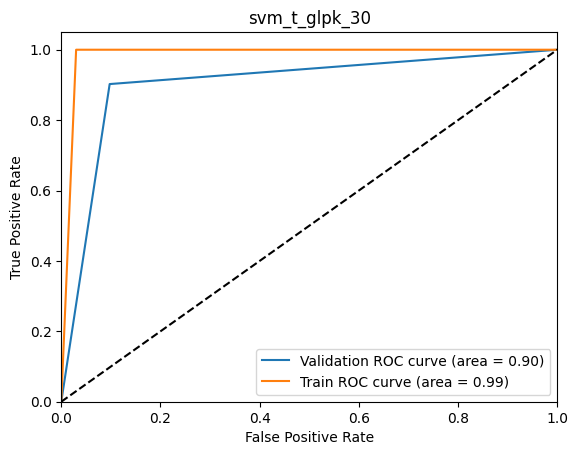

[np.float64(0.9266666666666666), np.float64(0.94), np.float64(0.93), np.float64(0.9266666666666666), np.float64(0.9136212624584718), np.float64(0.9302325581395349), np.float64(0.9136212624584718), np.float64(0.920265780730897), np.float64(0.920265780730897), np.float64(0.920265780730897)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

R2 score:  0.5609756097560976
MAE:  0.21951219512195122
RMSE:  0.6625891564490792
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7807200583588265), pvalue=np.float64(5.211876443882128e-18))
Accuracy:  0.8902439024390244
Train accuracy:  0.9520958083832335
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        41
           2       0.90      0.88      0.89        41

    accuracy                           0.89        82
   macro avg       0.89      0.89      0.89        82
weighted avg       0.89      0.89      0.89        82



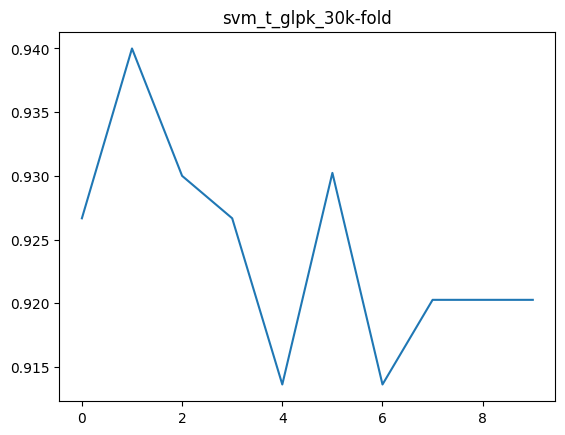

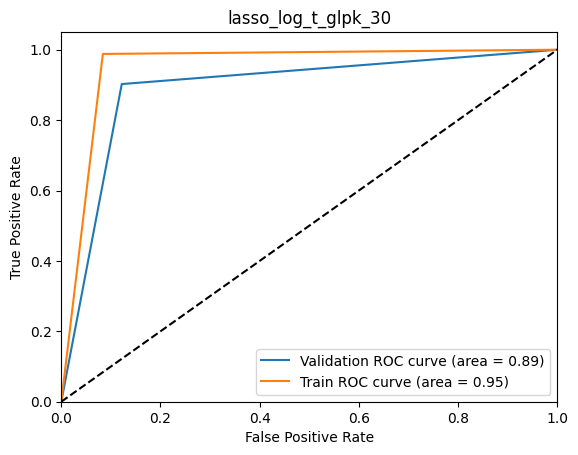

[np.float64(0.9466666666666667), np.float64(0.9533333333333334), np.float64(0.94), np.float64(0.94), np.float64(0.9501661129568106), np.float64(0.9435215946843853), np.float64(0.9435215946843853), np.float64(0.946843853820598), np.float64(0.9401993355481728), np.float64(0.946843853820598)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  0.5609756097560976
MAE:  0.21951219512195122
RMSE:  0.6625891564490792
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7807200583588265), pvalue=np.float64(5.211876443882128e-18))
Accuracy:  0.8902439024390244
Train accuracy:  0.9281437125748503
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        41
           2       0.88      0.90      0.89        41

    accuracy                           0.89        82
   macro avg       0.89      0.89      0.89        82
weighted avg       0.89      0.89      0.89        82



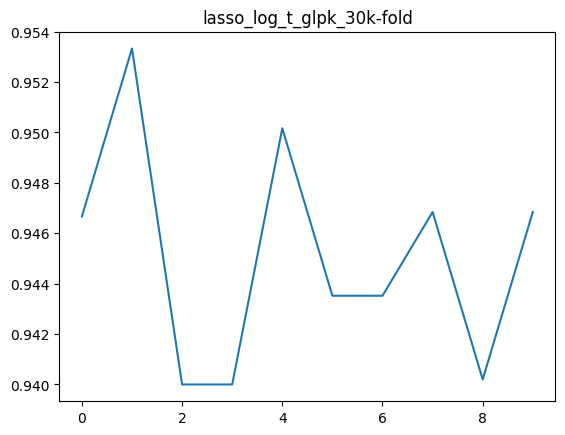

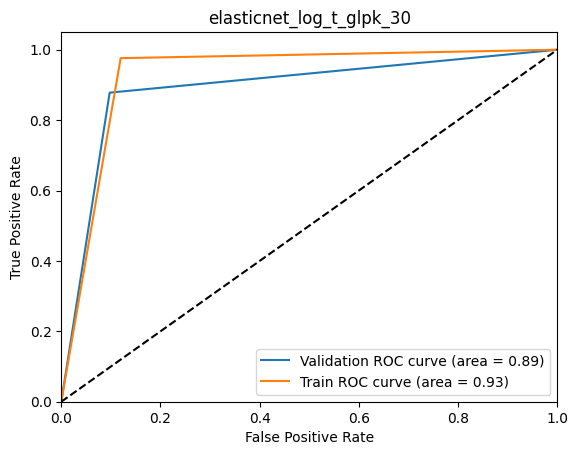

[np.float64(0.9433333333333334), np.float64(0.9433333333333334), np.float64(0.9433333333333334), np.float64(0.93), np.float64(0.9335548172757475), np.float64(0.9335548172757475), np.float64(0.9368770764119602), np.float64(0.9335548172757475), np.float64(0.9335548172757475), np.float64(0.9269102990033222)]
R2 score:  -0.2195121951219512
MAE:  0.6097560975609756
RMSE:  1.1043152607484654
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.4543694673976519), pvalue=np.float64(1.8035660911252493e-05))
Accuracy:  0.6951219512195121
Train accuracy:  0.7874251497005988
              precision    recall  f1-score   support

           0       0.63      0.95      0.76        41
           2       0.90      0.44      0.59        41

    accuracy                           0.70        82
   macro avg       0.76      0.70      0.67        82
weighted avg       0.76      0.70      0.67        82



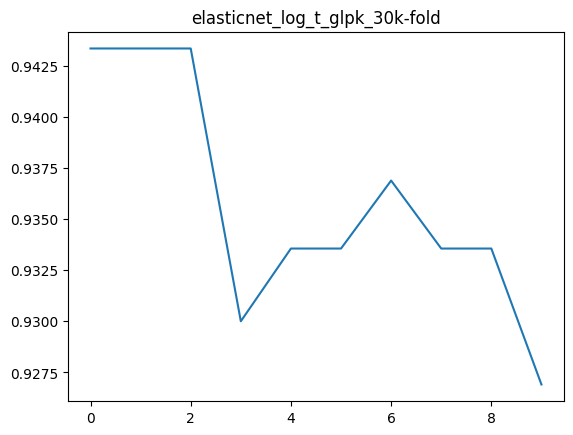

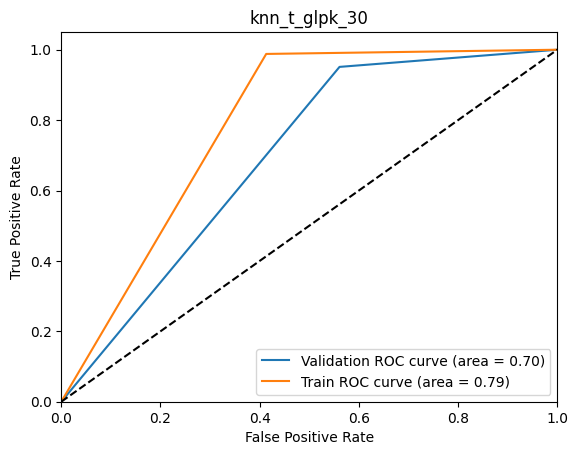

[np.float64(0.79), np.float64(0.79), np.float64(0.7766666666666666), np.float64(0.7866666666666666), np.float64(0.7873754152823921), np.float64(0.7906976744186046), np.float64(0.813953488372093), np.float64(0.770764119601329), np.float64(0.7873754152823921), np.float64(0.7740863787375415)]


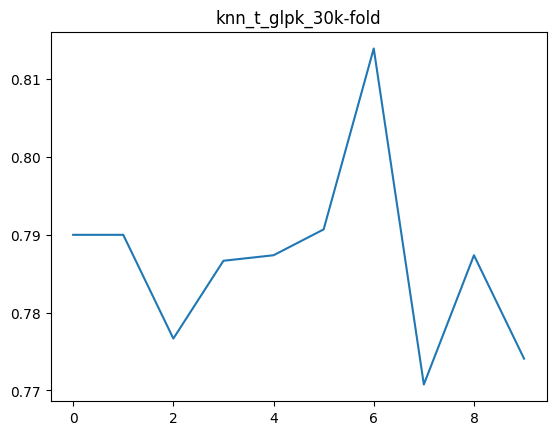

In [329]:
#load and preprocess data
[t, fluxes_t, p, fluxes_p, gr_measured_ML, y] = load_dataset()

#filter based on percentile
[gr_measured_ML, y] = filter_ko(gr_measured_ML, y, 30, 70)

#concatenate the dataframes
X = generate_combined_dataset(t, p, fluxes_t, fluxes_p)

#split transcriptomics dataset into train, test and validation
[y_train_liq, y_test_liq, y_valid_liq] = split_data(gr_measured_ML)
X_train_liq = X.loc[y_train_liq.index, :]
X_test_liq = X.loc[y_test_liq.index, :]
X_valid_liq = X.loc[y_valid_liq.index, :]

y_valid_liq = y_valid_liq['class']
y_train_liq = y_train_liq['class']
y_test_liq = y_test_liq['class']

#split proteomics dataset into train, test and validation
[y_train_solid, y_test_solid, y_valid_solid] = split_data(y)
X_train_solid = X.loc[y_train_solid.index, :]
X_test_solid = X.loc[y_test_solid.index, :]
X_valid_solid = X.loc[y_valid_solid.index, :]

y_train_solid = y_train_solid['class']
y_test_solid = y_test_solid['class']
y_valid_solid = y_valid_solid['class']

#subset train and validation for transcriptomics
x_train = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
x_valid = X_valid_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]


temp = SVM_model(x_train, x_valid, y_train_liq, y_valid_liq, 'svm_t_glpk_30', temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_liq, y_valid_liq, 'lasso_log_t_glpk_30', temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_liq, y_valid_liq, 'elasticnet_log_t_glpk_30', temp)
temp = kNN_model(x_train, x_valid, y_train_liq, y_valid_liq, 'knn_t_glpk_30', temp)

R2 score:  0.46341463414634143
MAE:  0.2682926829268293
RMSE:  0.7325198740332296
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7319250547113999), pvalue=np.float64(5.6429528256703584e-15))
Accuracy:  0.8658536585365854
Train accuracy:  0.9790419161676647
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        41
           2       0.88      0.85      0.86        41

    accuracy                           0.87        82
   macro avg       0.87      0.87      0.87        82
weighted avg       0.87      0.87      0.87        82



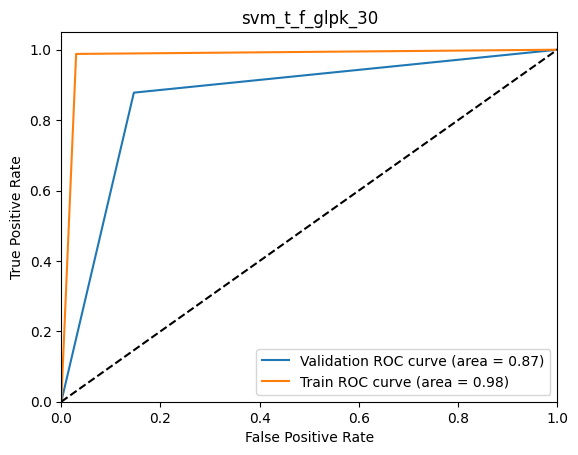

[np.float64(0.9433333333333334), np.float64(0.9433333333333334), np.float64(0.9433333333333334), np.float64(0.9433333333333334), np.float64(0.9401993355481728), np.float64(0.9401993355481728), np.float64(0.9368770764119602), np.float64(0.9335548172757475), np.float64(0.9401993355481728), np.float64(0.9302325581395349)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

R2 score:  0.36585365853658536
MAE:  0.3170731707317073
RMSE:  0.7963330593811955
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6831300510639732), pvalue=np.float64(1.5439150361188631e-12))
Accuracy:  0.8414634146341463
Train accuracy:  0.9820359281437125
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        41
           2       0.85      0.83      0.84        41

    accuracy                           0.84        82
   macro avg       0.84      0.84      0.84        82
weighted avg       0.84      0.84      0.84        82



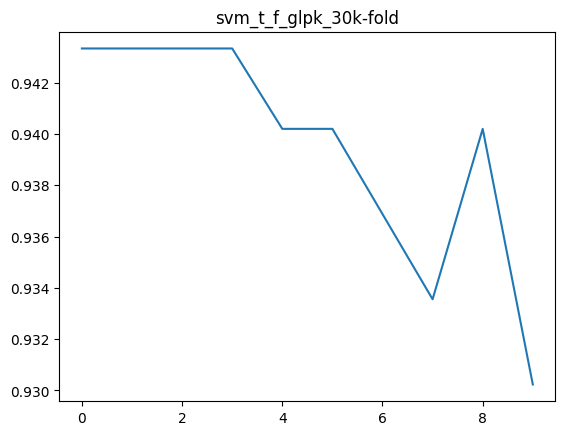

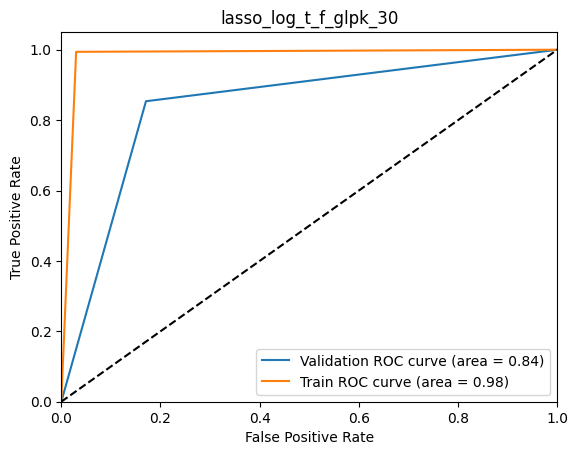

[np.float64(0.98), np.float64(0.9833333333333333), np.float64(0.9866666666666667), np.float64(0.9833333333333333), np.float64(0.9833887043189369), np.float64(0.9767441860465116), np.float64(0.9867109634551495), np.float64(0.9767441860465116), np.float64(0.9800664451827242), np.float64(0.9867109634551495)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  0.31707317073170727
MAE:  0.34146341463414637
RMSE:  0.8263938705413374
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6616931598844269), pvalue=np.float64(1.307034196576511e-11))
Accuracy:  0.8292682926829268
Train accuracy:  0.9191616766467066
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        41
           2       0.86      0.78      0.82        41

    accuracy                           0.83        82
   macro avg       0.83      0.83      0.83        82
weighted avg       0.83      0.83      0.83        82



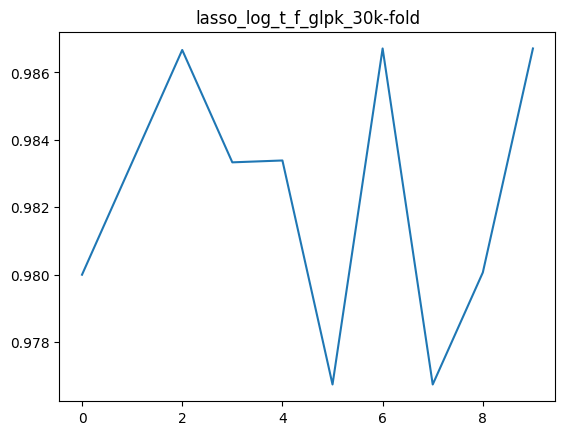

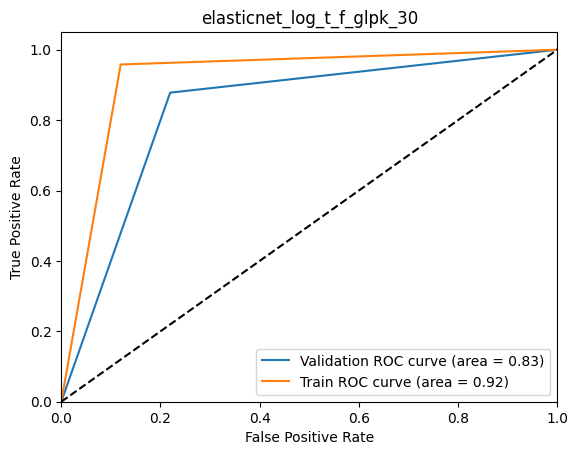

[np.float64(0.9166666666666666), np.float64(0.9233333333333333), np.float64(0.9233333333333333), np.float64(0.9266666666666666), np.float64(0.9269102990033222), np.float64(0.9269102990033222), np.float64(0.9169435215946844), np.float64(0.9169435215946844), np.float64(0.9235880398671097), np.float64(0.9136212624584718)]
R2 score:  0.024390243902439046
MAE:  0.4878048780487805
RMSE:  0.9877295966495896
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5700715542877982), pvalue=np.float64(2.266420165598949e-08))
Accuracy:  0.7560975609756098
Train accuracy:  0.8353293413173652
              precision    recall  f1-score   support

           0       0.68      0.98      0.80        41
           2       0.96      0.54      0.69        41

    accuracy                           0.76        82
   macro avg       0.82      0.76      0.74        82
weighted avg       0.82      0.76      0.74        82



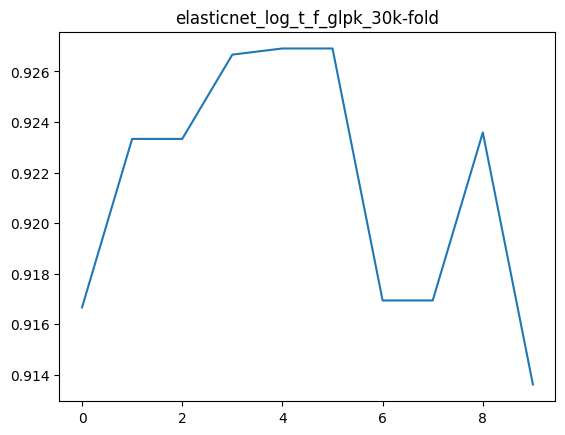

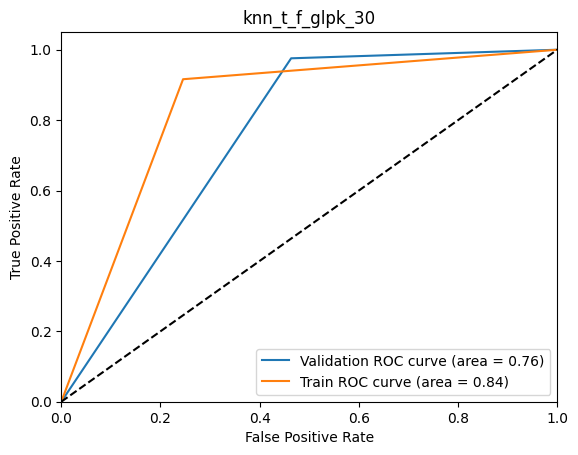

[np.float64(0.83), np.float64(0.85), np.float64(0.8333333333333334), np.float64(0.84), np.float64(0.8272425249169435), np.float64(0.8272425249169435), np.float64(0.8372093023255814), np.float64(0.8305647840531561), np.float64(0.8272425249169435), np.float64(0.8272425249169435)]


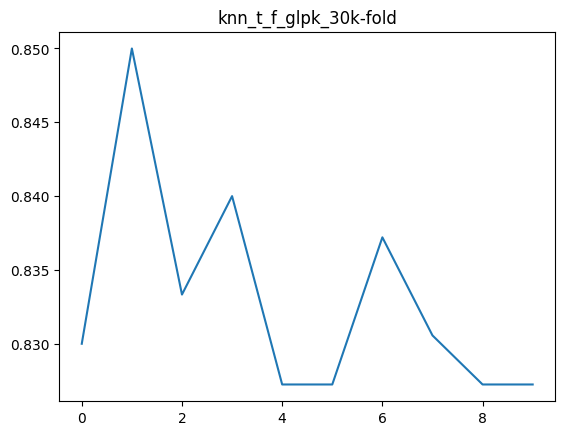

In [352]:
transcriptome = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
flux = X_train_liq.iloc[:, 1826: 3776]
x_train = pd.concat([transcriptome, flux], axis=1)
x_valid = X_valid_liq.iloc[:, 0:3776].loc[:, x_train.columns]

temp = SVM_model(x_train, x_valid, y_train_liq, y_valid_liq, 'svm_t_f_glpk_30', temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_liq, y_valid_liq, 'lasso_log_t_f_glpk_30', temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_liq, y_valid_liq, 'elasticnet_log_t_f_glpk_30', temp)
temp = kNN_model(x_train, x_valid, y_train_liq, y_valid_liq, 'knn_t_f_glpk_30', temp)

R2 score:  0.4567073170731708
MAE:  0.2716049382716049
RMSE:  0.7370277311900888
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7389452279358296), pvalue=np.float64(3.3961067374697323e-15))
Accuracy:  0.8641975308641975
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.94      0.78      0.85        40
           2       0.81      0.95      0.88        41

    accuracy                           0.86        81
   macro avg       0.88      0.86      0.86        81
weighted avg       0.88      0.86      0.86        81



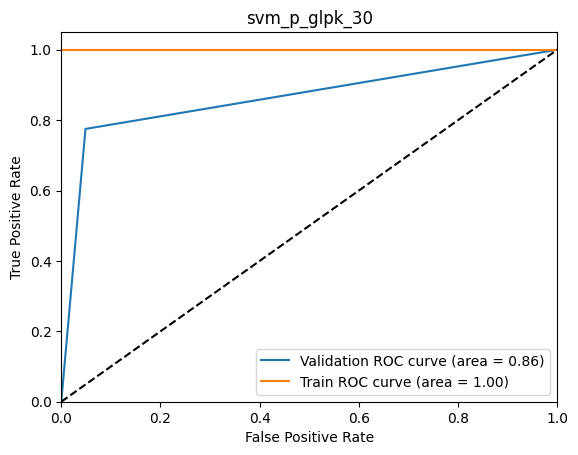

[np.float64(0.993127147766323), np.float64(0.993127147766323), np.float64(0.9896907216494846), np.float64(0.993127147766323), np.float64(0.9931506849315068), np.float64(0.9931506849315068), np.float64(0.9931506849315068), np.float64(0.9863013698630136), np.float64(0.9931506849315068), np.float64(0.9931506849315068)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------

R2 score:  0.40731707317073185
MAE:  0.2962962962962963
RMSE:  0.769800358919501
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.725357973267731), pvalue=np.float64(1.8815698076381432e-14))
Accuracy:  0.8518518518518519
Train accuracy:  0.9938271604938271
              precision    recall  f1-score   support

           0       0.97      0.72      0.83        40
           2       0.78      0.98      0.87        41

    accuracy                           0.85        81
   macro avg       0.88      0.85      0.85        81
weighted avg       0.87      0.85      0.85        81



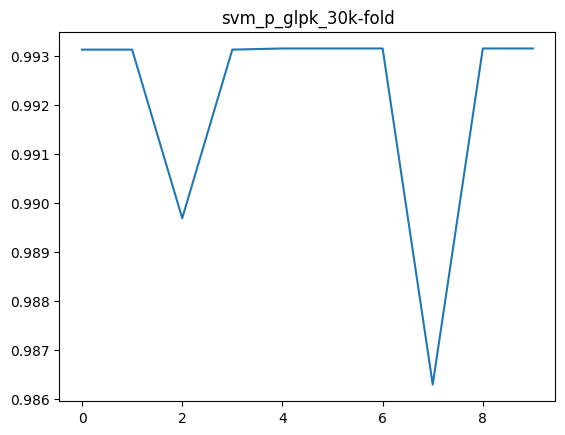

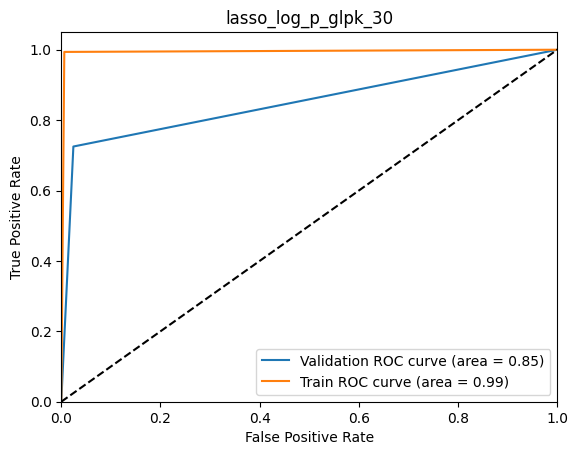

[np.float64(0.9965635738831615), np.float64(0.993127147766323), np.float64(0.993127147766323), np.float64(0.993127147766323), np.float64(0.9931506849315068), np.float64(0.9965753424657534), np.float64(0.9931506849315068), np.float64(0.9931506849315068), np.float64(0.9931506849315068), np.float64(0.9931506849315068)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  0.40731707317073185
MAE:  0.2962962962962963
RMSE:  0.769800358919501
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.725357973267731), pvalue=np.float64(1.8815698076381432e-14))
Accuracy:  0.8518518518518519
Train accuracy:  0.9938271604938271
              precision    recall  f1-score   support

           0       0.97      0.72      0.83        40
           2       0.78      0.98      0.87        41

    accuracy                           0.85        81
   macro avg       0.88      0.85      0.85        81
weighted avg       0.87      0.85      0.85        81



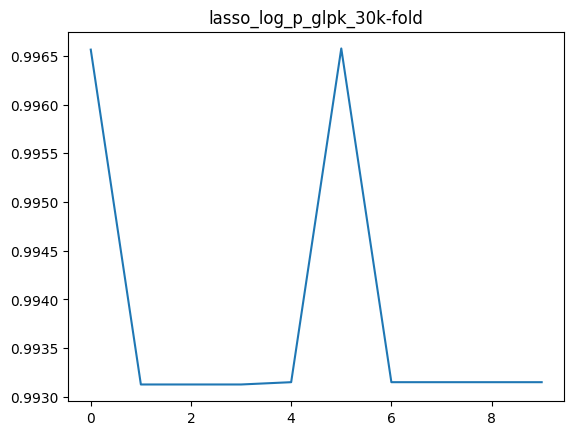

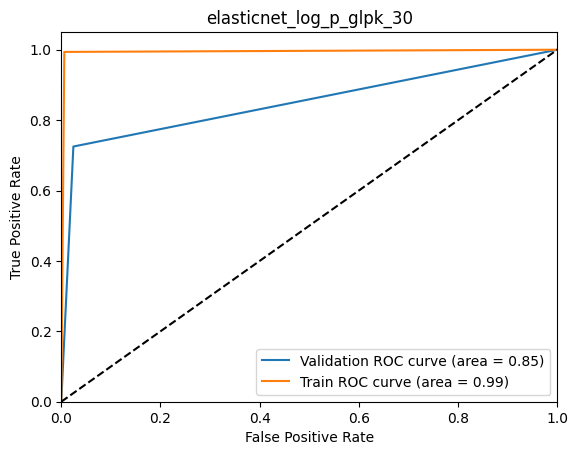

[np.float64(0.993127147766323), np.float64(0.993127147766323), np.float64(0.9896907216494846), np.float64(0.993127147766323), np.float64(0.9897260273972602), np.float64(0.9965753424657534), np.float64(0.9931506849315068), np.float64(0.9897260273972602), np.float64(0.9931506849315068), np.float64(0.9931506849315068)]
R2 score:  -0.1853658536585363
MAE:  0.5925925925925926
RMSE:  1.0886621079036347
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.4516750947539785), pvalue=np.float64(2.3113792310836874e-05))
Accuracy:  0.7037037037037037
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.86      0.47      0.61        40
           2       0.64      0.93      0.76        41

    accuracy                           0.70        81
   macro avg       0.75      0.70      0.69        81
weighted avg       0.75      0.70      0.69        81



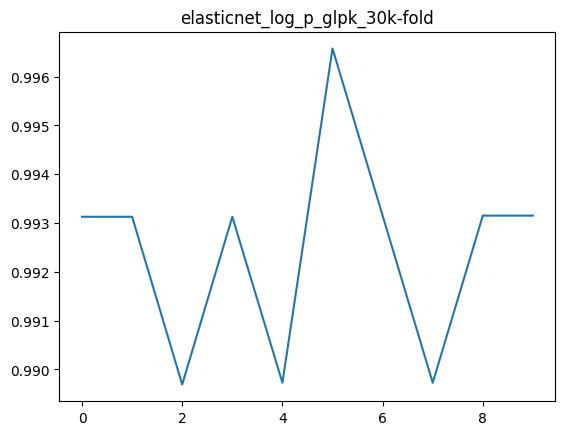

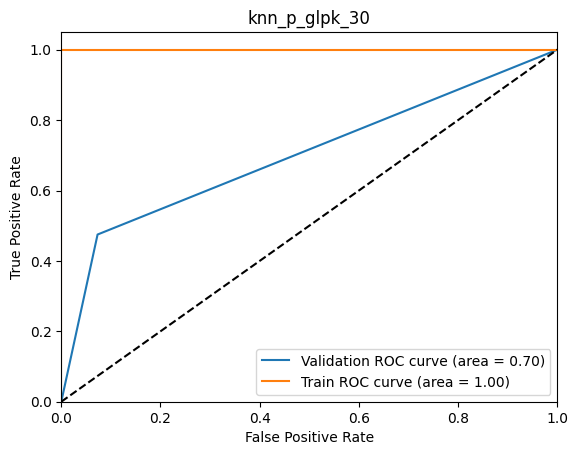

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


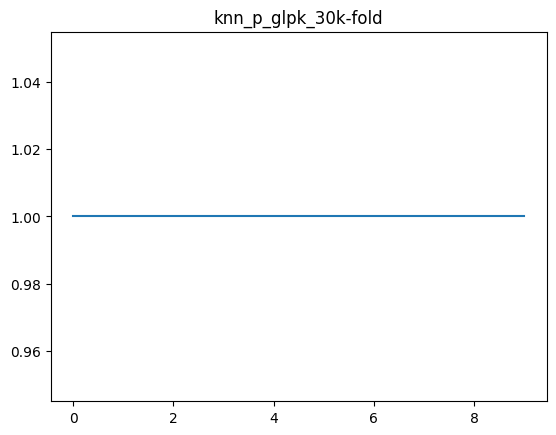

In [353]:
x_train = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
x_valid = X_valid_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
x_train.dropna(inplace=True)
x_valid.dropna(inplace=True)

temp = SVM_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'svm_p_glpk_30', temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'lasso_log_p_glpk_30', temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'elasticnet_log_p_glpk_30', temp)
temp = kNN_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'knn_p_glpk_30', temp)

R2 score:  0.5554878048780489
MAE:  0.2222222222222222
RMSE:  0.6666666666666666
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7892009487274353), pvalue=np.float64(2.1097052235456945e-18))
Accuracy:  0.8888888888888888
Train accuracy:  0.9691358024691358
              precision    recall  f1-score   support

           0       0.97      0.80      0.88        40
           2       0.83      0.98      0.90        41

    accuracy                           0.89        81
   macro avg       0.90      0.89      0.89        81
weighted avg       0.90      0.89      0.89        81



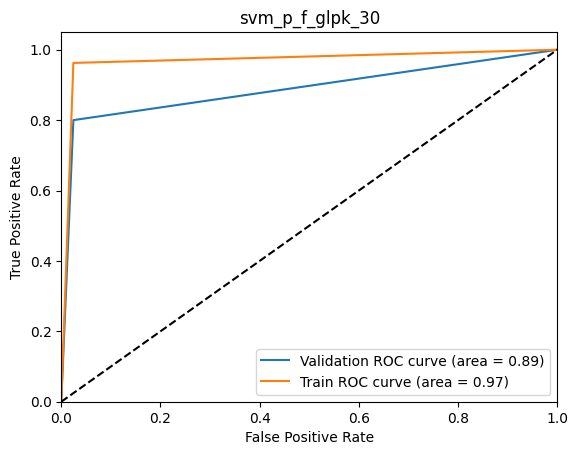

[np.float64(0.9965635738831615), np.float64(0.993127147766323), np.float64(0.993127147766323), np.float64(0.993127147766323), np.float64(0.9931506849315068), np.float64(1.0), np.float64(0.9931506849315068), np.float64(0.9931506849315068), np.float64(0.9931506849315068), np.float64(0.9931506849315068)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

R2 score:  0.5060975609756099
MAE:  0.24691358024691357
RMSE:  0.7027283689263065
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7676497268681703), pvalue=np.float64(6.276730691823675e-17))
Accuracy:  0.8765432098765432
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.97      0.78      0.86        40
           2       0.82      0.98      0.89        41

    accuracy                           0.88        81
   macro avg       0.89      0.88      0.88        81
weighted avg       0.89      0.88      0.88        81



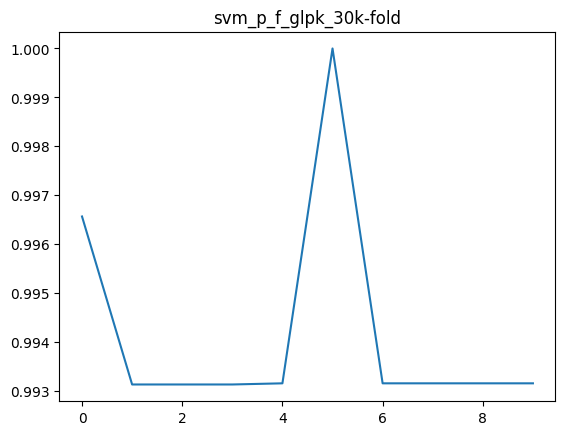

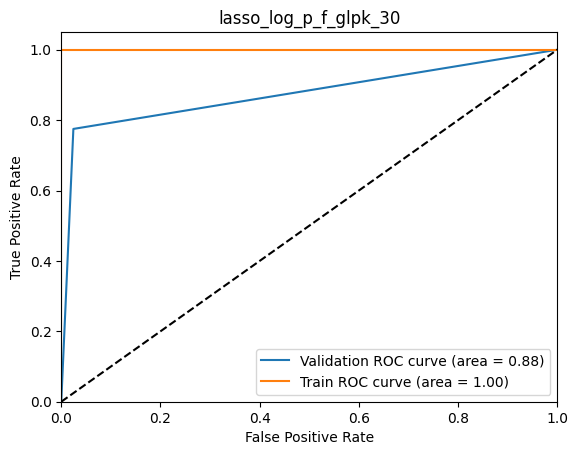

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  0.4567073170731708
MAE:  0.2716049382716049
RMSE:  0.7370277311900888
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7389452279358296), pvalue=np.float64(3.3961067374697323e-15))
Accuracy:  0.8641975308641975
Train accuracy:  0.9722222222222222
              precision    recall  f1-score   support

           0       0.94      0.78      0.85        40
           2       0.81      0.95      0.88        41

    accuracy                           0.86        81
   macro avg       0.88      0.86      0.86        81
weighted avg       0.88      0.86      0.86        81



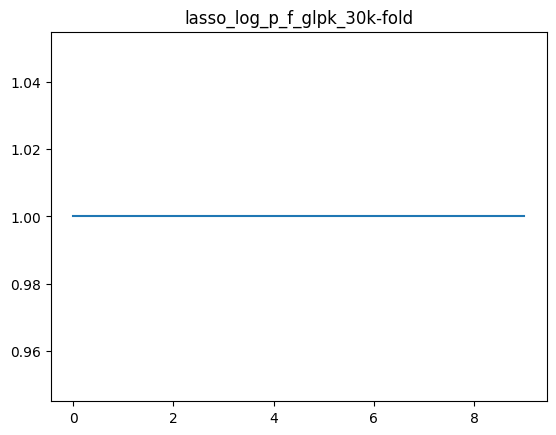

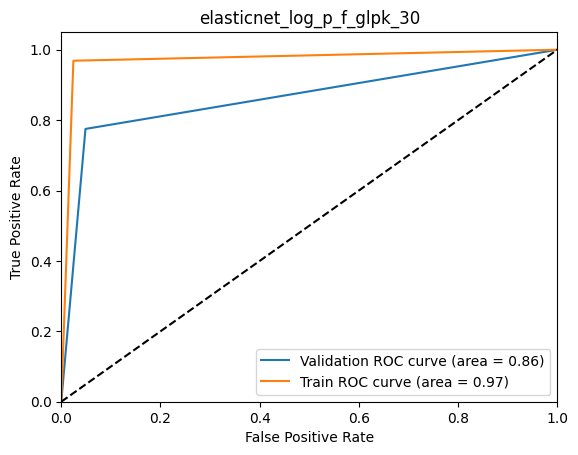

[np.float64(0.9725085910652921), np.float64(0.9690721649484536), np.float64(0.9759450171821306), np.float64(0.9725085910652921), np.float64(0.9691780821917808), np.float64(0.9691780821917808), np.float64(0.9657534246575342), np.float64(0.9794520547945206), np.float64(0.9691780821917808), np.float64(0.9657534246575342)]
R2 score:  -0.4323170731707313
MAE:  0.7160493827160493
RMSE:  1.1967032904743342
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.30897003442655624), pvalue=np.float64(0.005007850182214385))
Accuracy:  0.6419753086419753
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.74      0.42      0.54        40
           2       0.60      0.85      0.71        41

    accuracy                           0.64        81
   macro avg       0.67      0.64      0.62        81
weighted avg       0.67      0.64      0.62        81



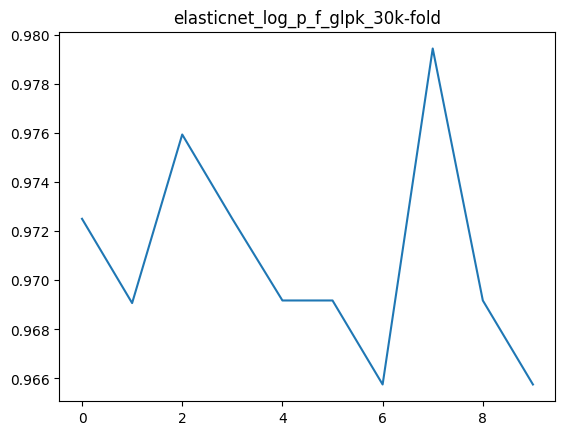

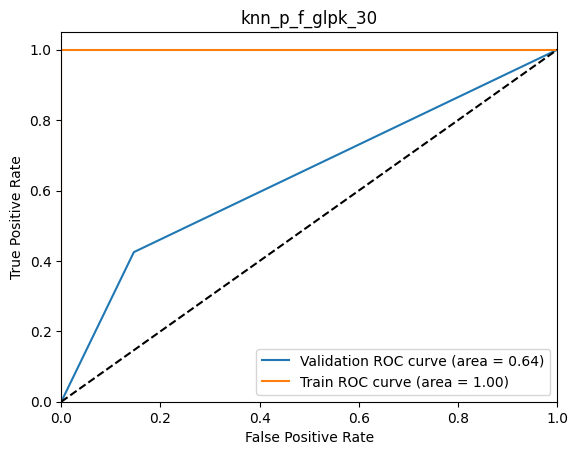

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


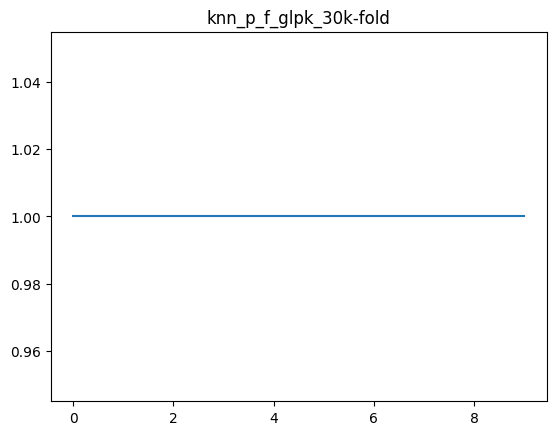

In [354]:
proteome = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
flux = X_train_solid.iloc[:, 5602: ]
x_train = pd.concat([proteome, flux], axis=1)
x_valid = X_valid_solid.iloc[:, 3776:].loc[:, x_train.columns]

x_train.dropna(inplace=True)
x_valid.dropna(inplace=True)

temp = SVM_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'svm_p_f_glpk_30', temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'lasso_log_p_f_glpk_30', temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'elasticnet_log_p_f_glpk_30', temp)
temp = kNN_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'knn_p_f_glpk_30', temp)

10-90th percentile split

/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_46332/3380375233.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_train = y.groupby('class', group_keys=False).apply(lambda x: x.sample(n=train_size//2, random_state=42))
/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_46332/3380375233.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_valid = train_valid.groupby('class', group_

R2 score:  1.0
MAE:  0.0
RMSE:  0.0
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(1.0), pvalue=np.float64(0.0))
Accuracy:  1.0
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        14

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



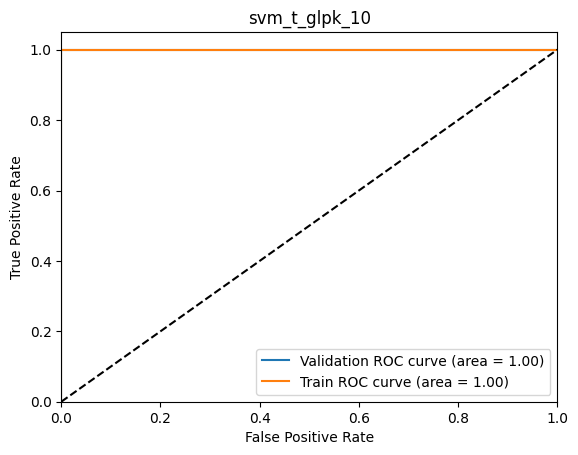

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sk

R2 score:  1.0
MAE:  0.0
RMSE:  0.0
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(1.0), pvalue=np.float64(0.0))
Accuracy:  1.0
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        14

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



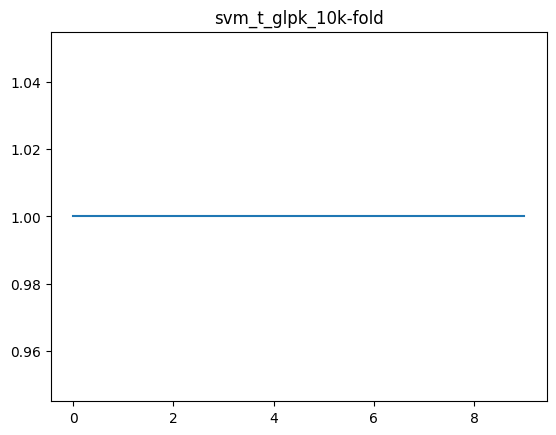

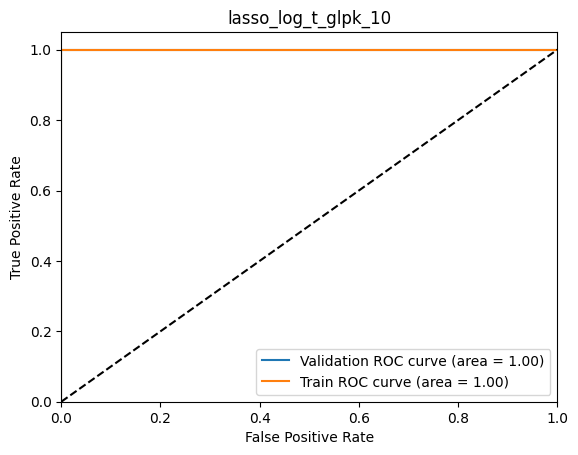

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  1.0
MAE:  0.0
RMSE:  0.0
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(1.0), pvalue=np.float64(0.0))
Accuracy:  1.0
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        14

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



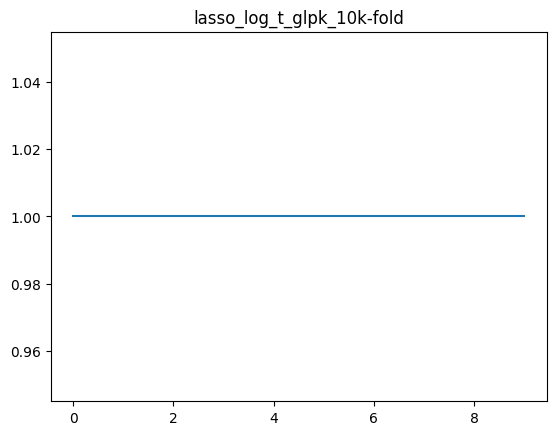

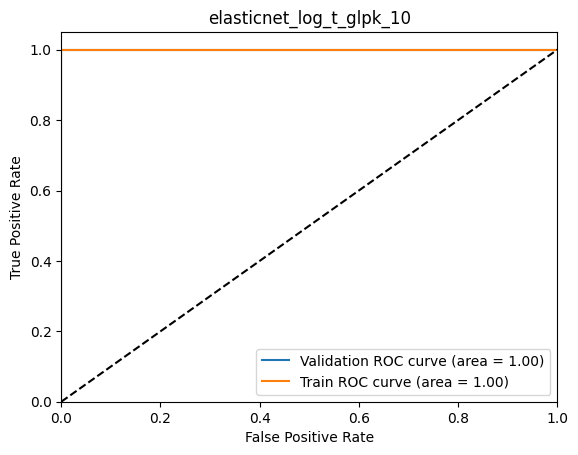

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R2 score:  0.8571428571428572
MAE:  0.07142857142857142
RMSE:  0.3779644730092272
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.9309493362512629), pvalue=np.float64(6.969462332994666e-13))
Accuracy:  0.9642857142857143
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           2       1.00      0.93      0.96        14

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.96        28
weighted avg       0.97      0.96      0.96        28



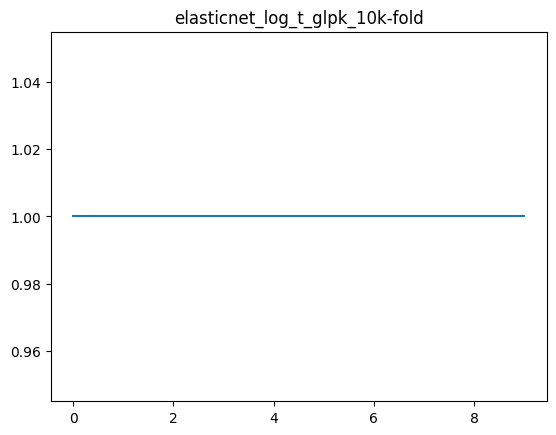

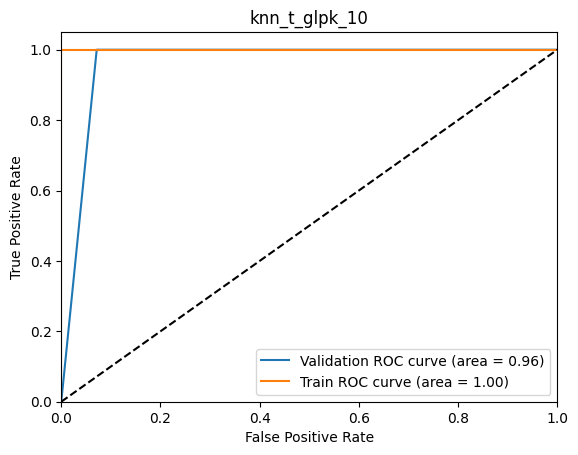

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R2 score:  1.0
MAE:  0.0
RMSE:  0.0
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(1.0), pvalue=np.float64(0.0))
Accuracy:  1.0
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        14

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



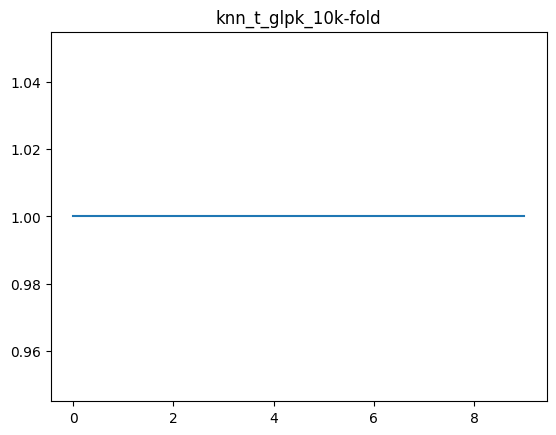

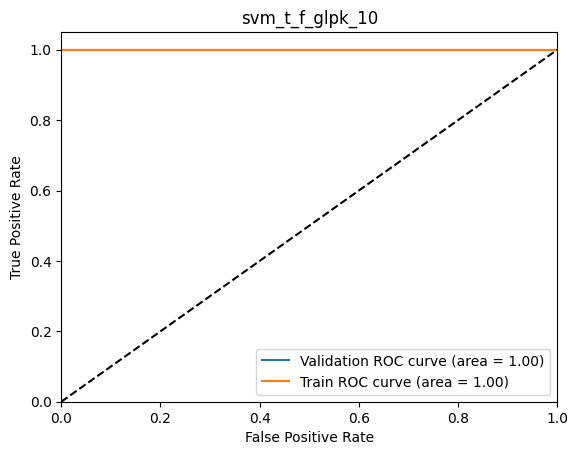

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sk

R2 score:  0.8571428571428572
MAE:  0.07142857142857142
RMSE:  0.3779644730092272
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.9309493362512629), pvalue=np.float64(6.969462332994666e-13))
Accuracy:  0.9642857142857143
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           2       0.93      1.00      0.97        14

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.96        28
weighted avg       0.97      0.96      0.96        28



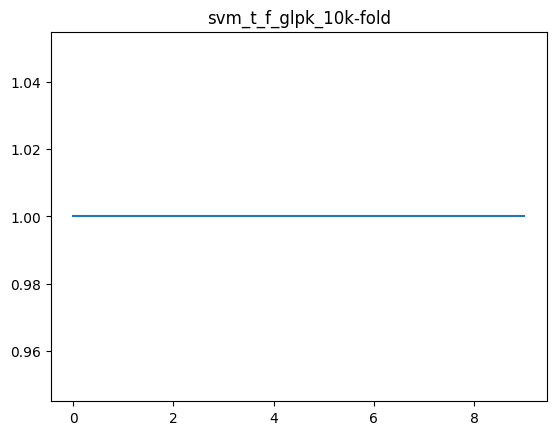

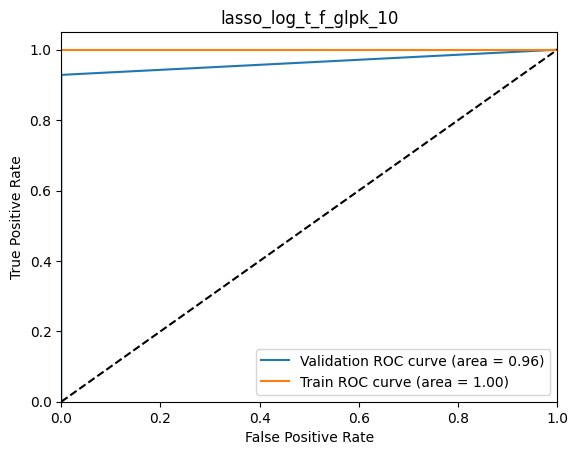

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  0.8571428571428572
MAE:  0.07142857142857142
RMSE:  0.3779644730092272
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.9309493362512629), pvalue=np.float64(6.969462332994666e-13))
Accuracy:  0.9642857142857143
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           2       0.93      1.00      0.97        14

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.96        28
weighted avg       0.97      0.96      0.96        28



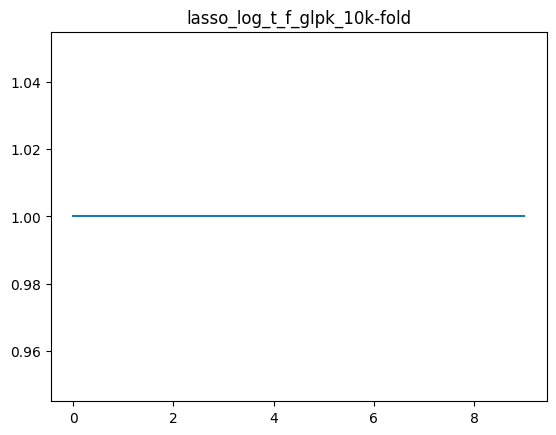

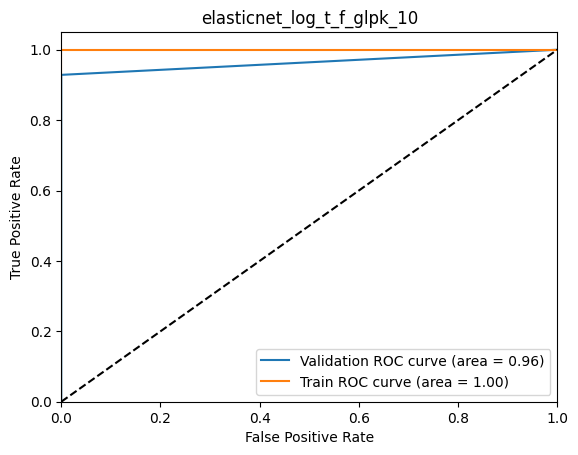

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9900990099009901), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9900990099009901)]
R2 score:  0.8571428571428572
MAE:  0.07142857142857142
RMSE:  0.3779644730092272
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.9309493362512629), pvalue=np.float64(6.969462332994666e-13))
Accuracy:  0.9642857142857143
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           2       0.93      1.00      0.97        14

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.96        28
weighted avg       0.97      0.96      0.96        28



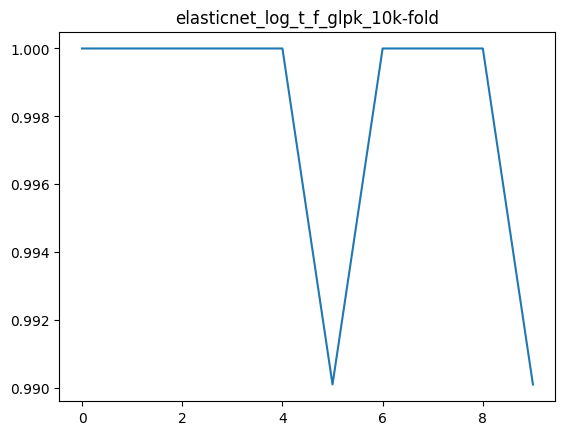

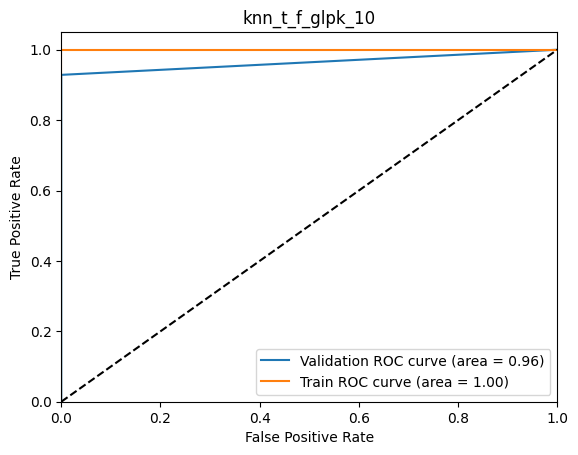

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R2 score:  0.7032967032967034
MAE:  0.14814814814814814
RMSE:  0.5443310539518174
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8516483516483517), pvalue=np.float64(1.770505887697313e-08))
Accuracy:  0.9259259259259259
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           2       0.93      0.93      0.93        14

    accuracy                           0.93        27
   macro avg       0.93      0.93      0.93        27
weighted avg       0.93      0.93      0.93        27



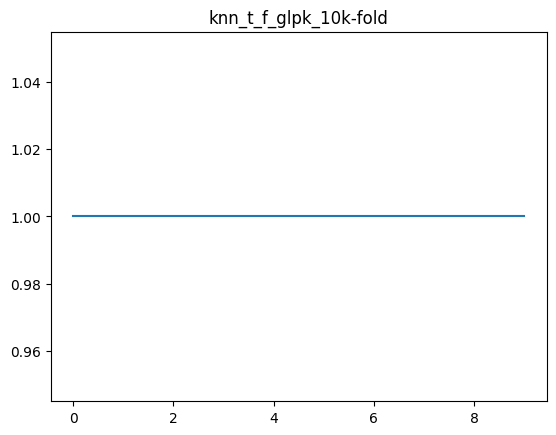

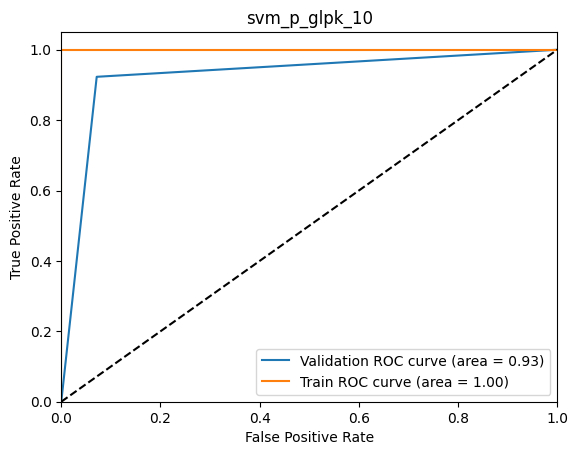

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sk

R2 score:  0.7032967032967034
MAE:  0.14814814814814814
RMSE:  0.5443310539518174
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8516483516483517), pvalue=np.float64(1.770505887697313e-08))
Accuracy:  0.9259259259259259
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           2       0.93      0.93      0.93        14

    accuracy                           0.93        27
   macro avg       0.93      0.93      0.93        27
weighted avg       0.93      0.93      0.93        27



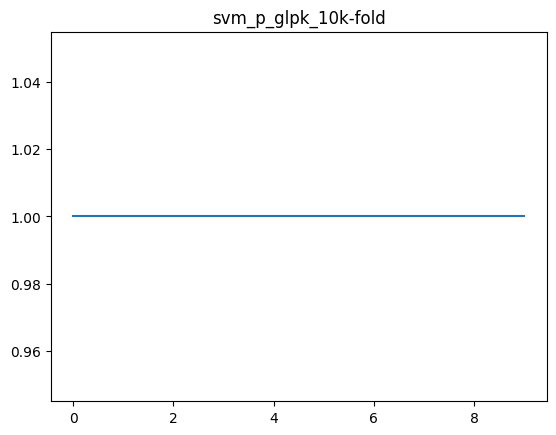

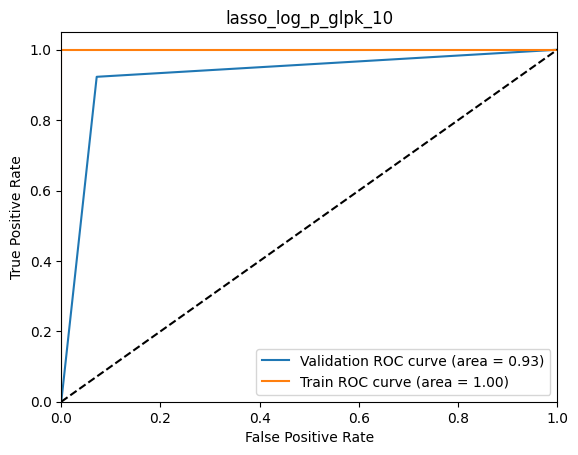

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  0.7032967032967034
MAE:  0.14814814814814814
RMSE:  0.5443310539518174
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8516483516483517), pvalue=np.float64(1.770505887697313e-08))
Accuracy:  0.9259259259259259
Train accuracy:  0.9819819819819819
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           2       0.93      0.93      0.93        14

    accuracy                           0.93        27
   macro avg       0.93      0.93      0.93        27
weighted avg       0.93      0.93      0.93        27



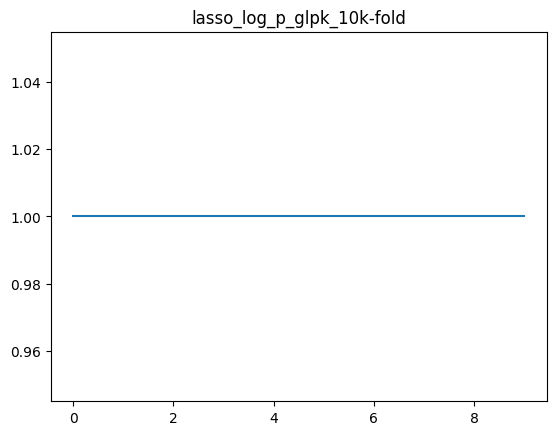

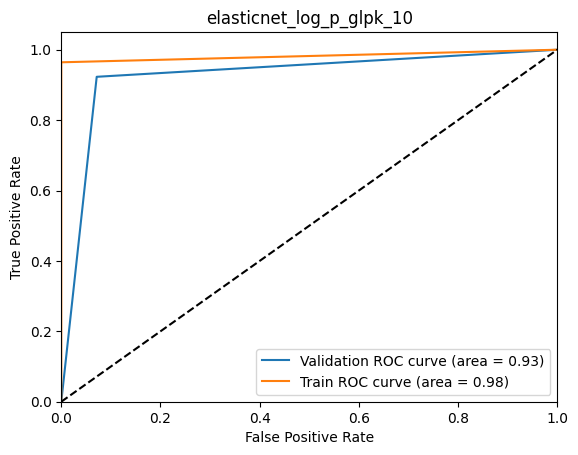

[np.float64(1.0), np.float64(0.98), np.float64(0.98), np.float64(0.99), np.float64(0.98), np.float64(0.98), np.float64(0.98), np.float64(0.99), np.float64(0.99), np.float64(0.99)]
R2 score:  0.7032967032967034
MAE:  0.14814814814814814
RMSE:  0.5443310539518174
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8604560508152729), pvalue=np.float64(8.660621739546232e-09))
Accuracy:  0.9259259259259259
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           2       0.88      1.00      0.93        14

    accuracy                           0.93        27
   macro avg       0.94      0.92      0.93        27
weighted avg       0.94      0.93      0.93        27



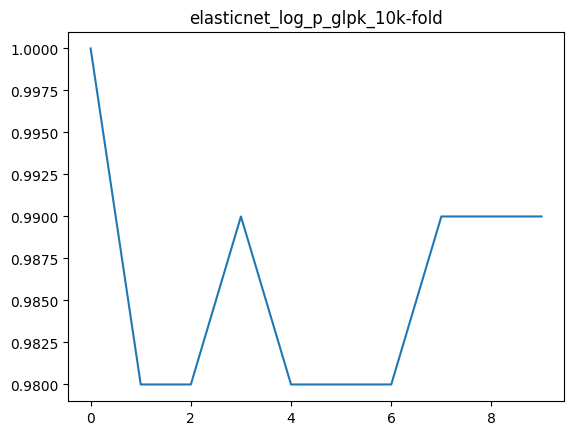

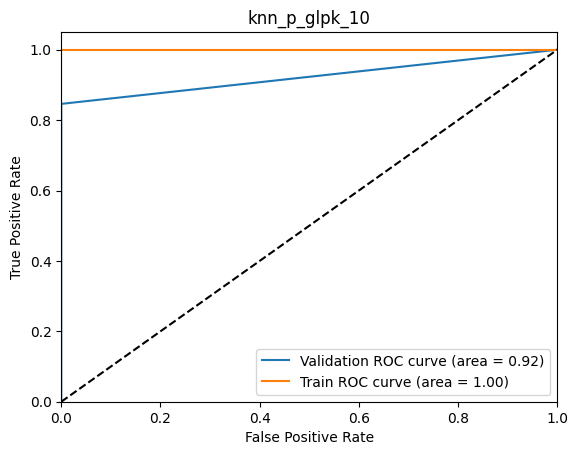

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R2 score:  0.554945054945055
MAE:  0.2222222222222222
RMSE:  0.6666666666666666
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7802197802197803), pvalue=np.float64(1.5935476222155572e-06))
Accuracy:  0.8888888888888888
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           2       0.92      0.86      0.89        14

    accuracy                           0.89        27
   macro avg       0.89      0.89      0.89        27
weighted avg       0.89      0.89      0.89        27



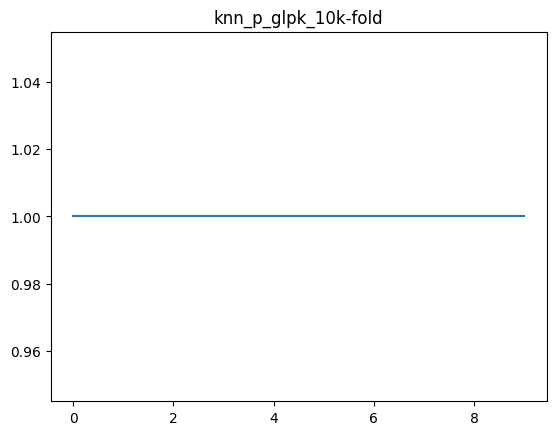

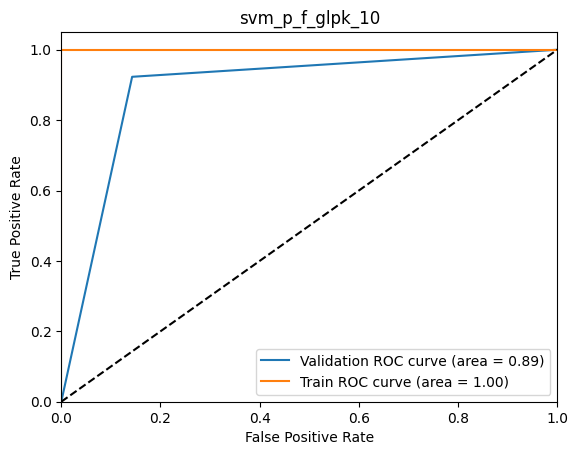

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sk

R2 score:  0.554945054945055
MAE:  0.2222222222222222
RMSE:  0.6666666666666666
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7802197802197803), pvalue=np.float64(1.5935476222155572e-06))
Accuracy:  0.8888888888888888
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           2       0.92      0.86      0.89        14

    accuracy                           0.89        27
   macro avg       0.89      0.89      0.89        27
weighted avg       0.89      0.89      0.89        27



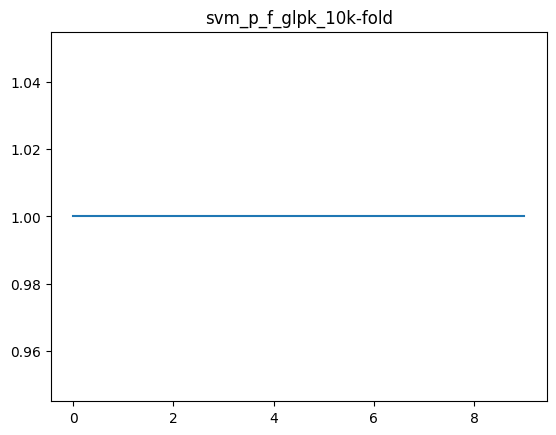

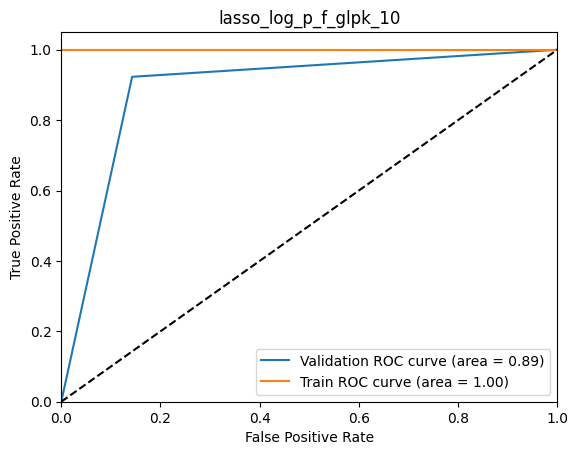

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  0.554945054945055
MAE:  0.2222222222222222
RMSE:  0.6666666666666666
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7802197802197803), pvalue=np.float64(1.5935476222155572e-06))
Accuracy:  0.8888888888888888
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           2       0.92      0.86      0.89        14

    accuracy                           0.89        27
   macro avg       0.89      0.89      0.89        27
weighted avg       0.89      0.89      0.89        27



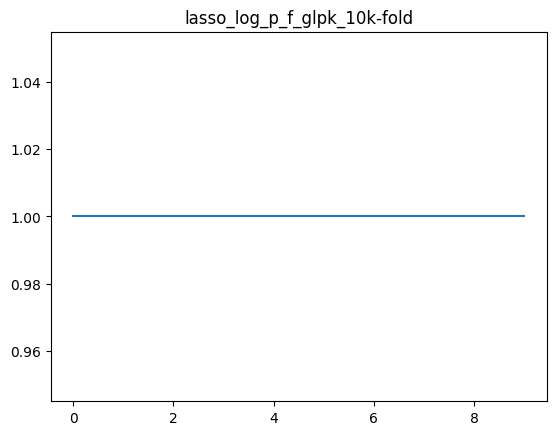

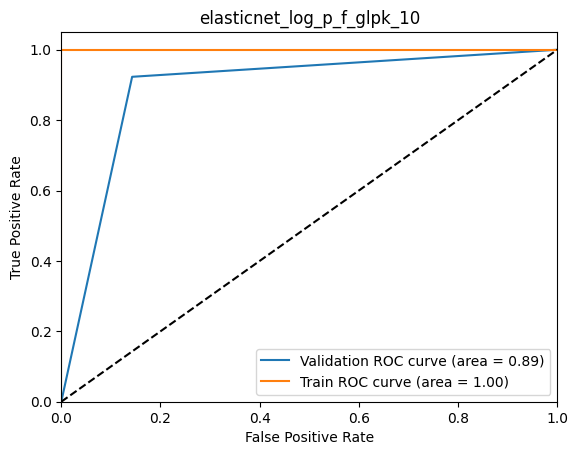

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R2 score:  0.4065934065934067
MAE:  0.2962962962962963
RMSE:  0.769800358919501
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7095968730749328), pvalue=np.float64(3.400964052917563e-05))
Accuracy:  0.8518518518518519
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           2       0.81      0.93      0.87        14

    accuracy                           0.85        27
   macro avg       0.86      0.85      0.85        27
weighted avg       0.86      0.85      0.85        27



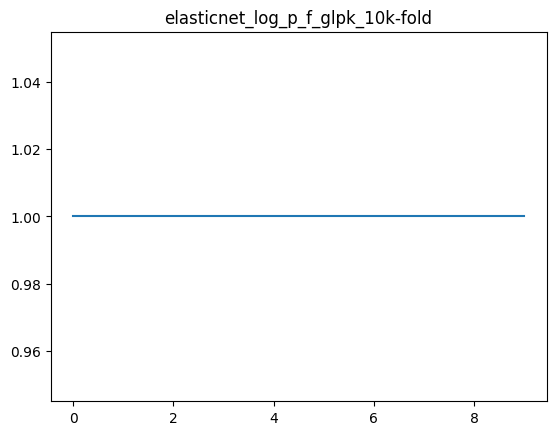

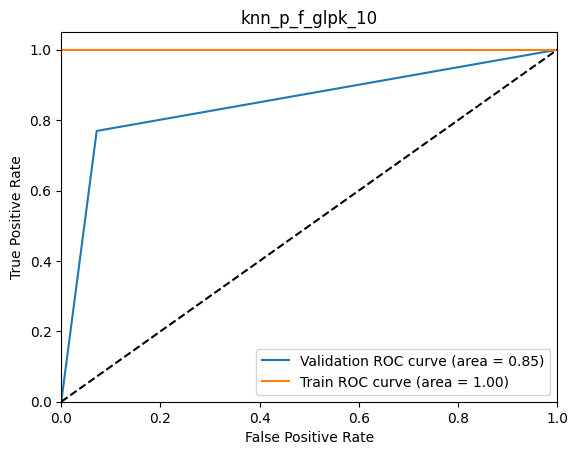

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


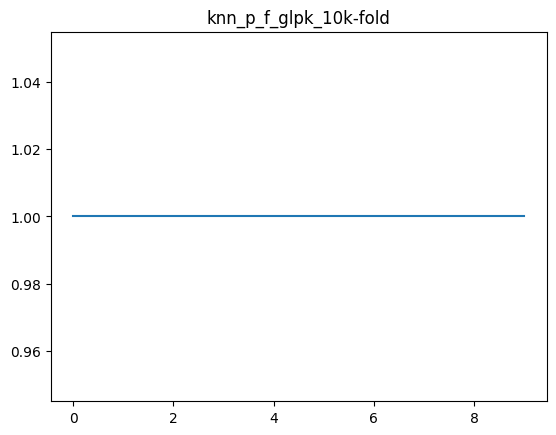

In [355]:
#load and preprocess data
[t, fluxes_t, p, fluxes_p, gr_measured_ML, y] = load_dataset()

percent = 10

#filter based on percentile
[gr_measured_ML, y] = filter_ko(gr_measured_ML, y, percent, 100 - percent)

#concatenate the dataframes
X = generate_combined_dataset(t, p, fluxes_t, fluxes_p)

#split transcriptomics dataset into train, test and validation
[y_train_liq, y_test_liq, y_valid_liq] = split_data(gr_measured_ML)
X_train_liq = X.loc[y_train_liq.index, :]
X_test_liq = X.loc[y_test_liq.index, :]
X_valid_liq = X.loc[y_valid_liq.index, :]

y_valid_liq = y_valid_liq['class']
y_train_liq = y_train_liq['class']
y_test_liq = y_test_liq['class']

#split proteomics dataset into train, test and validation
[y_train_solid, y_test_solid, y_valid_solid] = split_data(y)
X_train_solid = X.loc[y_train_solid.index, :]
X_test_solid = X.loc[y_test_solid.index, :]
X_valid_solid = X.loc[y_valid_solid.index, :]

y_train_solid = y_train_solid['class']
y_test_solid = y_test_solid['class']
y_valid_solid = y_valid_solid['class']

#subset train and validation for transcriptomics
x_train = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
x_valid = X_valid_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]


temp = SVM_model(x_train, x_valid, y_train_liq, y_valid_liq, 'svm_t_glpk_'+str(percent), temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_liq, y_valid_liq, 'lasso_log_t_glpk_'+str(percent), temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_liq, y_valid_liq, 'elasticnet_log_t_glpk_'+str(percent), temp)
temp = kNN_model(x_train, x_valid, y_train_liq, y_valid_liq, 'knn_t_glpk_'+str(percent), temp)



transcriptome = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
flux = X_train_liq.iloc[:, 1826: 3776]
x_train = pd.concat([transcriptome, flux], axis=1)
x_valid = X_valid_liq.iloc[:, 0:3776].loc[:, x_train.columns]

temp = SVM_model(x_train, x_valid, y_train_liq, y_valid_liq, 'svm_t_f_glpk_'+str(percent), temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_liq, y_valid_liq, 'lasso_log_t_f_glpk_'+str(percent), temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_liq, y_valid_liq, 'elasticnet_log_t_f_glpk_'+str(percent), temp)
temp = kNN_model(x_train, x_valid, y_train_liq, y_valid_liq, 'knn_t_f_glpk_'+str(percent), temp)

x_train = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
x_valid = X_valid_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
x_train.dropna(inplace=True)
x_valid.dropna(inplace=True)

temp = SVM_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'svm_p_glpk_'+str(percent), temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'lasso_log_p_glpk_'+str(percent), temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'elasticnet_log_p_glpk_'+str(percent), temp)
temp = kNN_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'knn_p_glpk_'+str(percent), temp)


proteome = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
flux = X_train_solid.iloc[:, 5602: ]
x_train = pd.concat([proteome, flux], axis=1)
x_valid = X_valid_solid.iloc[:, 3776:].loc[:, x_train.columns]
x_train.dropna(inplace=True)
x_valid.dropna(inplace=True)

temp = SVM_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'svm_p_f_glpk_'+str(percent), temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'lasso_log_p_f_glpk_'+str(percent), temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'elasticnet_log_p_f_glpk_'+str(percent), temp)
temp = kNN_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'knn_p_f_glpk_'+str(percent), temp)

20-80th percentile split

/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_46332/3380375233.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_train = y.groupby('class', group_keys=False).apply(lambda x: x.sample(n=train_size//2, random_state=42))
/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_46332/3380375233.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_valid = train_valid.groupby('class', group_

R2 score:  0.7777777777777778
MAE:  0.1111111111111111
RMSE:  0.4714045207910317
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8894991799933214), pvalue=np.float64(2.5300225601219586e-19))
Accuracy:  0.9444444444444444
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        27
           2       0.93      0.96      0.95        27

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.94        54
weighted avg       0.95      0.94      0.94        54



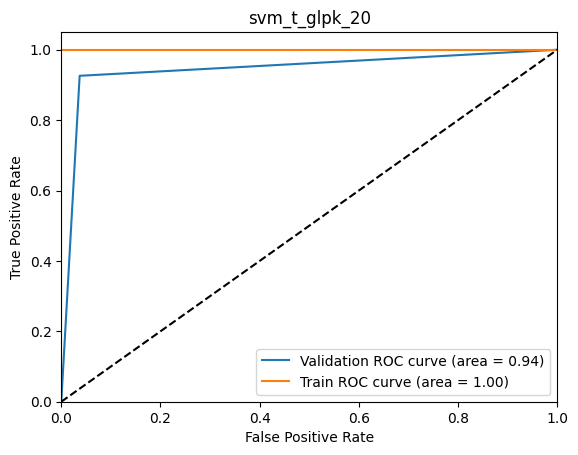

[np.float64(0.949748743718593), np.float64(0.9547738693467337), np.float64(0.955), np.float64(0.96), np.float64(0.965), np.float64(0.96), np.float64(0.96), np.float64(0.955), np.float64(0.97), np.float64(0.96)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

R2 score:  0.6296296296296297
MAE:  0.18518518518518517
RMSE:  0.6085806194501846
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8153742483272112), pvalue=np.float64(6.07079616180176e-14))
Accuracy:  0.9074074074074074
Train accuracy:  0.9774774774774775
              precision    recall  f1-score   support

           0       0.92      0.89      0.91        27
           2       0.89      0.93      0.91        27

    accuracy                           0.91        54
   macro avg       0.91      0.91      0.91        54
weighted avg       0.91      0.91      0.91        54



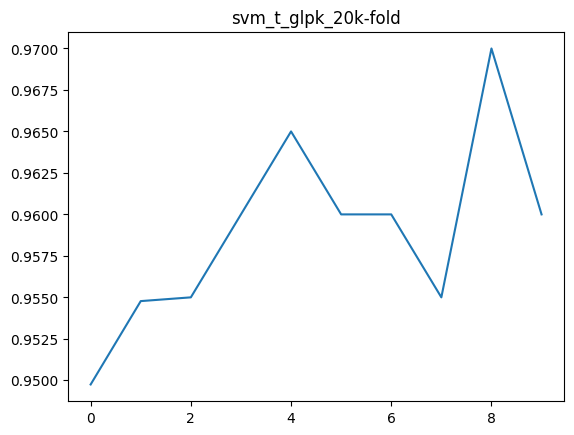

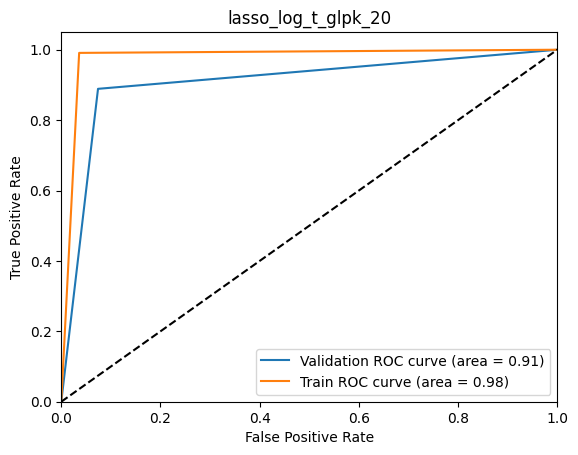

[np.float64(0.9748743718592965), np.float64(0.9748743718592965), np.float64(0.98), np.float64(0.975), np.float64(0.975), np.float64(0.98), np.float64(0.98), np.float64(0.97), np.float64(0.98), np.float64(0.975)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  0.6296296296296297
MAE:  0.18518518518518517
RMSE:  0.6085806194501846
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8153742483272112), pvalue=np.float64(6.07079616180176e-14))
Accuracy:  0.9074074074074074
Train accuracy:  0.954954954954955
              precision    recall  f1-score   support

           0       0.92      0.89      0.91        27
           2       0.89      0.93      0.91        27

    accuracy                           0.91        54
   macro avg       0.91      0.91      0.91        54
weighted avg       0.91      0.91      0.91        54



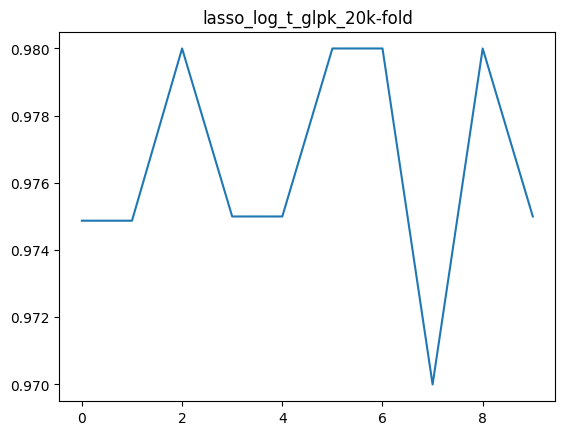

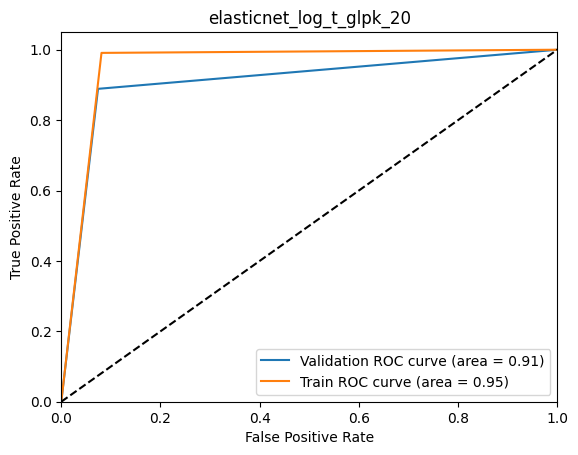

[np.float64(0.9447236180904522), np.float64(0.949748743718593), np.float64(0.955), np.float64(0.96), np.float64(0.95), np.float64(0.955), np.float64(0.955), np.float64(0.945), np.float64(0.95), np.float64(0.955)]
R2 score:  0.40740740740740744
MAE:  0.2962962962962963
RMSE:  0.769800358919501
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7367883976130073), pvalue=np.float64(2.134626591465386e-10))
Accuracy:  0.8518518518518519
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        27
           2       1.00      0.70      0.83        27

    accuracy                           0.85        54
   macro avg       0.89      0.85      0.85        54
weighted avg       0.89      0.85      0.85        54



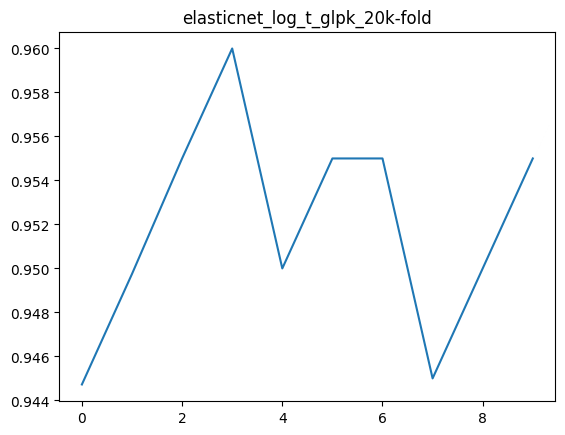

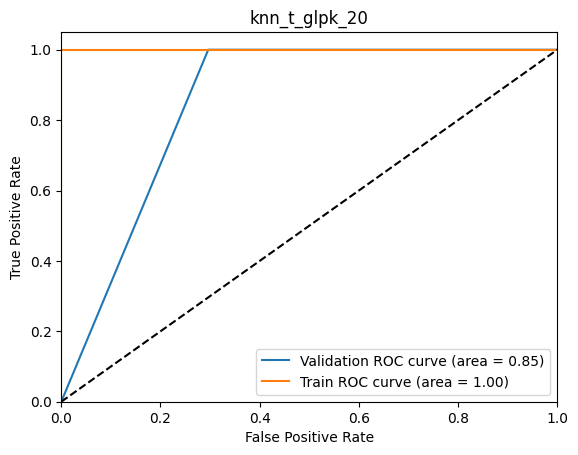

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R2 score:  0.6296296296296297
MAE:  0.18518518518518517
RMSE:  0.6085806194501846
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.82915619758885), pvalue=np.float64(9.676761757799134e-15))
Accuracy:  0.9074074074074074
Train accuracy:  0.990990990990991
              precision    recall  f1-score   support

           0       1.00      0.81      0.90        27
           2       0.84      1.00      0.92        27

    accuracy                           0.91        54
   macro avg       0.92      0.91      0.91        54
weighted avg       0.92      0.91      0.91        54



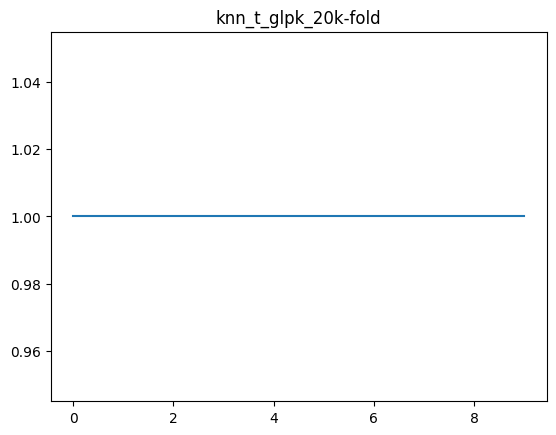

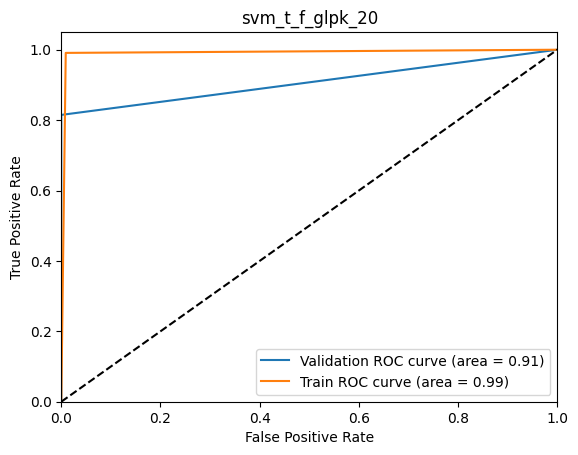

[np.float64(0.9698492462311558), np.float64(0.9698492462311558), np.float64(0.97), np.float64(0.98), np.float64(0.97), np.float64(0.975), np.float64(0.975), np.float64(0.97), np.float64(0.975), np.float64(0.975)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

R2 score:  0.40740740740740744
MAE:  0.2962962962962963
RMSE:  0.769800358919501
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7056422850727971), pvalue=np.float64(2.5429577812222132e-09))
Accuracy:  0.8518518518518519
Train accuracy:  0.972972972972973
              precision    recall  f1-score   support

           0       0.88      0.81      0.85        27
           2       0.83      0.89      0.86        27

    accuracy                           0.85        54
   macro avg       0.85      0.85      0.85        54
weighted avg       0.85      0.85      0.85        54



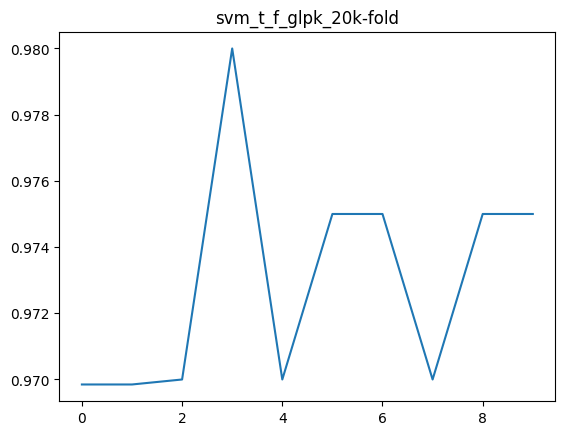

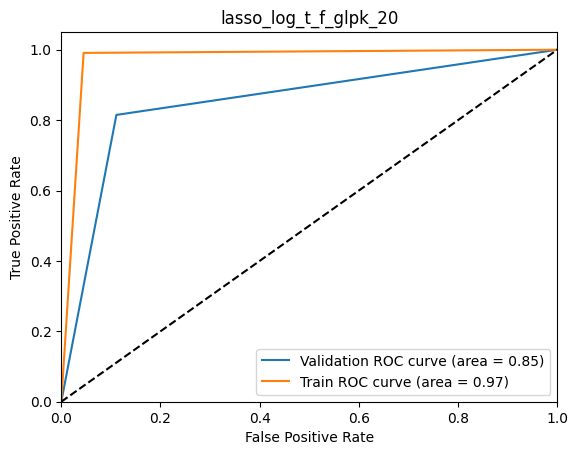

[np.float64(0.9698492462311558), np.float64(0.9698492462311558), np.float64(0.97), np.float64(0.98), np.float64(0.975), np.float64(0.975), np.float64(0.975), np.float64(0.975), np.float64(0.98), np.float64(0.975)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  0.40740740740740744
MAE:  0.2962962962962963
RMSE:  0.769800358919501
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7056422850727971), pvalue=np.float64(2.5429577812222132e-09))
Accuracy:  0.8518518518518519
Train accuracy:  0.9594594594594594
              precision    recall  f1-score   support

           0       0.88      0.81      0.85        27
           2       0.83      0.89      0.86        27

    accuracy                           0.85        54
   macro avg       0.85      0.85      0.85        54
weighted avg       0.85      0.85      0.85        54



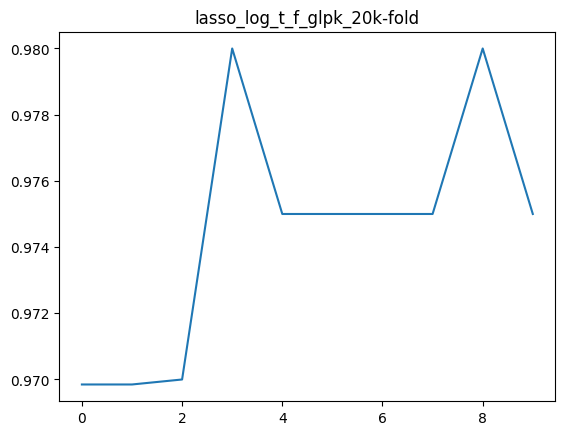

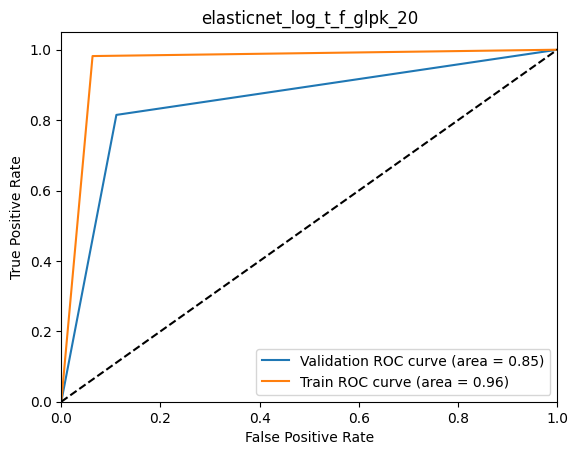

[np.float64(0.949748743718593), np.float64(0.9547738693467337), np.float64(0.955), np.float64(0.955), np.float64(0.94), np.float64(0.965), np.float64(0.96), np.float64(0.965), np.float64(0.96), np.float64(0.96)]
R2 score:  0.11111111111111116
MAE:  0.4444444444444444
RMSE:  0.9428090415820634
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5555555555555556), pvalue=np.float64(1.2968933830365666e-05))
Accuracy:  0.7777777777777778
Train accuracy:  0.8288288288288288
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        27
           2       0.78      0.78      0.78        27

    accuracy                           0.78        54
   macro avg       0.78      0.78      0.78        54
weighted avg       0.78      0.78      0.78        54



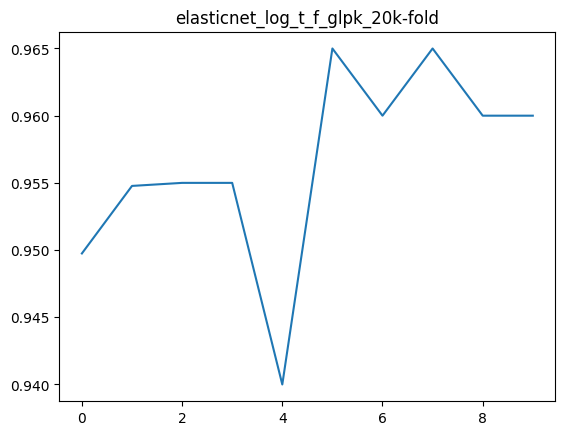

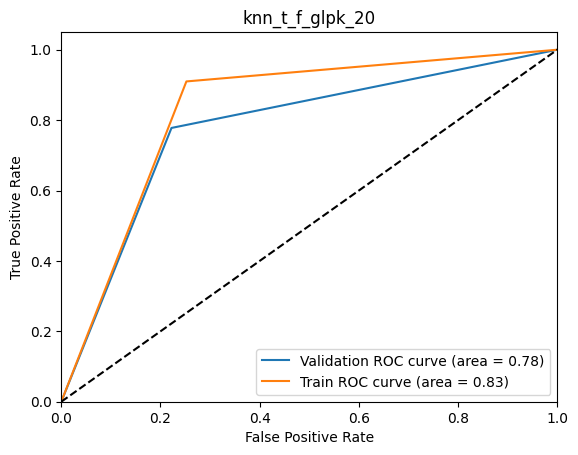

[np.float64(0.8391959798994975), np.float64(0.8190954773869347), np.float64(0.825), np.float64(0.835), np.float64(0.84), np.float64(0.83), np.float64(0.835), np.float64(0.835), np.float64(0.83), np.float64(0.83)]
R2 score:  0.6296296296296297
MAE:  0.18518518518518517
RMSE:  0.6085806194501846
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8198915917499228), pvalue=np.float64(3.383149496572388e-14))
Accuracy:  0.9074074074074074
Train accuracy:  0.9811320754716981
              precision    recall  f1-score   support

           0       0.96      0.85      0.90        27
           2       0.87      0.96      0.91        27

    accuracy                           0.91        54
   macro avg       0.91      0.91      0.91        54
weighted avg       0.91      0.91      0.91        54



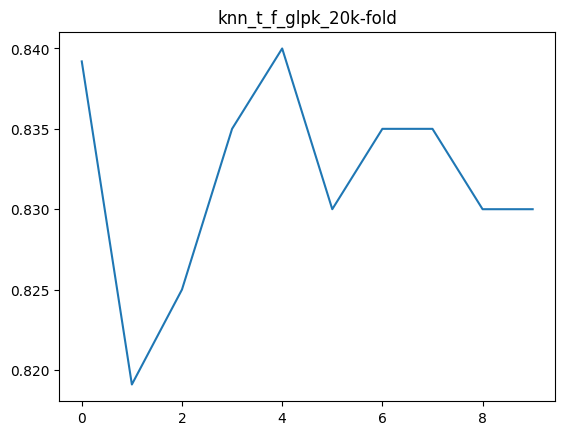

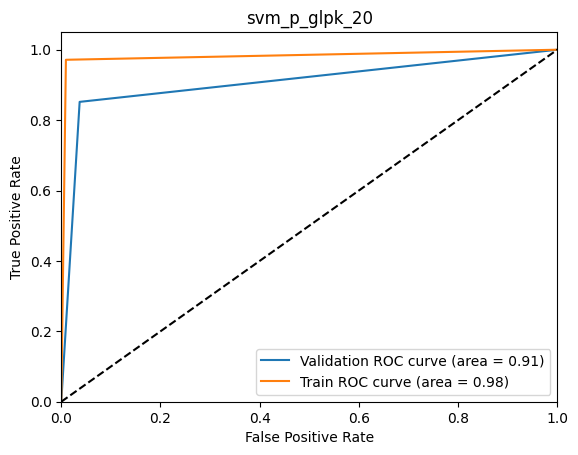

[np.float64(0.9947368421052631), np.float64(0.9947368421052631), np.float64(1.0), np.float64(0.9947643979057592), np.float64(0.9947643979057592), np.float64(0.9947643979057592), np.float64(0.9947643979057592), np.float64(0.9947643979057592), np.float64(0.9947643979057592), np.float64(0.9947643979057592)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sk

R2 score:  0.6296296296296297
MAE:  0.18518518518518517
RMSE:  0.6085806194501846
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.82915619758885), pvalue=np.float64(9.676761757799134e-15))
Accuracy:  0.9074074074074074
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      0.81      0.90        27
           2       0.84      1.00      0.92        27

    accuracy                           0.91        54
   macro avg       0.92      0.91      0.91        54
weighted avg       0.92      0.91      0.91        54



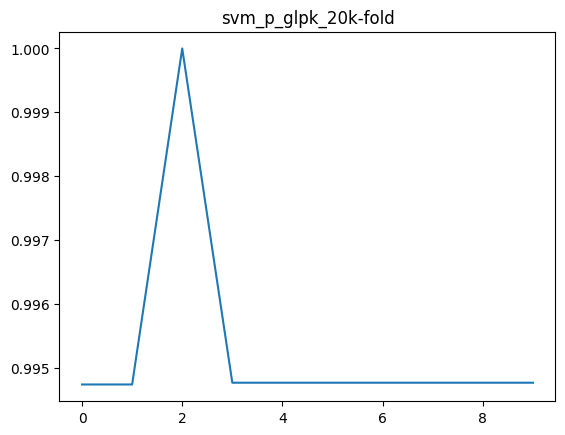

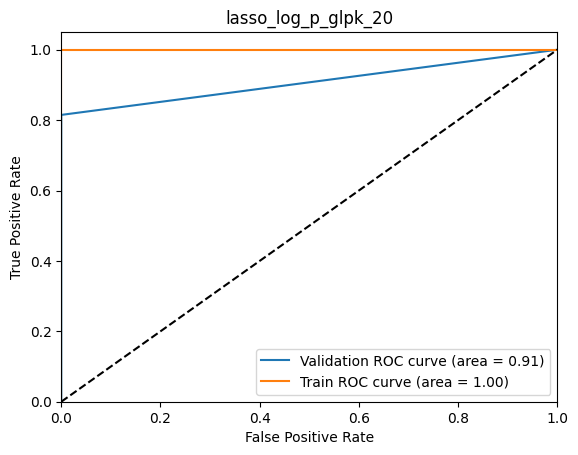

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  0.6296296296296297
MAE:  0.18518518518518517
RMSE:  0.6085806194501846
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.82915619758885), pvalue=np.float64(9.676761757799134e-15))
Accuracy:  0.9074074074074074
Train accuracy:  0.9764150943396226
              precision    recall  f1-score   support

           0       1.00      0.81      0.90        27
           2       0.84      1.00      0.92        27

    accuracy                           0.91        54
   macro avg       0.92      0.91      0.91        54
weighted avg       0.92      0.91      0.91        54



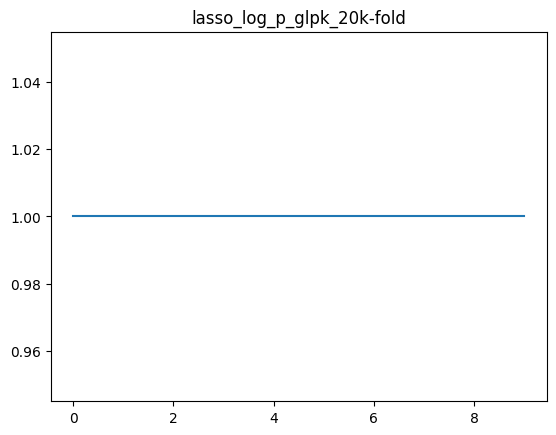

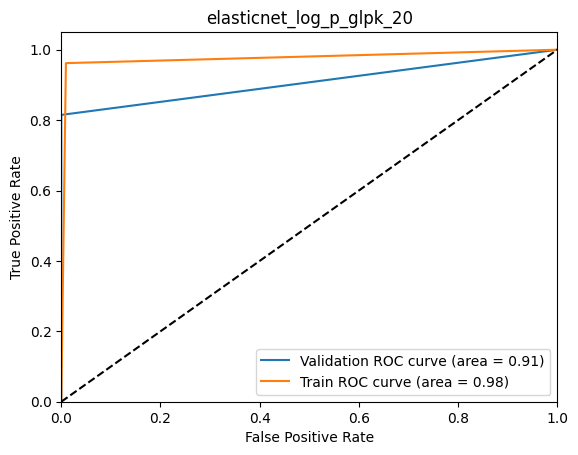

[np.float64(0.9736842105263158), np.float64(0.9789473684210527), np.float64(0.9738219895287958), np.float64(0.9685863874345549), np.float64(0.9738219895287958), np.float64(0.9738219895287958), np.float64(0.9685863874345549), np.float64(0.9790575916230366), np.float64(0.9738219895287958), np.float64(0.9790575916230366)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


R2 score:  0.11111111111111116
MAE:  0.4444444444444444
RMSE:  0.9428090415820634
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.581675050747111), pvalue=np.float64(3.972172277533988e-06))
Accuracy:  0.7777777777777778
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.89      0.63      0.74        27
           2       0.71      0.93      0.81        27

    accuracy                           0.78        54
   macro avg       0.80      0.78      0.77        54
weighted avg       0.80      0.78      0.77        54



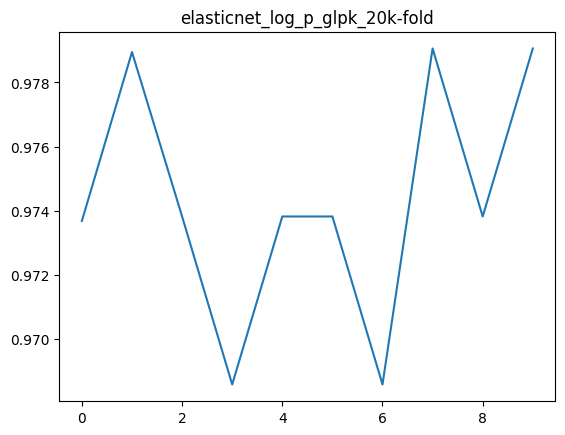

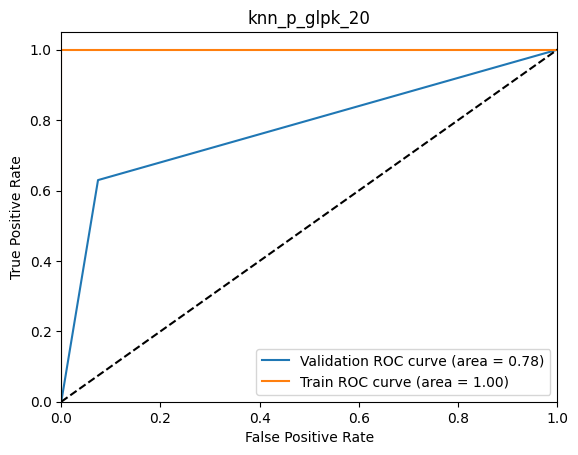

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R2 score:  0.7777777777777778
MAE:  0.1111111111111111
RMSE:  0.4714045207910317
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8944271909999159), pvalue=np.float64(8.224256606988106e-20))
Accuracy:  0.9444444444444444
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        27
           2       0.90      1.00      0.95        27

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.94        54
weighted avg       0.95      0.94      0.94        54



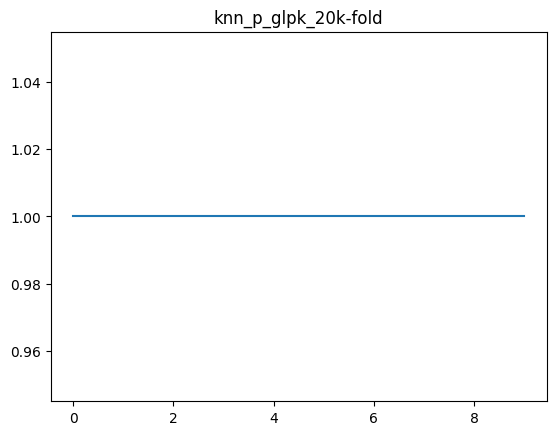

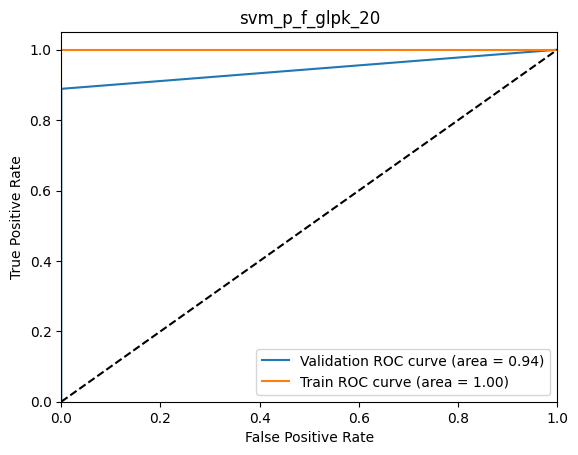

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

R2 score:  0.7777777777777778
MAE:  0.1111111111111111
RMSE:  0.4714045207910317
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8944271909999159), pvalue=np.float64(8.224256606988106e-20))
Accuracy:  0.9444444444444444
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        27
           2       0.90      1.00      0.95        27

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.94        54
weighted avg       0.95      0.94      0.94        54



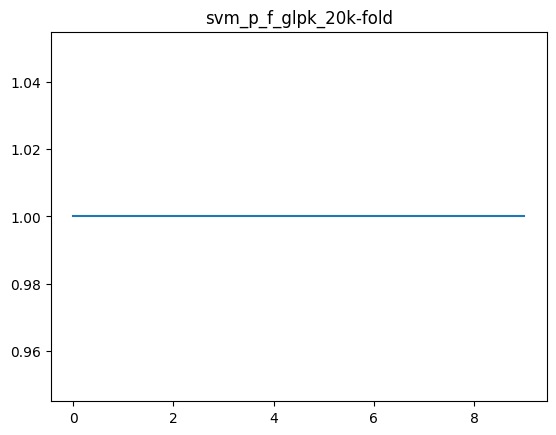

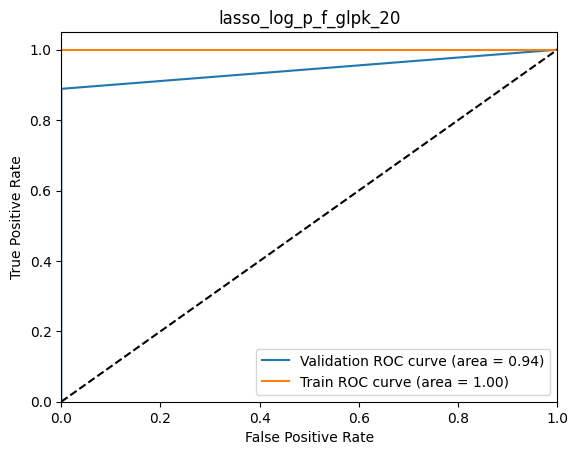

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  0.6296296296296297
MAE:  0.18518518518518517
RMSE:  0.6085806194501846
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.82915619758885), pvalue=np.float64(9.676761757799134e-15))
Accuracy:  0.9074074074074074
Train accuracy:  0.9575471698113207
              precision    recall  f1-score   support

           0       1.00      0.81      0.90        27
           2       0.84      1.00      0.92        27

    accuracy                           0.91        54
   macro avg       0.92      0.91      0.91        54
weighted avg       0.92      0.91      0.91        54



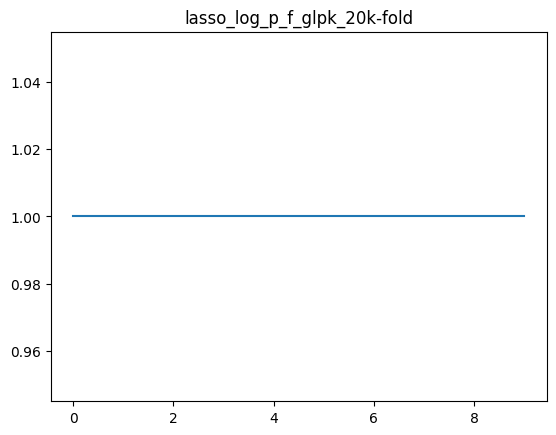

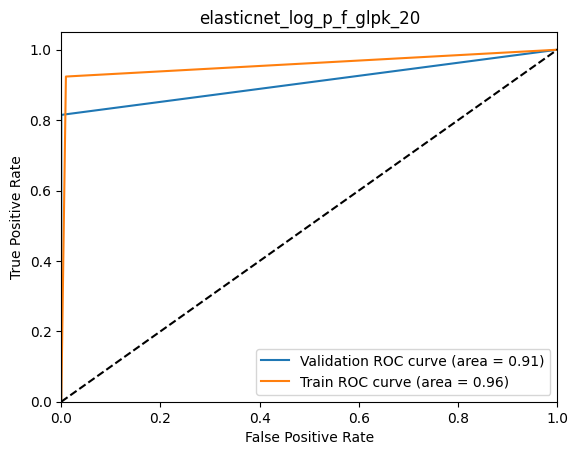

[np.float64(0.9578947368421052), np.float64(0.9631578947368421), np.float64(0.9685863874345549), np.float64(0.9581151832460733), np.float64(0.9738219895287958), np.float64(0.9581151832460733), np.float64(0.9633507853403142), np.float64(0.9633507853403142), np.float64(0.9581151832460733), np.float64(0.9685863874345549)]
R2 score:  -0.11111111111111116
MAE:  0.5555555555555556
RMSE:  1.0540925533894598
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5345224838248488), pvalue=np.float64(3.1355206505082396e-05))
Accuracy:  0.7222222222222222
Train accuracy:  0.7830188679245284
              precision    recall  f1-score   support

           0       1.00      0.44      0.62        27
           2       0.64      1.00      0.78        27

    accuracy                           0.72        54
   macro avg       0.82      0.72      0.70        54
weighted avg       0.82      0.72      0.70        54



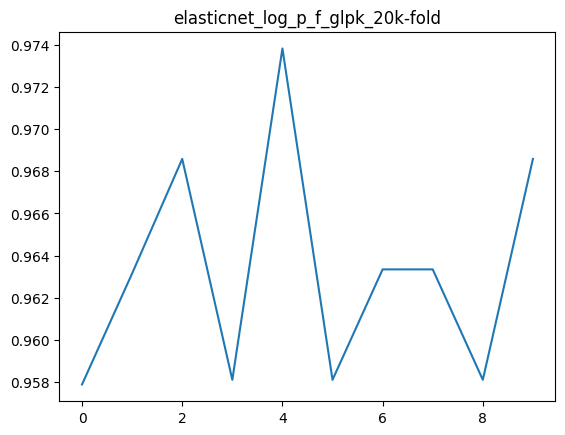

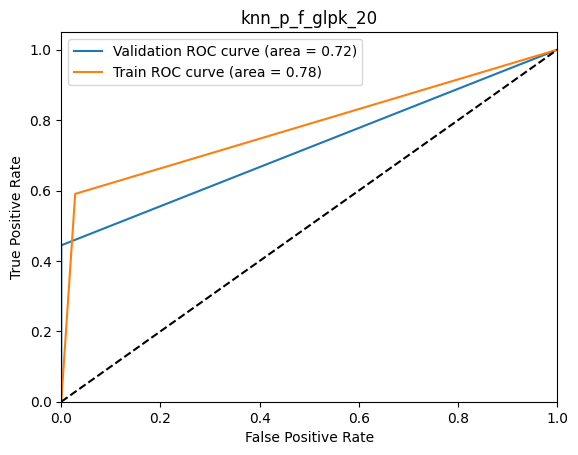

[np.float64(0.7736842105263158), np.float64(0.7789473684210526), np.float64(0.7905759162303665), np.float64(0.7853403141361257), np.float64(0.7539267015706806), np.float64(0.7801047120418848), np.float64(0.7958115183246073), np.float64(0.7801047120418848), np.float64(0.7958115183246073), np.float64(0.7905759162303665)]


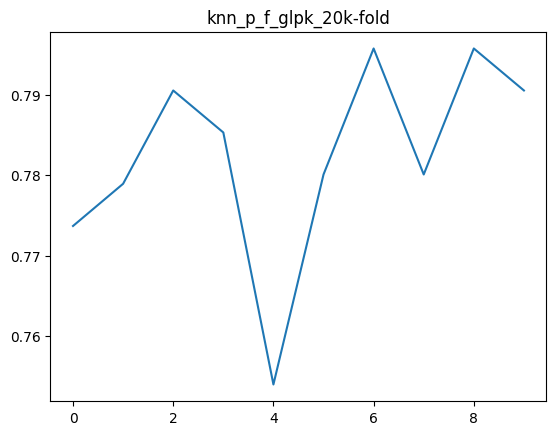

In [356]:
#load and preprocess data
[t, fluxes_t, p, fluxes_p, gr_measured_ML, y] = load_dataset()

percent = 20

#filter based on percentile
[gr_measured_ML, y] = filter_ko(gr_measured_ML, y, percent, 100 - percent)

#concatenate the dataframes
X = generate_combined_dataset(t, p, fluxes_t, fluxes_p)

#split transcriptomics dataset into train, test and validation
[y_train_liq, y_test_liq, y_valid_liq] = split_data(gr_measured_ML)
X_train_liq = X.loc[y_train_liq.index, :]
X_test_liq = X.loc[y_test_liq.index, :]
X_valid_liq = X.loc[y_valid_liq.index, :]

y_valid_liq = y_valid_liq['class']
y_train_liq = y_train_liq['class']
y_test_liq = y_test_liq['class']

#split proteomics dataset into train, test and validation
[y_train_solid, y_test_solid, y_valid_solid] = split_data(y)
X_train_solid = X.loc[y_train_solid.index, :]
X_test_solid = X.loc[y_test_solid.index, :]
X_valid_solid = X.loc[y_valid_solid.index, :]

y_train_solid = y_train_solid['class']
y_test_solid = y_test_solid['class']
y_valid_solid = y_valid_solid['class']

#subset train and validation for transcriptomics
x_train = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
x_valid = X_valid_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]


temp = SVM_model(x_train, x_valid, y_train_liq, y_valid_liq, 'svm_t_glpk_'+str(percent), temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_liq, y_valid_liq, 'lasso_log_t_glpk_'+str(percent), temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_liq, y_valid_liq, 'elasticnet_log_t_glpk_'+str(percent), temp)
temp = kNN_model(x_train, x_valid, y_train_liq, y_valid_liq, 'knn_t_glpk_'+str(percent), temp)



transcriptome = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
flux = X_train_liq.iloc[:, 1826: 3776]
x_train = pd.concat([transcriptome, flux], axis=1)
x_valid = X_valid_liq.iloc[:, 0:3776].loc[:, x_train.columns]

temp = SVM_model(x_train, x_valid, y_train_liq, y_valid_liq, 'svm_t_f_glpk_'+str(percent), temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_liq, y_valid_liq, 'lasso_log_t_f_glpk_'+str(percent), temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_liq, y_valid_liq, 'elasticnet_log_t_f_glpk_'+str(percent), temp)
temp = kNN_model(x_train, x_valid, y_train_liq, y_valid_liq, 'knn_t_f_glpk_'+str(percent), temp)

x_train = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
x_valid = X_valid_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
x_train.dropna(inplace=True)
x_valid.dropna(inplace=True)

temp = SVM_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'svm_p_glpk_'+str(percent), temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'lasso_log_p_glpk_'+str(percent), temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'elasticnet_log_p_glpk_'+str(percent), temp)
temp = kNN_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'knn_p_glpk_'+str(percent), temp)


proteome = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
flux = X_train_solid.iloc[:, 5602: ]
x_train = pd.concat([proteome, flux], axis=1)
x_valid = X_valid_solid.iloc[:, 3776:].loc[:, x_train.columns]
x_train.dropna(inplace=True)
x_valid.dropna(inplace=True)

temp = SVM_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'svm_p_f_glpk_'+str(percent), temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'lasso_log_p_f_glpk_'+str(percent), temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'elasticnet_log_p_f_glpk_'+str(percent), temp)
temp = kNN_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'knn_p_f_glpk_'+str(percent), temp)

40-60th percentile split

/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_46332/3380375233.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_train = y.groupby('class', group_keys=False).apply(lambda x: x.sample(n=train_size//2, random_state=42))
/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_46332/3380375233.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_valid = train_valid.groupby('class', group_

R2 score:  0.2727272727272727
MAE:  0.36363636363636365
RMSE:  0.8528028654224418
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6520732960932837), pvalue=np.float64(1.1985690650583766e-14))
Accuracy:  0.8181818181818182
Train accuracy:  0.9932432432432432
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        55
           2       0.91      0.71      0.80        55

    accuracy                           0.82       110
   macro avg       0.83      0.82      0.82       110
weighted avg       0.83      0.82      0.82       110



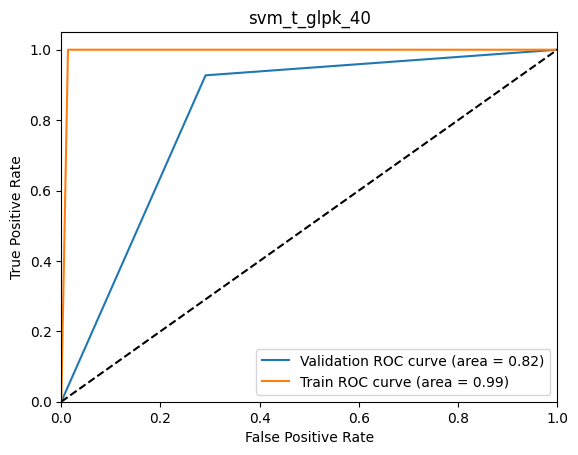

[np.float64(0.8546365914786967), np.float64(0.8721804511278195), np.float64(0.8571428571428571), np.float64(0.8671679197994987), np.float64(0.855), np.float64(0.8675), np.float64(0.845), np.float64(0.8475), np.float64(0.855), np.float64(0.8625)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

R2 score:  0.1636363636363637
MAE:  0.41818181818181815
RMSE:  0.9145291883606758
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6047431568147636), pvalue=np.float64(2.6268595236002784e-12))
Accuracy:  0.7909090909090909
Train accuracy:  0.8693693693693694
              precision    recall  f1-score   support

           0       0.73      0.93      0.82        55
           2       0.90      0.65      0.76        55

    accuracy                           0.79       110
   macro avg       0.81      0.79      0.79       110
weighted avg       0.81      0.79      0.79       110



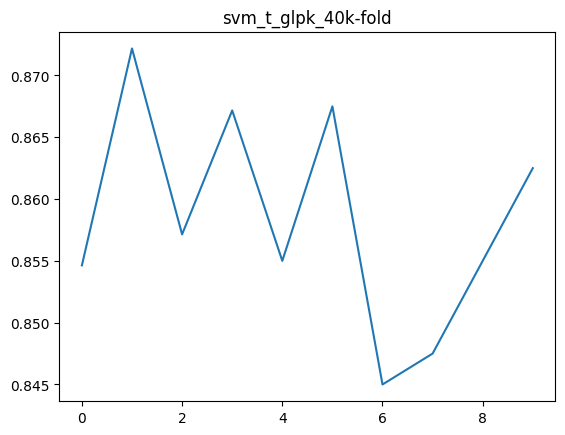

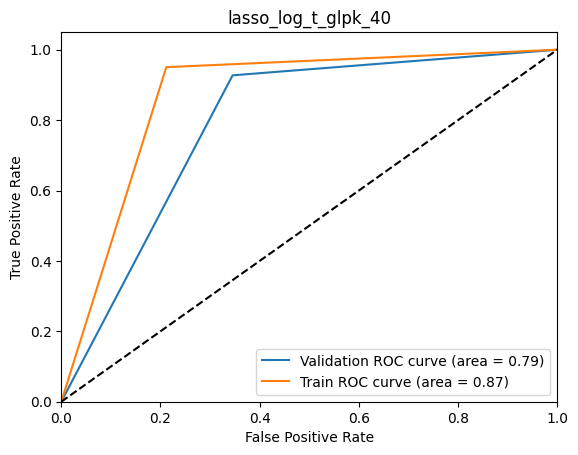

[np.float64(0.8847117794486216), np.float64(0.8847117794486216), np.float64(0.8596491228070176), np.float64(0.8721804511278195), np.float64(0.8625), np.float64(0.88), np.float64(0.86), np.float64(0.87), np.float64(0.8725), np.float64(0.8675)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  0.3090909090909091
MAE:  0.34545454545454546
RMSE:  0.8312094145936335
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6736330697086077), pvalue=np.float64(7.395261234630354e-16))
Accuracy:  0.8272727272727273
Train accuracy:  0.8806306306306306
              precision    recall  f1-score   support

           0       0.76      0.95      0.85        55
           2       0.93      0.71      0.80        55

    accuracy                           0.83       110
   macro avg       0.85      0.83      0.82       110
weighted avg       0.85      0.83      0.82       110



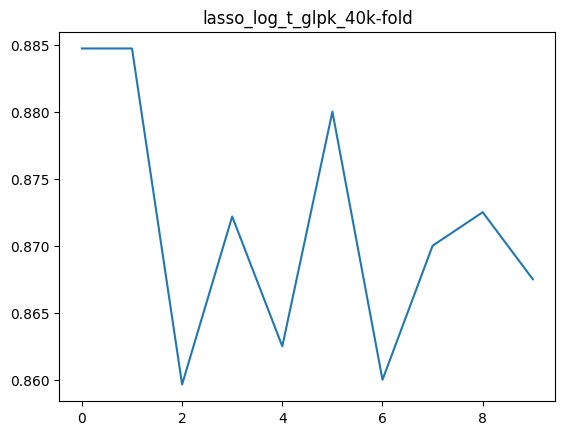

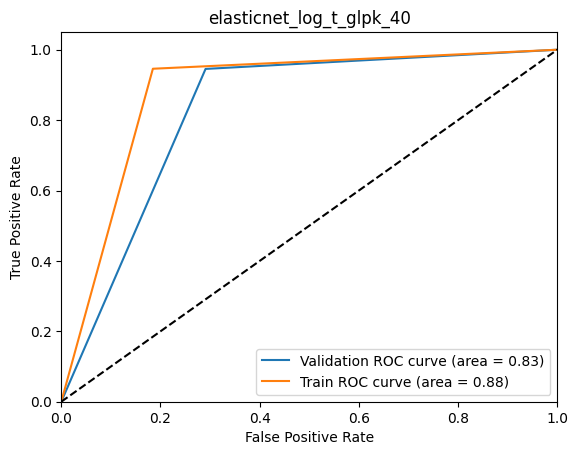

[np.float64(0.899749373433584), np.float64(0.8972431077694235), np.float64(0.8897243107769424), np.float64(0.8796992481203008), np.float64(0.89), np.float64(0.895), np.float64(0.8875), np.float64(0.8775), np.float64(0.885), np.float64(0.885)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


R2 score:  -0.49090909090909096
MAE:  0.7454545454545455
RMSE:  1.2210278829367867
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.25979436665882194), pvalue=np.float64(0.006128079215980962))
Accuracy:  0.6272727272727273
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.61      0.73      0.66        55
           2       0.66      0.53      0.59        55

    accuracy                           0.63       110
   macro avg       0.63      0.63      0.62       110
weighted avg       0.63      0.63      0.62       110



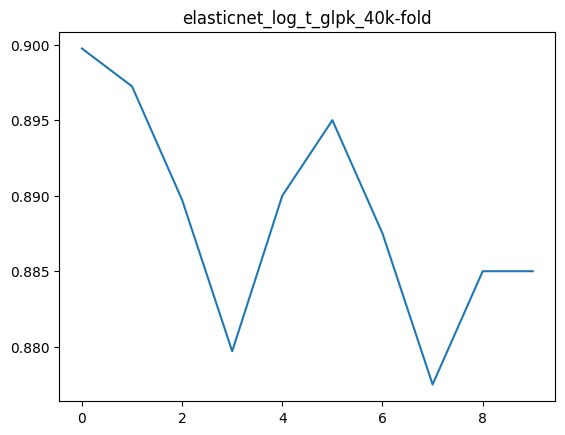

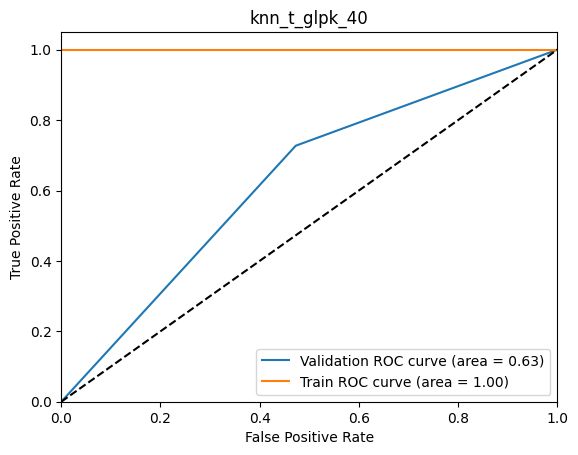

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R2 score:  0.2727272727272727
MAE:  0.36363636363636365
RMSE:  0.8528028654224418
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6520732960932837), pvalue=np.float64(1.1985690650583766e-14))
Accuracy:  0.8181818181818182
Train accuracy:  0.9842342342342343
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        55
           2       0.91      0.71      0.80        55

    accuracy                           0.82       110
   macro avg       0.83      0.82      0.82       110
weighted avg       0.83      0.82      0.82       110



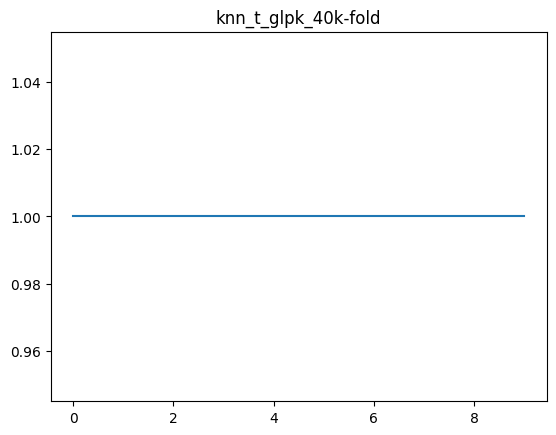

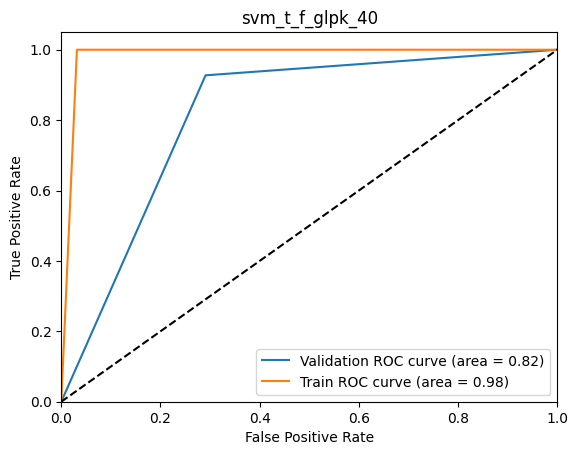

[np.float64(0.8696741854636592), np.float64(0.8771929824561403), np.float64(0.8696741854636592), np.float64(0.8696741854636592), np.float64(0.865), np.float64(0.875), np.float64(0.8625), np.float64(0.8575), np.float64(0.8625), np.float64(0.865)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

R2 score:  0.23636363636363633
MAE:  0.38181818181818183
RMSE:  0.873862897505303
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6362090102803518), pvalue=np.float64(8.096449588920993e-14))
Accuracy:  0.8090909090909091
Train accuracy:  0.8716216216216216
              precision    recall  f1-score   support

           0       0.75      0.93      0.83        55
           2       0.90      0.69      0.78        55

    accuracy                           0.81       110
   macro avg       0.83      0.81      0.81       110
weighted avg       0.83      0.81      0.81       110



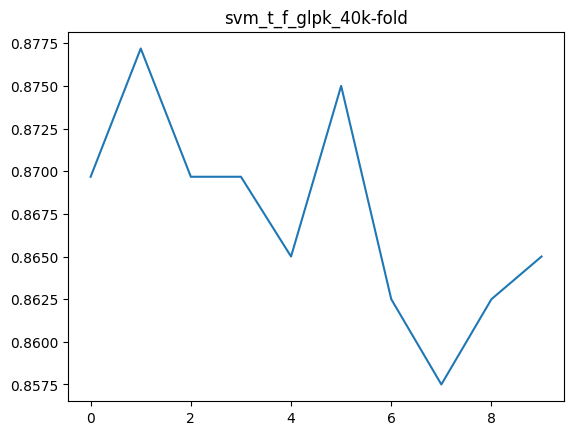

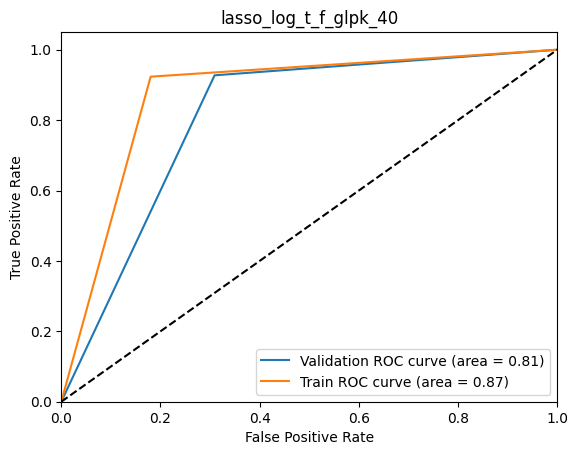

[np.float64(0.8621553884711779), np.float64(0.8771929824561403), np.float64(0.8822055137844611), np.float64(0.8822055137844611), np.float64(0.8675), np.float64(0.88), np.float64(0.8675), np.float64(0.8675), np.float64(0.865), np.float64(0.87)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  0.2727272727272727
MAE:  0.36363636363636365
RMSE:  0.8528028654224418
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6580389044100772), pvalue=np.float64(5.672843992938423e-15))
Accuracy:  0.8181818181818182
Train accuracy:  0.8603603603603603
              precision    recall  f1-score   support

           0       0.75      0.95      0.84        55
           2       0.93      0.69      0.79        55

    accuracy                           0.82       110
   macro avg       0.84      0.82      0.82       110
weighted avg       0.84      0.82      0.82       110



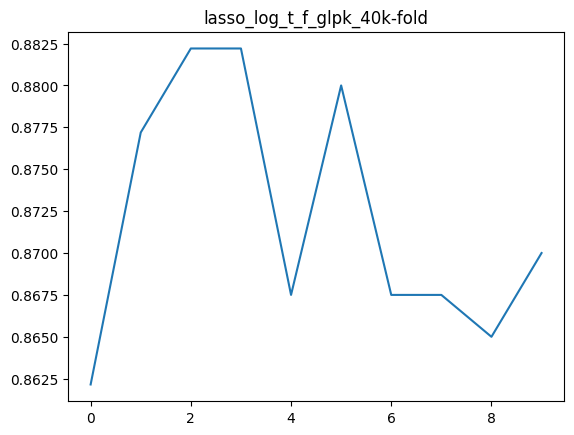

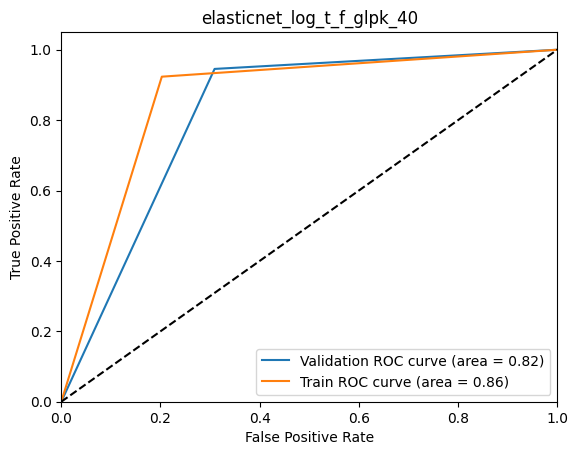

[np.float64(0.8395989974937343), np.float64(0.8596491228070176), np.float64(0.8596491228070176), np.float64(0.8571428571428571), np.float64(0.8625), np.float64(0.86), np.float64(0.85), np.float64(0.85), np.float64(0.855), np.float64(0.865)]
R2 score:  -0.16363636363636358
MAE:  0.5818181818181818
RMSE:  1.0787197799411874
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.43242556575519353), pvalue=np.float64(2.386059675719922e-06))
Accuracy:  0.7090909090909091
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.67      0.84      0.74        55
           2       0.78      0.58      0.67        55

    accuracy                           0.71       110
   macro avg       0.72      0.71      0.70       110
weighted avg       0.72      0.71      0.70       110



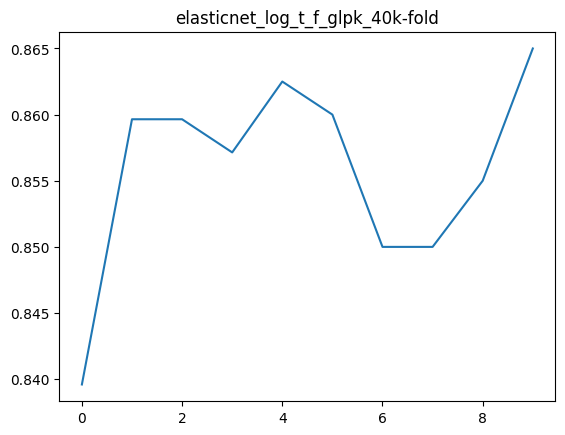

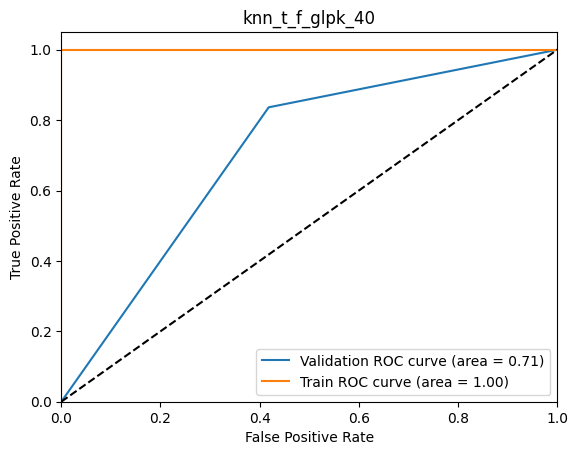

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R2 score:  0.4444444444444444
MAE:  0.2777777777777778
RMSE:  0.7453559924999299
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.728367837710324), pvalue=np.float64(4.1509036759700594e-19))
Accuracy:  0.8611111111111112
Train accuracy:  0.9422632794457275
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        54
           2       0.82      0.93      0.87        54

    accuracy                           0.86       108
   macro avg       0.87      0.86      0.86       108
weighted avg       0.87      0.86      0.86       108



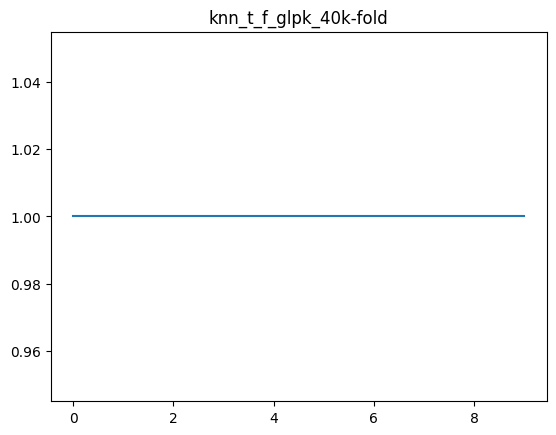

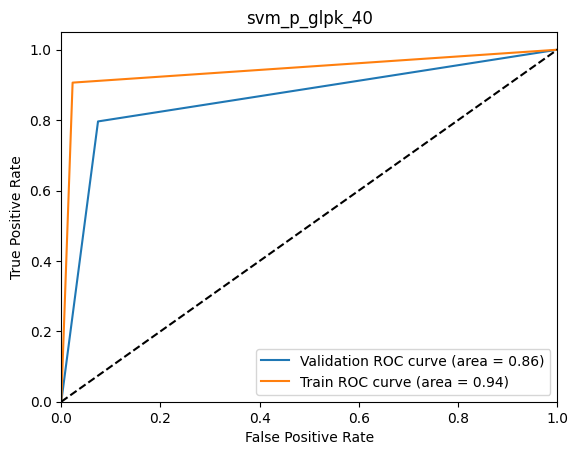

[np.float64(0.974293059125964), np.float64(0.9768637532133676), np.float64(0.9640102827763496), np.float64(0.9641025641025641), np.float64(0.9666666666666667), np.float64(0.9641025641025641), np.float64(0.9692307692307692), np.float64(0.9717948717948718), np.float64(0.958974358974359), np.float64(0.9641025641025641)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

R2 score:  0.37037037037037035
MAE:  0.3148148148148148
RMSE:  0.7934920476158722
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6949046094434471), pvalue=np.float64(7.276447308938262e-17))
Accuracy:  0.8425925925925926
Train accuracy:  0.9561200923787528
              precision    recall  f1-score   support

           0       0.91      0.76      0.83        54
           2       0.79      0.93      0.85        54

    accuracy                           0.84       108
   macro avg       0.85      0.84      0.84       108
weighted avg       0.85      0.84      0.84       108



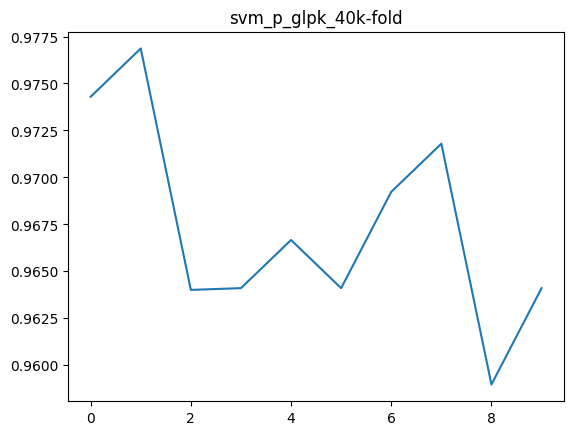

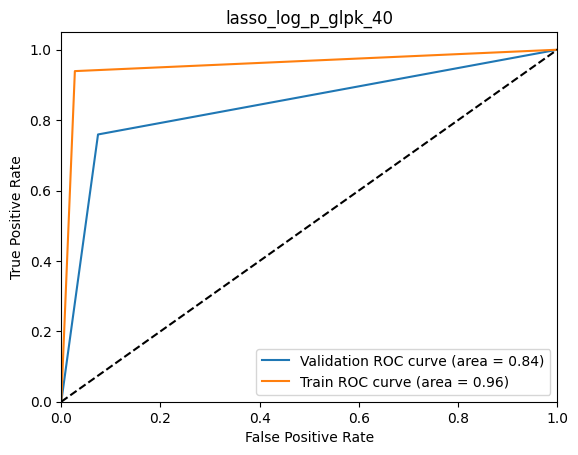

[np.float64(0.961439588688946), np.float64(0.9588688946015425), np.float64(0.9485861182519281), np.float64(0.9435897435897436), np.float64(0.9615384615384616), np.float64(0.9512820512820512), np.float64(0.9564102564102565), np.float64(0.9615384615384616), np.float64(0.9512820512820512), np.float64(0.9538461538461539)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  0.5185185185185186
MAE:  0.24074074074074073
RMSE:  0.693888666488711
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7657200345159815), pvalue=np.float64(4.833041313421717e-22))
Accuracy:  0.8796296296296297
Train accuracy:  0.9792147806004619
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        54
           2       0.84      0.94      0.89        54

    accuracy                           0.88       108
   macro avg       0.89      0.88      0.88       108
weighted avg       0.89      0.88      0.88       108



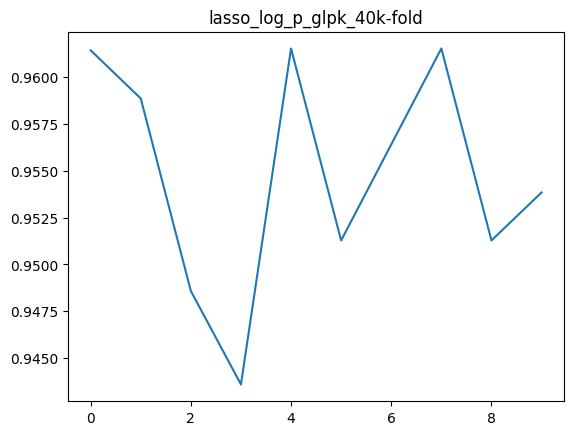

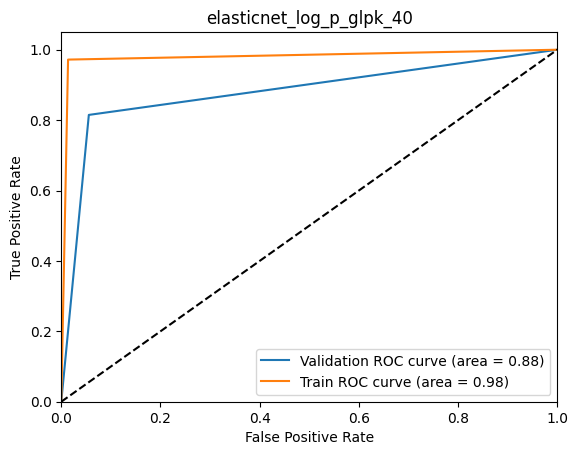

[np.float64(0.9820051413881749), np.float64(0.9794344473007712), np.float64(0.974293059125964), np.float64(0.9769230769230769), np.float64(0.9794871794871794), np.float64(0.9794871794871794), np.float64(0.9846153846153847), np.float64(0.982051282051282), np.float64(0.9794871794871794), np.float64(0.9769230769230769)]
R2 score:  0.07407407407407407
MAE:  0.46296296296296297
RMSE:  0.9622504486493763
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5446549641583774), pvalue=np.float64(1.104569833506976e-09))
Accuracy:  0.7685185185185185
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.82      0.69      0.75        54
           2       0.73      0.85      0.79        54

    accuracy                           0.77       108
   macro avg       0.78      0.77      0.77       108
weighted avg       0.78      0.77      0.77       108



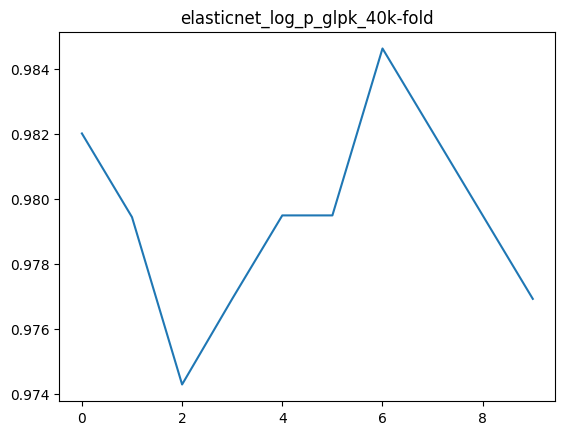

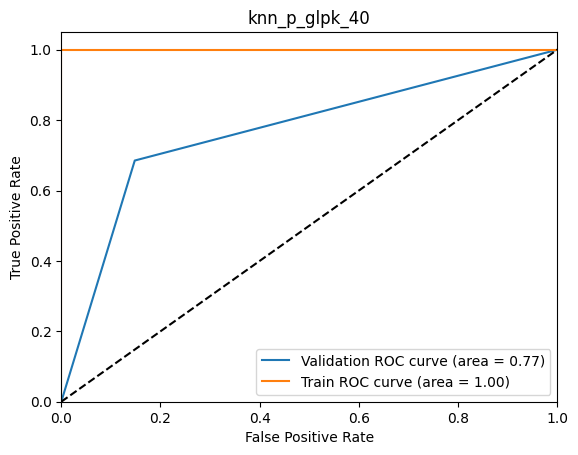

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R2 score:  0.33333333333333337
MAE:  0.3333333333333333
RMSE:  0.816496580927726
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6708203932499369), pvalue=np.float64(1.9773954397124576e-15))
Accuracy:  0.8333333333333334
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.88      0.78      0.82        54
           2       0.80      0.89      0.84        54

    accuracy                           0.83       108
   macro avg       0.84      0.83      0.83       108
weighted avg       0.84      0.83      0.83       108



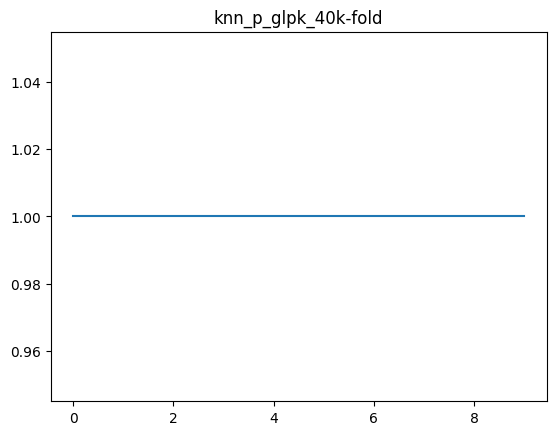

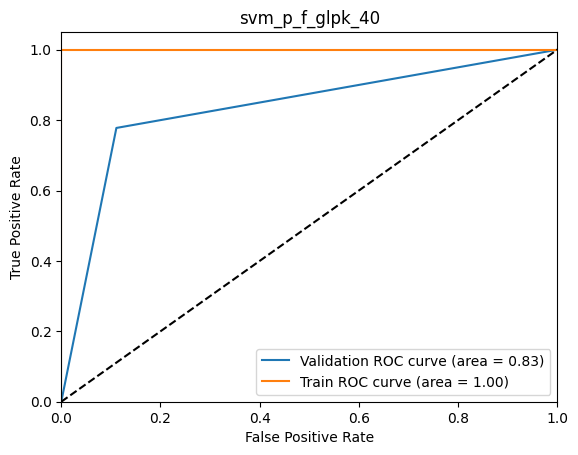

[np.float64(0.9922879177377892), np.float64(0.9897172236503856), np.float64(0.9922879177377892), np.float64(0.9846153846153847), np.float64(0.9846153846153847), np.float64(0.9871794871794872), np.float64(0.9897435897435898), np.float64(0.9794871794871794), np.float64(0.9846153846153847), np.float64(0.982051282051282)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

R2 score:  0.5185185185185186
MAE:  0.24074074074074073
RMSE:  0.693888666488711
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7700294320859818), pvalue=np.float64(2.0447120573450223e-22))
Accuracy:  0.8796296296296297
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.96      0.80      0.87        54
           2       0.83      0.96      0.89        54

    accuracy                           0.88       108
   macro avg       0.89      0.88      0.88       108
weighted avg       0.89      0.88      0.88       108



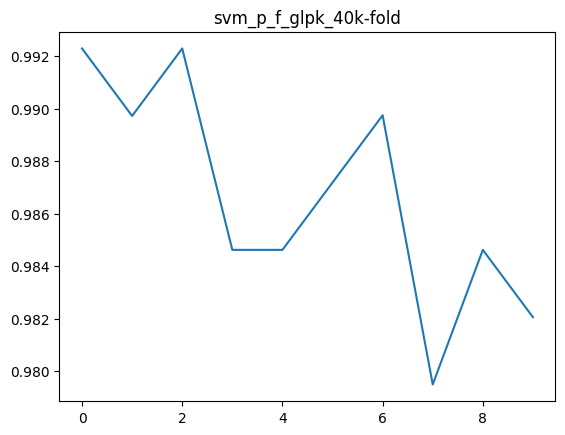

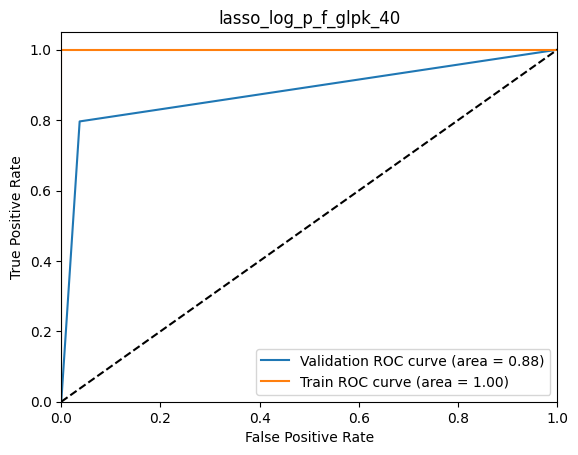

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  0.40740740740740744
MAE:  0.2962962962962963
RMSE:  0.769800358919501
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7080881928749334), pvalue=np.float64(1.0366838994003442e-17))
Accuracy:  0.8518518518518519
Train accuracy:  0.9376443418013857
              precision    recall  f1-score   support

           0       0.90      0.80      0.84        54
           2       0.82      0.91      0.86        54

    accuracy                           0.85       108
   macro avg       0.86      0.85      0.85       108
weighted avg       0.86      0.85      0.85       108



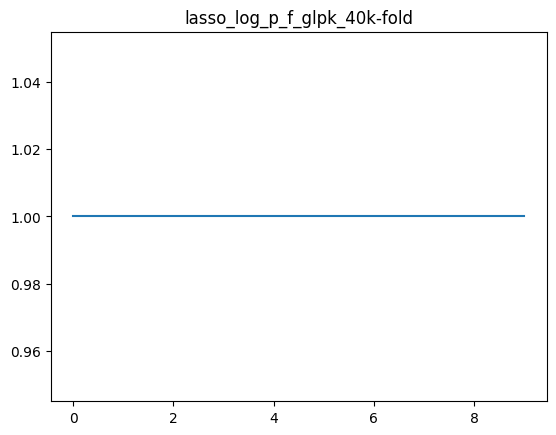

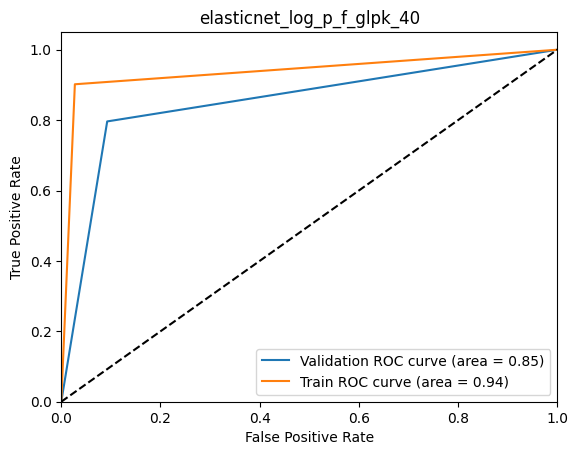

[np.float64(0.9460154241645244), np.float64(0.9460154241645244), np.float64(0.9331619537275064), np.float64(0.9487179487179487), np.float64(0.9333333333333333), np.float64(0.9358974358974359), np.float64(0.9461538461538461), np.float64(0.9461538461538461), np.float64(0.941025641025641), np.float64(0.9333333333333333)]
R2 score:  -0.07407407407407418
MAE:  0.5370370370370371
RMSE:  1.0363754503432017
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.4945891176555817), pvalue=np.float64(5.311157031153169e-08))
Accuracy:  0.7314814814814815
Train accuracy:  0.7598152424942263
              precision    recall  f1-score   support

           0       0.86      0.56      0.67        54
           2       0.67      0.91      0.77        54

    accuracy                           0.73       108
   macro avg       0.76      0.73      0.72       108
weighted avg       0.76      0.73      0.72       108



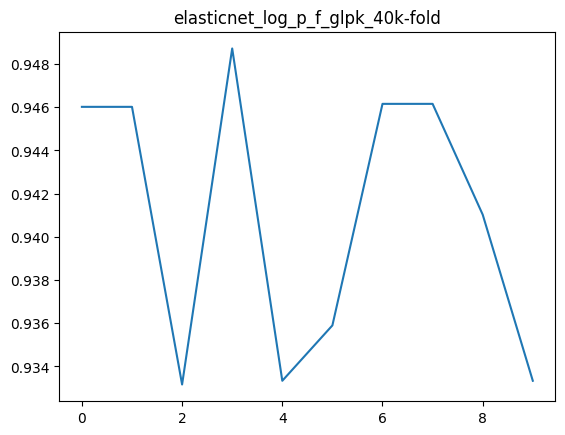

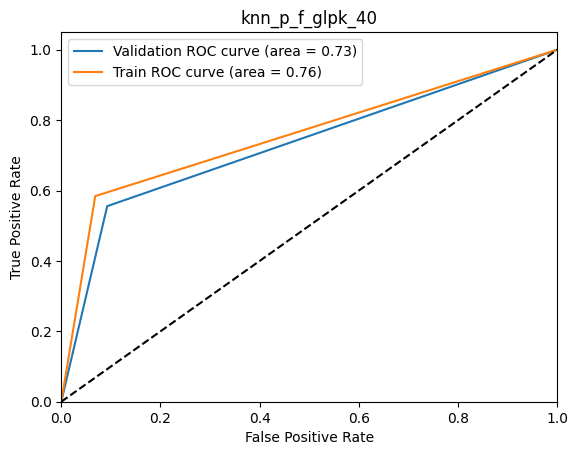

[np.float64(0.7763496143958869), np.float64(0.7789203084832905), np.float64(0.7634961439588689), np.float64(0.7512820512820513), np.float64(0.7615384615384615), np.float64(0.7461538461538462), np.float64(0.7512820512820513), np.float64(0.7692307692307693), np.float64(0.7461538461538462), np.float64(0.7564102564102564)]


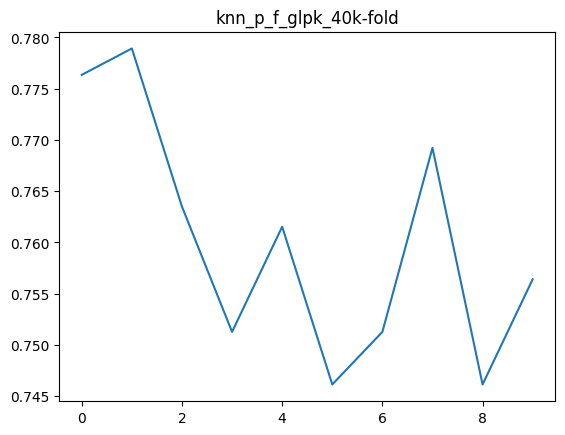

In [357]:
#load and preprocess data
[t, fluxes_t, p, fluxes_p, gr_measured_ML, y] = load_dataset()

percent = 40

#filter based on percentile
[gr_measured_ML, y] = filter_ko(gr_measured_ML, y, percent, 100 - percent)

#concatenate the dataframes
X = generate_combined_dataset(t, p, fluxes_t, fluxes_p)

#split transcriptomics dataset into train, test and validation
[y_train_liq, y_test_liq, y_valid_liq] = split_data(gr_measured_ML)
X_train_liq = X.loc[y_train_liq.index, :]
X_test_liq = X.loc[y_test_liq.index, :]
X_valid_liq = X.loc[y_valid_liq.index, :]

y_valid_liq = y_valid_liq['class']
y_train_liq = y_train_liq['class']
y_test_liq = y_test_liq['class']

#split proteomics dataset into train, test and validation
[y_train_solid, y_test_solid, y_valid_solid] = split_data(y)
X_train_solid = X.loc[y_train_solid.index, :]
X_test_solid = X.loc[y_test_solid.index, :]
X_valid_solid = X.loc[y_valid_solid.index, :]

y_train_solid = y_train_solid['class']
y_test_solid = y_test_solid['class']
y_valid_solid = y_valid_solid['class']

#subset train and validation for transcriptomics
x_train = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
x_valid = X_valid_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]


temp = SVM_model(x_train, x_valid, y_train_liq, y_valid_liq, 'svm_t_glpk_'+str(percent), temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_liq, y_valid_liq, 'lasso_log_t_glpk_'+str(percent), temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_liq, y_valid_liq, 'elasticnet_log_t_glpk_'+str(percent), temp)
temp = kNN_model(x_train, x_valid, y_train_liq, y_valid_liq, 'knn_t_glpk_'+str(percent), temp)



transcriptome = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
flux = X_train_liq.iloc[:, 1826: 3776]
x_train = pd.concat([transcriptome, flux], axis=1)
x_valid = X_valid_liq.iloc[:, 0:3776].loc[:, x_train.columns]

temp = SVM_model(x_train, x_valid, y_train_liq, y_valid_liq, 'svm_t_f_glpk_'+str(percent), temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_liq, y_valid_liq, 'lasso_log_t_f_glpk_'+str(percent), temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_liq, y_valid_liq, 'elasticnet_log_t_f_glpk_'+str(percent), temp)
temp = kNN_model(x_train, x_valid, y_train_liq, y_valid_liq, 'knn_t_f_glpk_'+str(percent), temp)

x_train = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
x_valid = X_valid_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
x_train.dropna(inplace=True)
x_valid.dropna(inplace=True)

temp = SVM_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'svm_p_glpk_'+str(percent), temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'lasso_log_p_glpk_'+str(percent), temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'elasticnet_log_p_glpk_'+str(percent), temp)
temp = kNN_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'knn_p_glpk_'+str(percent), temp)


proteome = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
flux = X_train_solid.iloc[:, 5602: ]
x_train = pd.concat([proteome, flux], axis=1)
x_valid = X_valid_solid.iloc[:, 3776:].loc[:, x_train.columns]
x_train.dropna(inplace=True)
x_valid.dropna(inplace=True)

temp = SVM_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'svm_p_f_glpk_'+str(percent), temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'lasso_log_p_f_glpk_'+str(percent), temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'elasticnet_log_p_f_glpk_'+str(percent), temp)
temp = kNN_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'knn_p_f_glpk_'+str(percent), temp)

50-50th percentile split

/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_46332/3380375233.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_train = y.groupby('class', group_keys=False).apply(lambda x: x.sample(n=train_size//2, random_state=42))
/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_46332/3380375233.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_valid = train_valid.groupby('class', group_

R2 score:  -0.07246376811594213
MAE:  0.5362318840579711
RMSE:  1.035598265794194
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.47222506888076415), pvalue=np.float64(4.996079081930431e-09))
Accuracy:  0.7318840579710145
Train accuracy:  0.944043321299639
              precision    recall  f1-score   support

           0       0.70      0.83      0.75        69
           2       0.79      0.64      0.70        69

    accuracy                           0.73       138
   macro avg       0.74      0.73      0.73       138
weighted avg       0.74      0.73      0.73       138



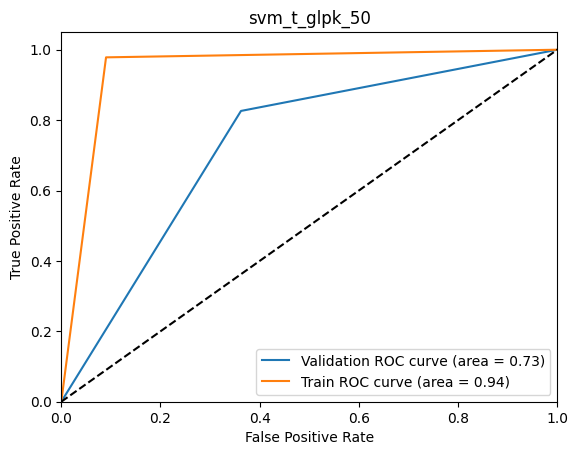

[np.float64(0.8253012048192772), np.float64(0.8313253012048193), np.float64(0.8253012048192772), np.float64(0.821285140562249), np.float64(0.8216432865731463), np.float64(0.8316633266533067), np.float64(0.8376753507014028), np.float64(0.8276553106212425), np.float64(0.8376753507014028), np.float64(0.8316633266533067)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

R2 score:  -0.04347826086956519
MAE:  0.5217391304347826
RMSE:  1.0215078369104984
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.48566186425718266), pvalue=np.float64(1.5625917515859948e-09))
Accuracy:  0.7391304347826086
Train accuracy:  0.9404332129963899
              precision    recall  f1-score   support

           0       0.70      0.83      0.76        69
           2       0.79      0.65      0.71        69

    accuracy                           0.74       138
   macro avg       0.75      0.74      0.74       138
weighted avg       0.75      0.74      0.74       138



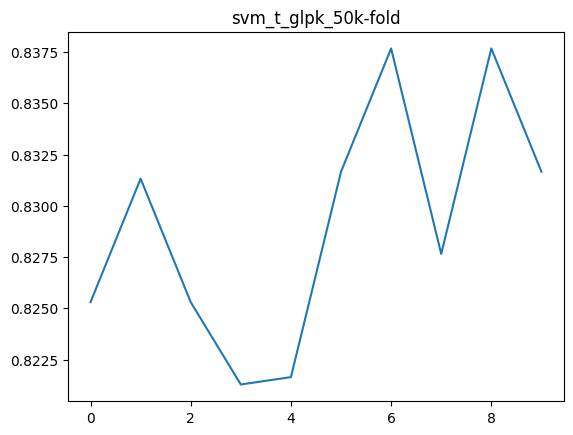

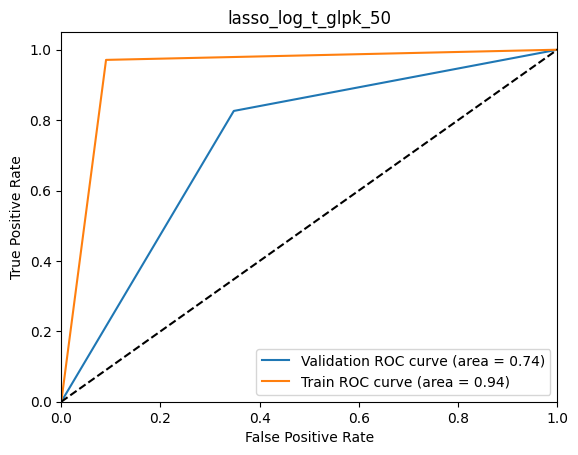

[np.float64(0.9357429718875502), np.float64(0.9457831325301205), np.float64(0.9417670682730924), np.float64(0.9377510040160643), np.float64(0.935871743486974), np.float64(0.9318637274549099), np.float64(0.9378757515030061), np.float64(0.9338677354709419), np.float64(0.9258517034068137), np.float64(0.935871743486974)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  -0.04347826086956519
MAE:  0.5217391304347826
RMSE:  1.0215078369104984
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.48842012332362983), pvalue=np.float64(1.2232092093401094e-09))
Accuracy:  0.7391304347826086
Train accuracy:  0.8537906137184116
              precision    recall  f1-score   support

           0       0.70      0.84      0.76        69
           2       0.80      0.64      0.71        69

    accuracy                           0.74       138
   macro avg       0.75      0.74      0.74       138
weighted avg       0.75      0.74      0.74       138



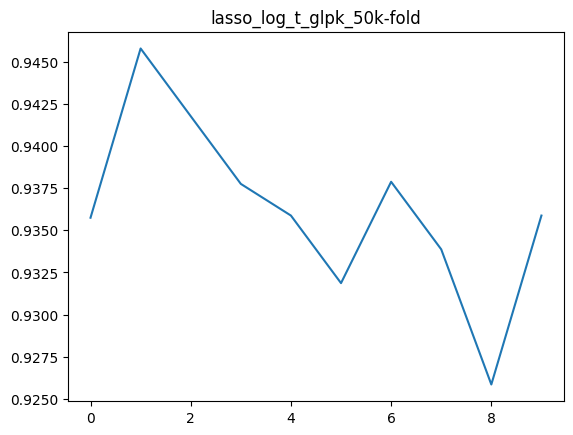

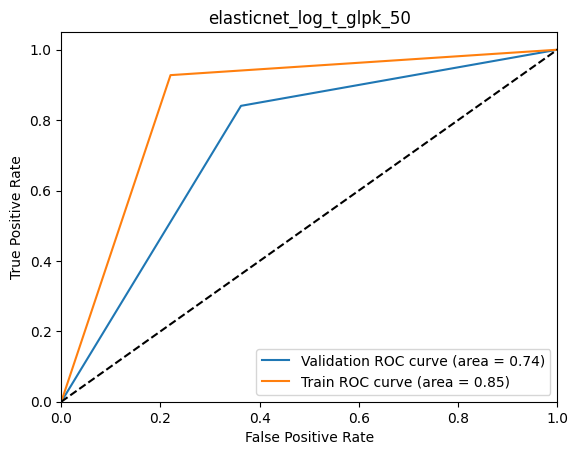

[np.float64(0.8514056224899599), np.float64(0.8534136546184738), np.float64(0.8614457831325302), np.float64(0.8554216867469879), np.float64(0.8557114228456913), np.float64(0.8537074148296593), np.float64(0.8416833667334669), np.float64(0.843687374749499), np.float64(0.8537074148296593), np.float64(0.8517034068136272)]
R2 score:  -0.5072463768115942
MAE:  0.7536231884057971
RMSE:  1.2276996280897026
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.2780912808828736), pvalue=np.float64(0.0009582346722447762))
Accuracy:  0.6231884057971014
Train accuracy:  0.7563176895306859
              precision    recall  f1-score   support

           0       0.58      0.86      0.69        69
           2       0.73      0.39      0.51        69

    accuracy                           0.62       138
   macro avg       0.66      0.62      0.60       138
weighted avg       0.66      0.62      0.60       138



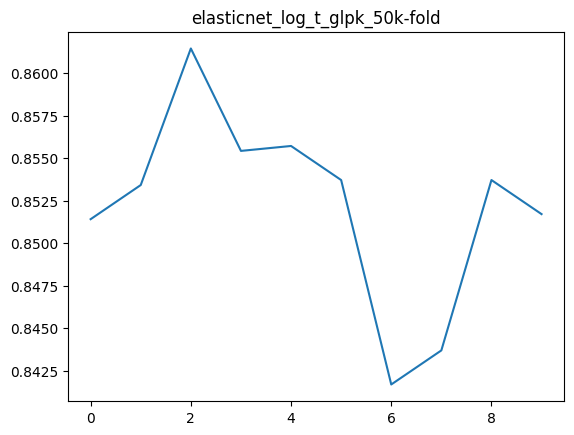

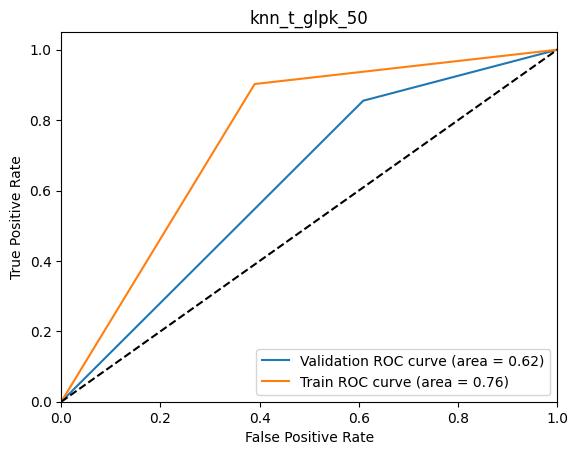

[np.float64(0.7530120481927711), np.float64(0.7469879518072289), np.float64(0.7690763052208835), np.float64(0.7590361445783133), np.float64(0.7755511022044088), np.float64(0.7414829659318637), np.float64(0.7595190380761523), np.float64(0.7655310621242485), np.float64(0.7635270541082164), np.float64(0.7414829659318637)]
R2 score:  -0.01449275362318847
MAE:  0.5072463768115942
RMSE:  1.0072203103706698
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5286748515354543), pvalue=np.float64(2.646327915366707e-11))
Accuracy:  0.7463768115942029
Train accuracy:  0.8194945848375451
              precision    recall  f1-score   support

           0       0.68      0.93      0.79        69
           2       0.89      0.57      0.69        69

    accuracy                           0.75       138
   macro avg       0.78      0.75      0.74       138
weighted avg       0.78      0.75      0.74       138



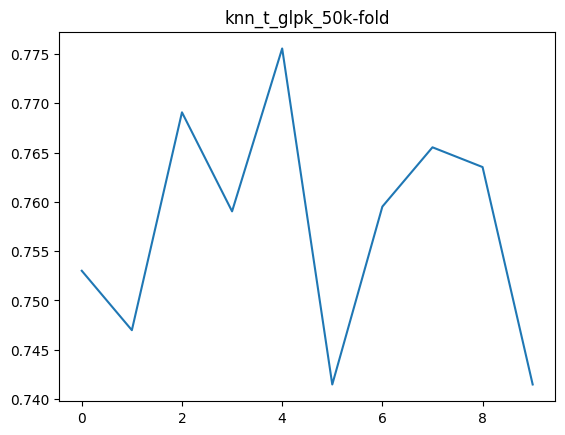

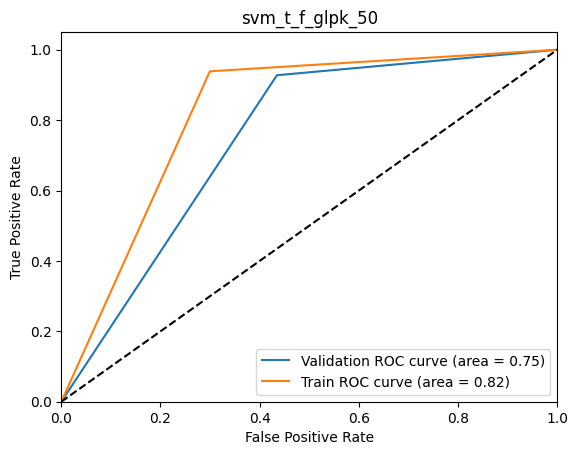

[np.float64(0.8534136546184738), np.float64(0.8473895582329317), np.float64(0.8473895582329317), np.float64(0.8554216867469879), np.float64(0.8537074148296593), np.float64(0.8476953907815631), np.float64(0.8517034068136272), np.float64(0.8557114228456913), np.float64(0.8496993987975952), np.float64(0.843687374749499)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

R2 score:  -0.07246376811594213
MAE:  0.5362318840579711
RMSE:  1.035598265794194
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.47222506888076415), pvalue=np.float64(4.996079081930431e-09))
Accuracy:  0.7318840579710145
Train accuracy:  0.9458483754512635
              precision    recall  f1-score   support

           0       0.70      0.83      0.75        69
           2       0.79      0.64      0.70        69

    accuracy                           0.73       138
   macro avg       0.74      0.73      0.73       138
weighted avg       0.74      0.73      0.73       138



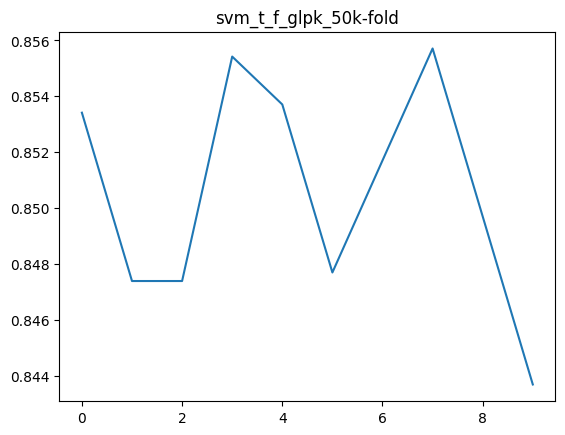

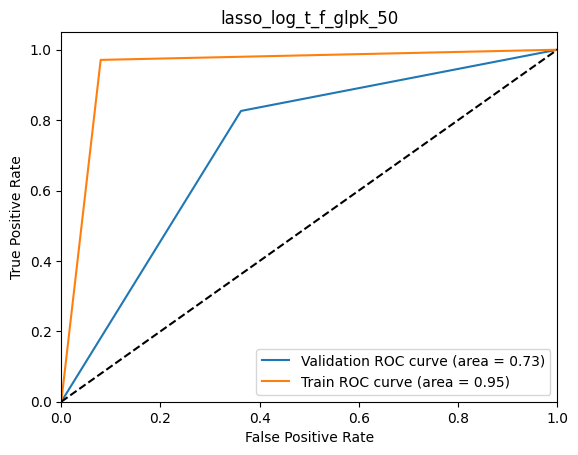

[np.float64(0.9518072289156626), np.float64(0.9497991967871486), np.float64(0.9477911646586346), np.float64(0.9497991967871486), np.float64(0.9438877755511023), np.float64(0.9539078156312625), np.float64(0.9498997995991983), np.float64(0.9498997995991983), np.float64(0.9438877755511023), np.float64(0.9539078156312625)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  -0.07246376811594213
MAE:  0.5362318840579711
RMSE:  1.035598265794194
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.47851888364366324), pvalue=np.float64(2.9167510589206336e-09))
Accuracy:  0.7318840579710145
Train accuracy:  0.8537906137184116
              precision    recall  f1-score   support

           0       0.69      0.86      0.76        69
           2       0.81      0.61      0.69        69

    accuracy                           0.73       138
   macro avg       0.75      0.73      0.73       138
weighted avg       0.75      0.73      0.73       138



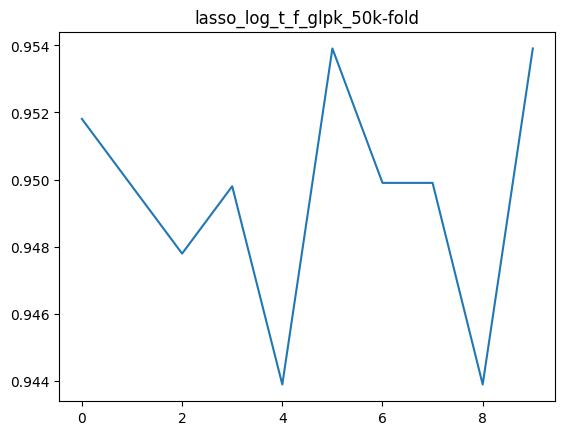

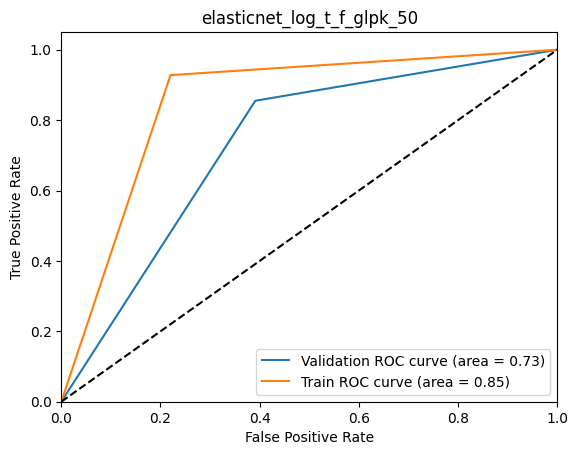

[np.float64(0.8514056224899599), np.float64(0.8514056224899599), np.float64(0.8493975903614458), np.float64(0.8514056224899599), np.float64(0.845691382765531), np.float64(0.8517034068136272), np.float64(0.843687374749499), np.float64(0.8496993987975952), np.float64(0.8476953907815631), np.float64(0.8476953907815631)]
R2 score:  -0.2753623188405796
MAE:  0.6376811594202898
RMSE:  1.1293194051465598
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.40895776600422595), pvalue=np.float64(6.358291492404125e-07))
Accuracy:  0.6811594202898551
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.62      0.91      0.74        69
           2       0.84      0.45      0.58        69

    accuracy                           0.68       138
   macro avg       0.73      0.68      0.66       138
weighted avg       0.73      0.68      0.66       138



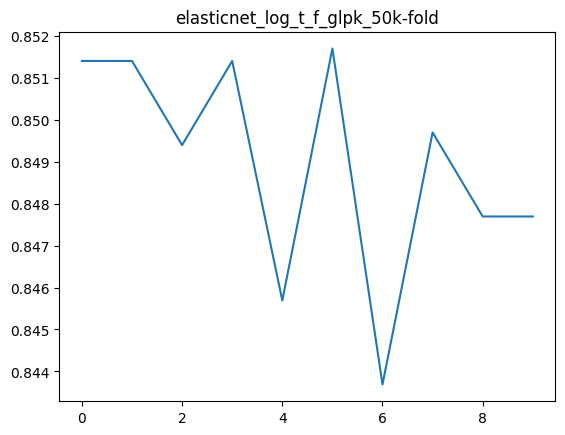

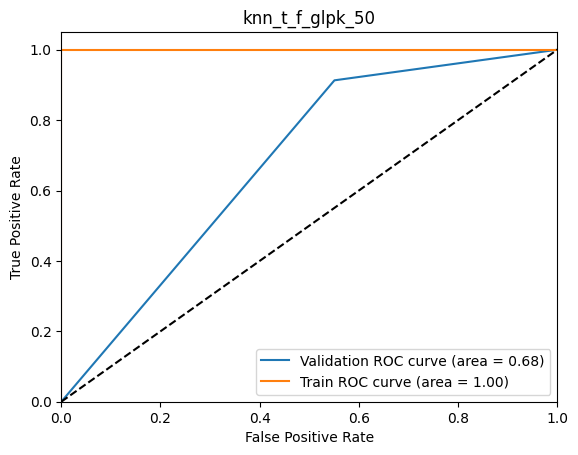

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R2 score:  0.022168568920105103
MAE:  0.4888888888888889
RMSE:  0.9888264649460884
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5114290160959446), pvalue=np.float64(2.315963313773171e-10))
Accuracy:  0.7555555555555555
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.77      0.73      0.75        67
           2       0.75      0.78      0.76        68

    accuracy                           0.76       135
   macro avg       0.76      0.76      0.76       135
weighted avg       0.76      0.76      0.76       135



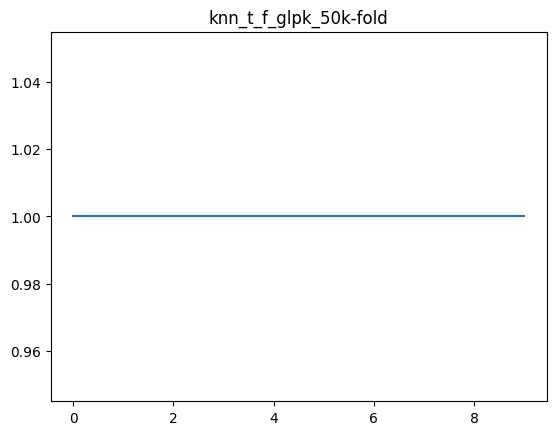

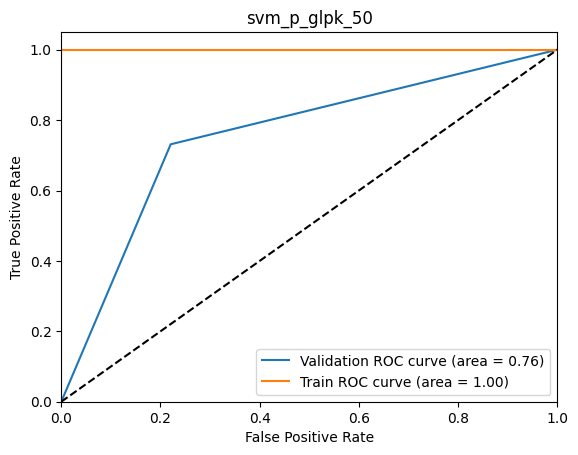

[np.float64(0.9322381930184805), np.float64(0.9383983572895277), np.float64(0.9487704918032787), np.float64(0.9508196721311475), np.float64(0.9344262295081968), np.float64(0.9426229508196722), np.float64(0.9528688524590164), np.float64(0.9426229508196722), np.float64(0.9487704918032787), np.float64(0.9487704918032787)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

R2 score:  0.11106233538191368
MAE:  0.4444444444444444
RMSE:  0.9428090415820634
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5639533574124183), pvalue=np.float64(1.0620154831365516e-12))
Accuracy:  0.7777777777777778
Train accuracy:  0.9372693726937269
              precision    recall  f1-score   support

           0       0.84      0.69      0.75        67
           2       0.74      0.87      0.80        68

    accuracy                           0.78       135
   macro avg       0.79      0.78      0.78       135
weighted avg       0.79      0.78      0.78       135



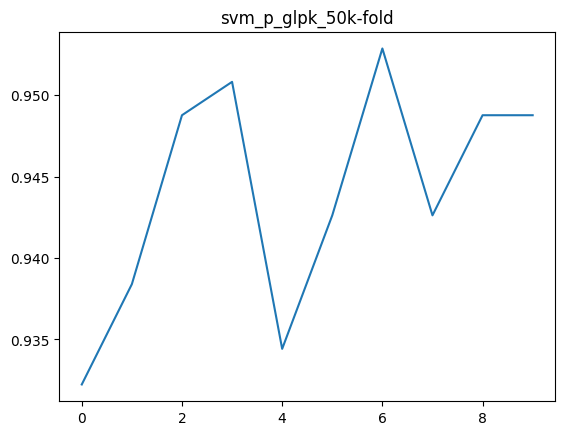

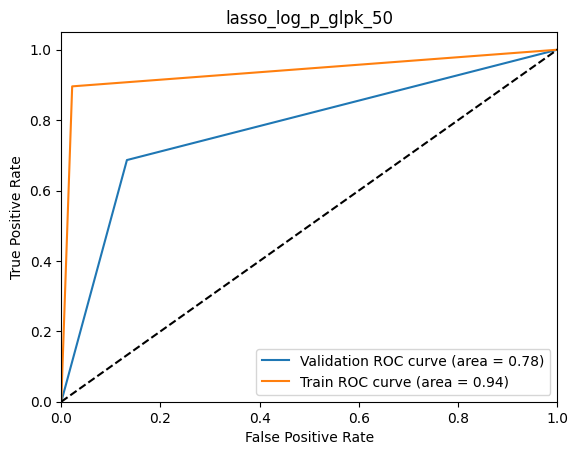

[np.float64(0.944558521560575), np.float64(0.9363449691991786), np.float64(0.9426229508196722), np.float64(0.9426229508196722), np.float64(0.9344262295081968), np.float64(0.9323770491803278), np.float64(0.9405737704918032), np.float64(0.9528688524590164), np.float64(0.9364754098360656), np.float64(0.9467213114754098)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  0.11106233538191368
MAE:  0.4444444444444444
RMSE:  0.9428090415820634
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5639533574124183), pvalue=np.float64(1.0620154831365516e-12))
Accuracy:  0.7777777777777778
Train accuracy:  0.966789667896679
              precision    recall  f1-score   support

           0       0.84      0.69      0.75        67
           2       0.74      0.87      0.80        68

    accuracy                           0.78       135
   macro avg       0.79      0.78      0.78       135
weighted avg       0.79      0.78      0.78       135



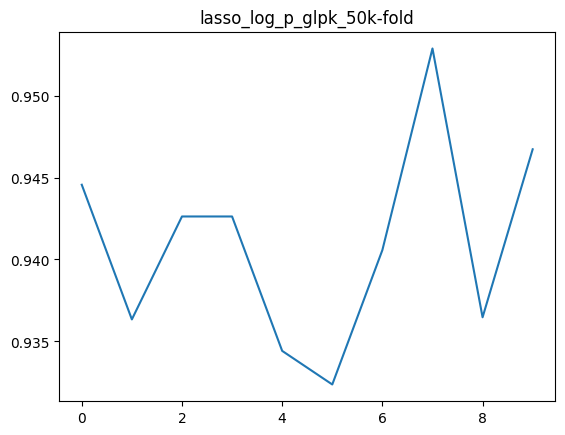

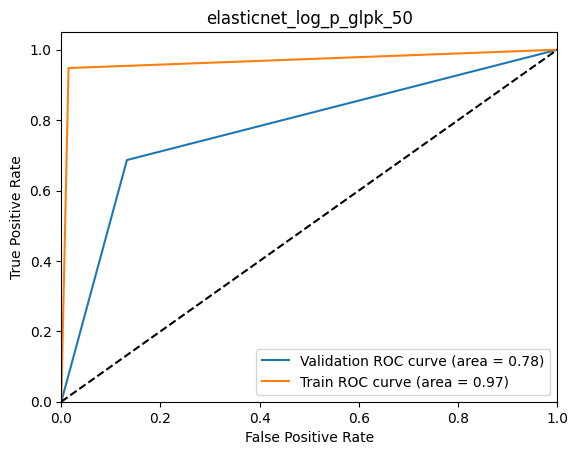

[np.float64(0.9650924024640657), np.float64(0.9609856262833676), np.float64(0.9692622950819673), np.float64(0.9631147540983607), np.float64(0.9528688524590164), np.float64(0.9713114754098361), np.float64(0.9651639344262295), np.float64(0.9713114754098361), np.float64(0.9651639344262295), np.float64(0.9672131147540983)]
R2 score:  -0.3037752414398598
MAE:  0.6518518518518519
RMSE:  1.1417984514369004
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.3806210158000609), pvalue=np.float64(5.266003375441321e-06))
Accuracy:  0.674074074074074
Train accuracy:  0.7693726937269373
              precision    recall  f1-score   support

           0       0.79      0.46      0.58        67
           2       0.62      0.88      0.73        68

    accuracy                           0.67       135
   macro avg       0.71      0.67      0.66       135
weighted avg       0.71      0.67      0.66       135



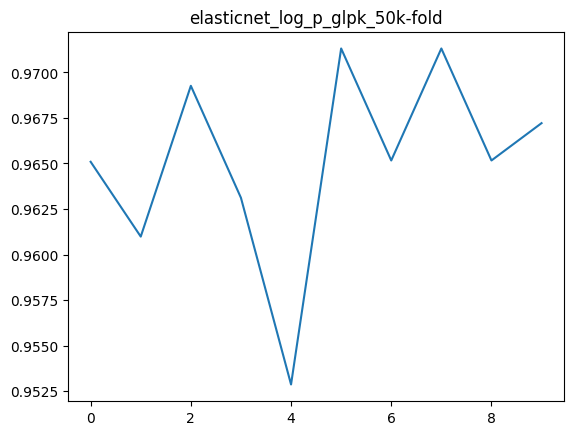

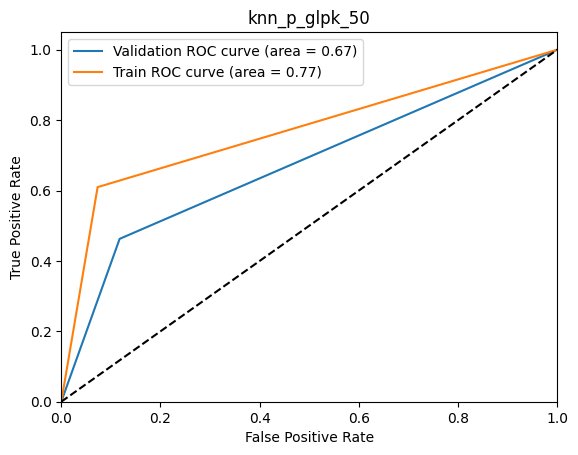

[np.float64(0.7782340862422998), np.float64(0.7618069815195072), np.float64(0.75), np.float64(0.7663934426229508), np.float64(0.7745901639344263), np.float64(0.7827868852459017), np.float64(0.7745901639344263), np.float64(0.7561475409836066), np.float64(0.7602459016393442), np.float64(0.7684426229508197)]
R2 score:  -0.24451273046532074
MAE:  0.6222222222222222
RMSE:  1.1155467020454342
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.37987930562759326), pvalue=np.float64(5.51188581410088e-06))
Accuracy:  0.6888888888888889
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.71      0.63      0.67        67
           2       0.67      0.75      0.71        68

    accuracy                           0.69       135
   macro avg       0.69      0.69      0.69       135
weighted avg       0.69      0.69      0.69       135



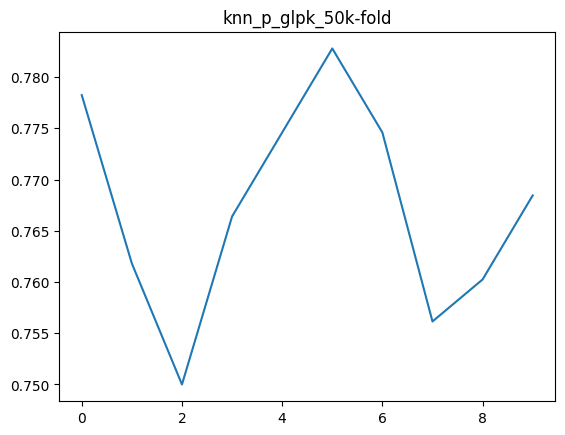

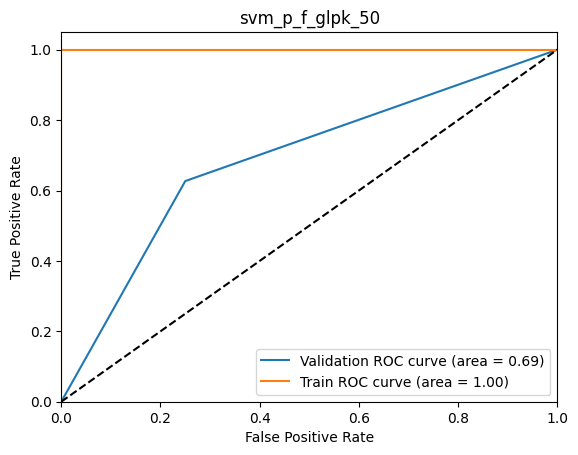

[np.float64(0.9568788501026694), np.float64(0.9568788501026694), np.float64(0.9651639344262295), np.float64(0.9528688524590164), np.float64(0.9631147540983607), np.float64(0.9610655737704918), np.float64(0.9651639344262295), np.float64(0.9610655737704918), np.float64(0.9610655737704918), np.float64(0.9590163934426229)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

R2 score:  0.11106233538191368
MAE:  0.4444444444444444
RMSE:  0.9428090415820634
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5639533574124183), pvalue=np.float64(1.0620154831365516e-12))
Accuracy:  0.7777777777777778
Train accuracy:  0.948339483394834
              precision    recall  f1-score   support

           0       0.84      0.69      0.75        67
           2       0.74      0.87      0.80        68

    accuracy                           0.78       135
   macro avg       0.79      0.78      0.78       135
weighted avg       0.79      0.78      0.78       135



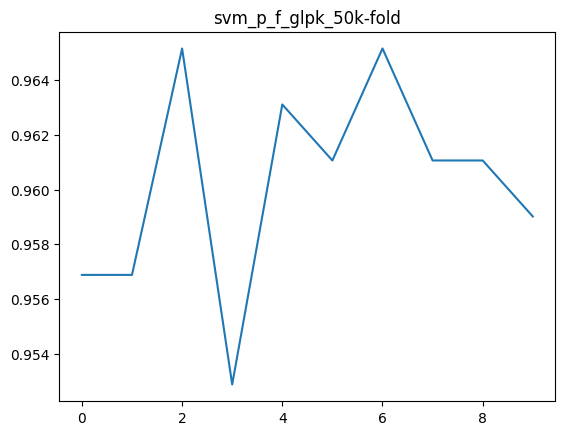

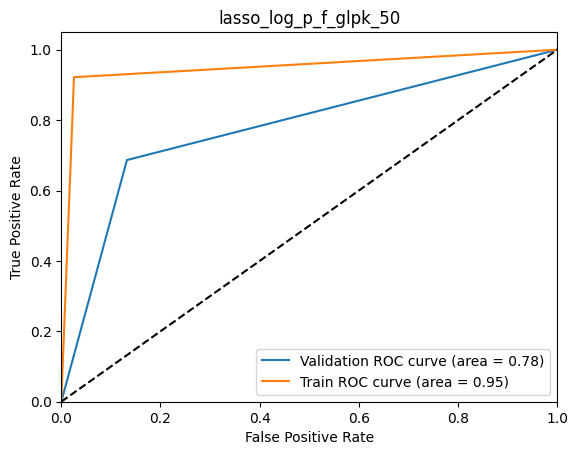

[np.float64(0.9589322381930184), np.float64(0.9486652977412731), np.float64(0.9569672131147541), np.float64(0.9426229508196722), np.float64(0.9467213114754098), np.float64(0.9569672131147541), np.float64(0.9528688524590164), np.float64(0.9467213114754098), np.float64(0.9487704918032787), np.float64(0.9549180327868853)]


/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

R2 score:  0.14069359086918332
MAE:  0.42962962962962964
RMSE:  0.9269623828717427
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5775679689582286), pvalue=np.float64(2.2409073426514043e-13))
Accuracy:  0.7851851851851852
Train accuracy:  0.9022140221402214
              precision    recall  f1-score   support

           0       0.84      0.70      0.76        67
           2       0.75      0.87      0.80        68

    accuracy                           0.79       135
   macro avg       0.79      0.78      0.78       135
weighted avg       0.79      0.79      0.78       135



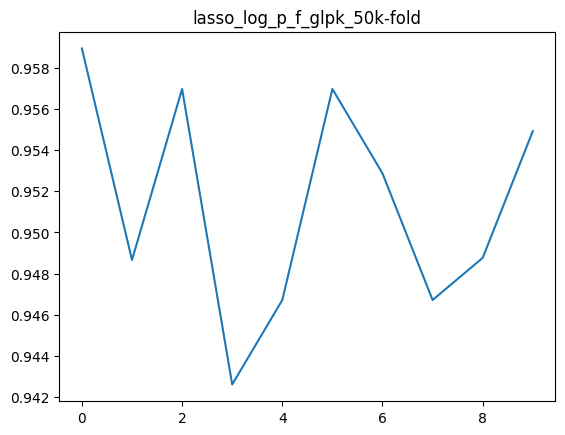

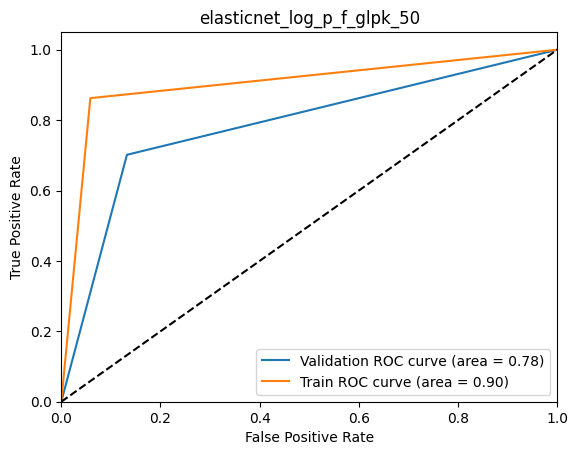

[np.float64(0.9096509240246407), np.float64(0.9117043121149897), np.float64(0.9139344262295082), np.float64(0.9098360655737705), np.float64(0.9139344262295082), np.float64(0.9221311475409836), np.float64(0.9077868852459017), np.float64(0.9036885245901639), np.float64(0.9118852459016393), np.float64(0.9036885245901639)]
R2 score:  -0.6297190517998248
MAE:  0.8148148148148148
RMSE:  1.2765694770084508
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.19947773869837782), pvalue=np.float64(0.020366206095380347))
Accuracy:  0.5925925925925926
Train accuracy:  0.7509225092250923
              precision    recall  f1-score   support

           0       0.65      0.39      0.49        67
           2       0.57      0.79      0.66        68

    accuracy                           0.59       135
   macro avg       0.61      0.59      0.57       135
weighted avg       0.61      0.59      0.57       135



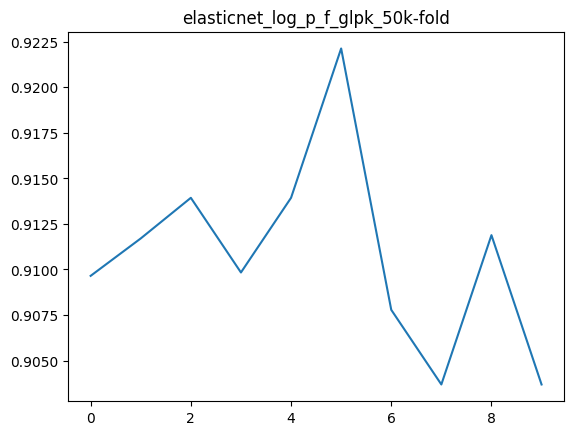

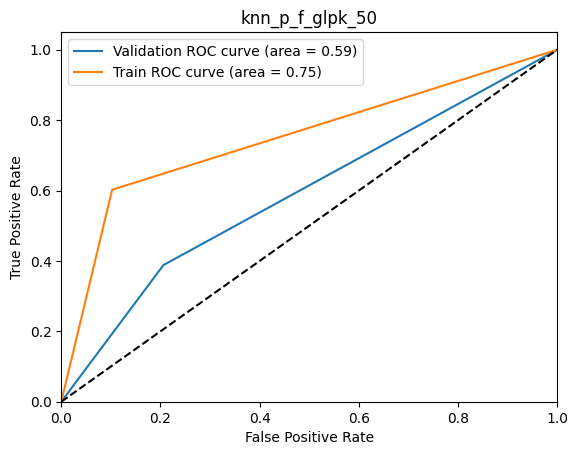

[np.float64(0.75564681724846), np.float64(0.7351129363449692), np.float64(0.7622950819672131), np.float64(0.7479508196721312), np.float64(0.7602459016393442), np.float64(0.7622950819672131), np.float64(0.7459016393442623), np.float64(0.75), np.float64(0.75), np.float64(0.7418032786885246)]


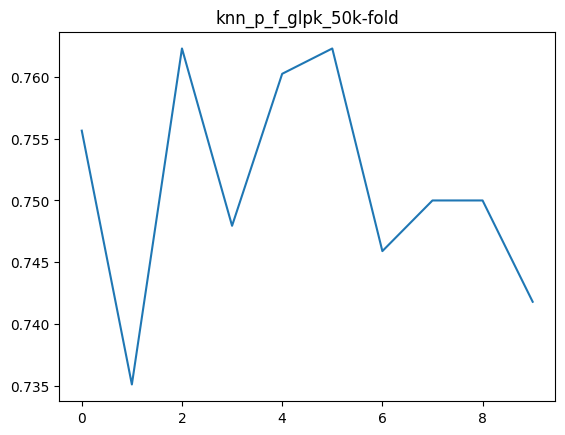

In [358]:
#load and preprocess data
[t, fluxes_t, p, fluxes_p, gr_measured_ML, y] = load_dataset()

percent = 50

#filter based on percentile
[gr_measured_ML, y] = filter_ko(gr_measured_ML, y, percent, 100 - percent)

#concatenate the dataframes
X = generate_combined_dataset(t, p, fluxes_t, fluxes_p)

#split transcriptomics dataset into train, test and validation
[y_train_liq, y_test_liq, y_valid_liq] = split_data(gr_measured_ML)
X_train_liq = X.loc[y_train_liq.index, :]
X_test_liq = X.loc[y_test_liq.index, :]
X_valid_liq = X.loc[y_valid_liq.index, :]

y_valid_liq = y_valid_liq['class']
y_train_liq = y_train_liq['class']
y_test_liq = y_test_liq['class']

#split proteomics dataset into train, test and validation
[y_train_solid, y_test_solid, y_valid_solid] = split_data(y)
X_train_solid = X.loc[y_train_solid.index, :]
X_test_solid = X.loc[y_test_solid.index, :]
X_valid_solid = X.loc[y_valid_solid.index, :]

y_train_solid = y_train_solid['class']
y_test_solid = y_test_solid['class']
y_valid_solid = y_valid_solid['class']

#subset train and validation for transcriptomics
x_train = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
x_valid = X_valid_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]

temp = SVM_model(x_train, x_valid, y_train_liq, y_valid_liq, 'svm_t_glpk_'+str(percent), temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_liq, y_valid_liq, 'lasso_log_t_glpk_'+str(percent), temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_liq, y_valid_liq, 'elasticnet_log_t_glpk_'+str(percent), temp)
temp = kNN_model(x_train, x_valid, y_train_liq, y_valid_liq, 'knn_t_glpk_'+str(percent), temp)



transcriptome = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
flux = X_train_liq.iloc[:, 1826: 3776]
x_train = pd.concat([transcriptome, flux], axis=1)
x_valid = X_valid_liq.iloc[:, 0:3776].loc[:, x_train.columns]

temp = SVM_model(x_train, x_valid, y_train_liq, y_valid_liq, 'svm_t_f_glpk_'+str(percent), temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_liq, y_valid_liq, 'lasso_log_t_f_glpk_'+str(percent), temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_liq, y_valid_liq, 'elasticnet_log_t_f_glpk_'+str(percent), temp)
temp = kNN_model(x_train, x_valid, y_train_liq, y_valid_liq, 'knn_t_f_glpk_'+str(percent), temp)

x_train = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
x_valid = X_valid_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
x_train.dropna(inplace=True)
x_valid.dropna(inplace=True)

temp = SVM_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'svm_p_glpk_'+str(percent), temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'lasso_log_p_glpk_'+str(percent), temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'elasticnet_log_p_glpk_'+str(percent), temp)
temp = kNN_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'knn_p_glpk_'+str(percent), temp)


proteome = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
flux = X_train_solid.iloc[:, 5602: ]
x_train = pd.concat([proteome, flux], axis=1)
x_valid = X_valid_solid.iloc[:, 3776:].loc[:, x_train.columns]
x_train.dropna(inplace=True)
x_valid.dropna(inplace=True)

temp = SVM_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'svm_p_f_glpk_'+str(percent), temp)
temp = LR_Lasso_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'lasso_log_p_f_glpk_'+str(percent), temp)
temp = LR_elasticnet_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'elasticnet_log_p_f_glpk_'+str(percent), temp)
temp = kNN_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'knn_p_f_glpk_'+str(percent), temp)

In [ ]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, root_mean_squared_error

Regression models

In [489]:
transcriptome = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
flux = X_train_liq.iloc[:, 1826: 3776]
x_train = pd.concat([transcriptome, flux], axis=1)
x_valid = X_valid_liq.iloc[:, 0:3776].loc[:, x_train.columns]

# x_train = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
# x_valid = X_valid_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
# x_test = X_test_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]

reg = joblib.load("svm_reg_t_f_glpk_50.joblib")
print(root_mean_squared_error(y_train_liq, reg.predict(x_train)))
print(mean_absolute_error(y_train_liq, reg.predict(x_train)))
print(median_absolute_error(y_train_liq, reg.predict(x_train)))

0.06222124929050496
0.05197168526687201
0.04592577065129559


In [485]:
proteome = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
flux = X_train_solid.iloc[:, 5602: ]
x_train = pd.concat([proteome, flux], axis=1)
x_valid = X_valid_solid.iloc[:, 3776:].loc[:, x_train.columns]
x_test = X_test_solid.iloc[:, 3776:].loc[:, x_train.columns]
x_train.dropna(inplace=True)
x_valid.dropna(inplace=True)
x_test.dropna(inplace=True)

x_train = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
x_valid = X_valid_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
x_train.dropna(inplace=True)
x_valid.dropna(inplace=True)

reg = joblib.load("svm_reg_p_glpk_50.joblib")
print(root_mean_squared_error(y_train_solid.loc[x_train.index], reg.predict(x_train)))
print(mean_absolute_error(y_train_solid.loc[x_train.index], reg.predict(x_train)))
print(median_absolute_error(y_train_solid.loc[x_train.index], reg.predict(x_train)))

0.06993072503794563
0.05882630347623874
0.0554805456508225


In [431]:
import matplotlib.patches as mpatches
from scipy.stats import spearmanr

Text(0.6, 0.05, 'Spearman Correlation = 0.59')

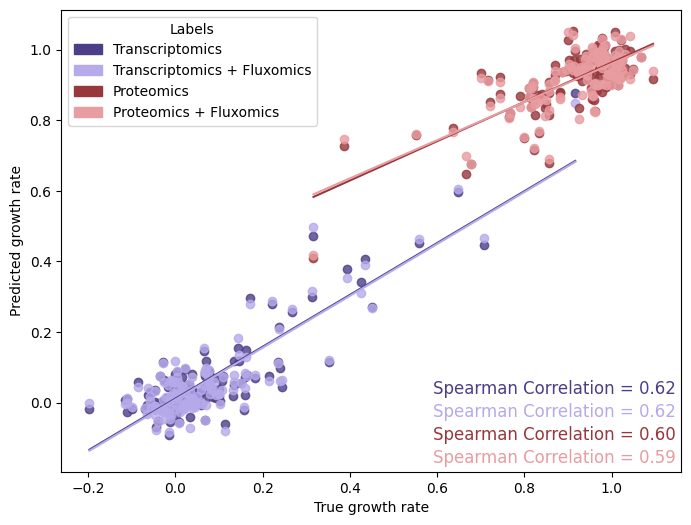

In [515]:
x_valid = X_valid_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]

reg = joblib.load("lasso_reg_t_glpk_50.joblib")
pred = reg.predict(x_valid)
r_t, p = spearmanr(y_valid_liq.loc[x_valid.index], pred)
plt.figure(figsize=(8, 6))

plt.scatter(y_valid_liq, pred,  c='#4d3e88', alpha=0.8)
plt.plot(np.unique(y_valid_liq), np.poly1d(np.polyfit(y_valid_liq, pred, 1))
         (np.unique(y_valid_liq)), color='#4d3e88')

transcriptome = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
flux = X_train_liq.iloc[:, 1826: 3776]
x_train = pd.concat([transcriptome, flux], axis=1)
x_valid = X_valid_liq.iloc[:, 0:3776].loc[:, x_train.columns]

reg = joblib.load("lasso_reg_t_f_glpk_50.joblib")
pred = reg.predict(x_valid)
r_tf, p = spearmanr(y_valid_liq.loc[x_valid.index], pred)

plt.scatter(y_valid_liq, pred,  c='#b7aaea', alpha=0.8)
plt.plot(np.unique(y_valid_liq), np.poly1d(np.polyfit(y_valid_liq, pred, 1))
         (np.unique(y_valid_liq)), color='#b7aaea')

proteome = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
flux = X_train_solid.iloc[:, 5602: ]
x_train = pd.concat([proteome, flux], axis=1)
x_valid = X_valid_solid.iloc[:, 3776:].loc[:, x_train.columns]
x_train.dropna(inplace=True)
x_valid.dropna(inplace=True)

reg = joblib.load("lasso_reg_p_f_glpk_50.joblib")
pred = reg.predict(x_valid)
r_p, p = spearmanr(y_valid_solid.loc[x_valid.index], pred)

plt.scatter(y_valid_solid.loc[x_valid.index], pred,  c='#98373c', alpha=0.8)
plt.plot(np.unique(y_valid_solid.loc[x_valid.index]), np.poly1d(np.polyfit(y_valid_solid.loc[x_valid.index], pred, 1))
         (np.unique(y_valid_solid.loc[x_valid.index])), color='#98373c')

x_train = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
x_valid = X_valid_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
x_train.dropna(inplace=True)
x_valid.dropna(inplace=True)

reg = joblib.load("lasso_reg_p_glpk_50.joblib")
pred = reg.predict(x_valid)
r_pf, p = spearmanr(y_valid_solid.loc[x_valid.index], pred)

plt.scatter(y_valid_solid.loc[x_valid.index], pred,  c='#e89da1', alpha=0.8)
plt.plot(np.unique(y_valid_solid.loc[x_valid.index]), np.poly1d(np.polyfit(y_valid_solid.loc[x_valid.index], pred, 1))
         (np.unique(y_valid_solid.loc[x_valid.index])), color='#e89da1')

plt.xlabel("True growth rate")
plt.ylabel("Predicted growth rate")
legend_patches = [
    mpatches.Patch(color='#4d3e88', label='Transcriptomics'),
    mpatches.Patch(color='#b7aaea', label='Transcriptomics + Fluxomics'),
    mpatches.Patch(color='#98373c', label='Proteomics'),
    mpatches.Patch(color='#e89da1', label='Proteomics + Fluxomics')
]
plt.legend(handles=legend_patches, title='Labels', loc='upper left')

plt.text(0.6, 0.2, f"Spearman Correlation = {r_t:.2f}", transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', color='#4d3e88')
plt.text(0.6, 0.15, f"Spearman Correlation = {r_tf:.2f}", transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', color='#b7aaea')
plt.text(0.6, 0.1, f"Spearman Correlation = {r_p:.2f}", transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', color='#98373c')
plt.text(0.6, 0.05, f"Spearman Correlation = {r_pf:.2f}", transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', color='#e89da1')

Text(0.3, 0.05, 'Training Spearman Correlation = 0.90')

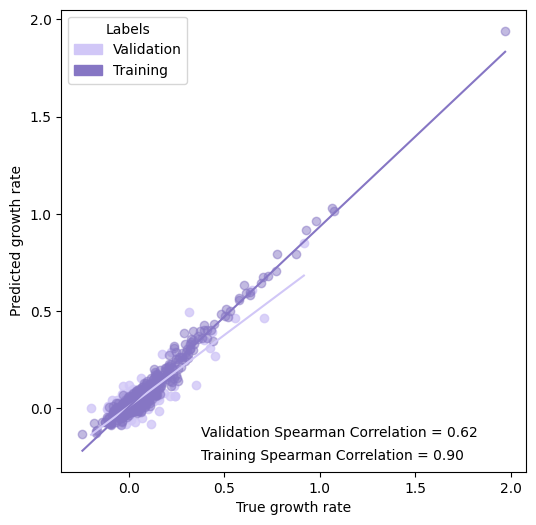

In [536]:
x_valid = X_valid_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
x_train = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]

transcriptome = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
flux = X_train_liq.iloc[:, 1826: 3776]
x_train = pd.concat([transcriptome, flux], axis=1)
x_valid = X_valid_liq.iloc[:, 0:3776].loc[:, x_train.columns]

reg = joblib.load("lasso_reg_t_f_glpk_50.joblib")
pred = reg.predict(x_valid)

plt.figure(figsize=(6, 6))

plt.scatter(y_valid_liq, pred,  c='#d1c7f7', alpha=0.8)
plt.scatter(y_train_liq, reg.predict(x_train), c='#8676c4', alpha=0.5)
plt.plot(np.unique(y_valid_liq), np.poly1d(np.polyfit(y_valid_liq, pred, 1))
         (np.unique(y_valid_liq)), color='#d1c7f7')
plt.plot(np.unique(y_train_liq), np.poly1d(np.polyfit(y_train_liq, reg.predict(x_train), 1))
         (np.unique(y_train_liq)), color='#8676c4')

plt.xlabel("True growth rate")
plt.ylabel("Predicted growth rate")
legend_patches = [
    mpatches.Patch(color='#d1c7f7', label='Validation'),
    mpatches.Patch(color='#8676c4', label='Training')
]
plt.legend(handles=legend_patches, title='Labels', loc='upper left')

r, p = spearmanr(y_valid_liq, pred)
plt.text(0.3, 0.1, f"Validation Spearman Correlation = {r:.2f}", transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top')
r, p = spearmanr(y_train_liq,  reg.predict(x_train))
plt.text(0.3, 0.05, f"Training Spearman Correlation = {r:.2f}", transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top')


Text(0.3, 0.05, 'Training Spearman Correlation = 0.68')

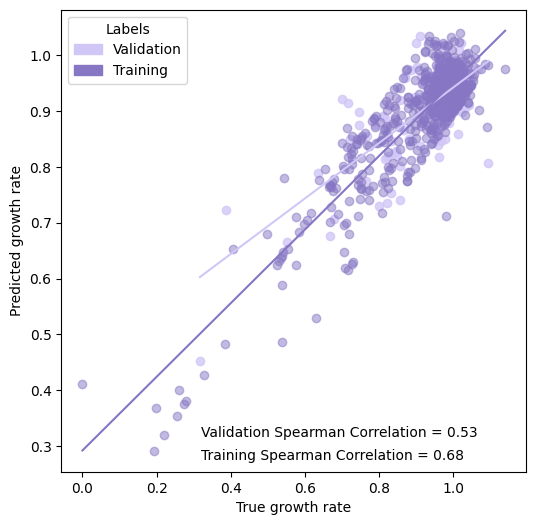

In [532]:
proteome = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
flux = X_train_solid.iloc[:, 5602: ]
x_train = pd.concat([proteome, flux], axis=1)
x_valid = X_valid_solid.iloc[:, 3776:].loc[:, x_train.columns]
x_train.dropna(inplace=True)
x_valid.dropna(inplace=True)

# x_train = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
# x_valid = X_valid_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
# x_train.dropna(inplace=True)
# x_valid.dropna(inplace=True)

reg = joblib.load("svm_reg_p_f_glpk_50.joblib")
pred = reg.predict(x_valid)

plt.figure(figsize=(6, 6))

plt.scatter(y_valid_solid.loc[x_valid.index], pred,  c='#d1c7f7', alpha=0.8)
plt.scatter(y_train_solid.loc[x_train.index], reg.predict(x_train), c='#8676c4', alpha=0.5)
plt.plot(np.unique(y_valid_solid.loc[x_valid.index]), np.poly1d(np.polyfit(y_valid_solid.loc[x_valid.index], pred, 1))
         (np.unique(y_valid_solid.loc[x_valid.index])), color='#d1c7f7')
plt.plot(np.unique(y_train_solid.loc[x_train.index]), np.poly1d(np.polyfit(y_train_solid.loc[x_train.index], reg.predict(x_train), 1))
         (np.unique(y_train_solid.loc[x_train.index])), color='#8676c4')

plt.xlabel("True growth rate")
plt.ylabel("Predicted growth rate")
legend_patches = [
    mpatches.Patch(color='#d1c7f7', label='Validation'),
    mpatches.Patch(color='#8676c4', label='Training')
]
plt.legend(handles=legend_patches, title='Labels', loc='upper left')

r, p = spearmanr(y_valid_solid.loc[x_valid.index], pred)
plt.text(0.3, 0.1, f"Validation Spearman Correlation = {r:.2f}", transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top')
r, p = spearmanr(y_train_solid.loc[x_train.index],  reg.predict(x_train))
plt.text(0.3, 0.05, f"Training Spearman Correlation = {r:.2f}", transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top')


In [17]:
def performance_to_df(temp, name, statistics):
    temp.loc[name, temp.columns[:4]] = statistics[:4]
    temp.loc[name, 'Spearman Correlation'] = statistics[4].statistic
    temp.loc[name, temp.columns[5:7]] = statistics[5:7]
    temp.loc[name, 'Precision'] = statistics[7]['precision']
    temp.loc[name, 'Recall'] = statistics[7]['recall']
    temp.loc[name, 'F1-Score'] = statistics[7]['f1-score']

    return temp

In [ ]:
#load and preprocess data
[t, fluxes_t, p, fluxes_p, gr_measured_ML, y] = load_dataset()

percent = 50

#filter based on percentile
[gr_measured_ML, y] = filter_ko(gr_measured_ML, y, percent, 100 - percent)

#concatenate the dataframes
X = generate_combined_dataset(t, p, fluxes_t, fluxes_p)

#split transcriptomics dataset into train, test and validation
[y_train_liq, y_test_liq, y_valid_liq] = split_data(gr_measured_ML)
X_train_liq = X.loc[y_train_liq.index, :]
X_test_liq = X.loc[y_test_liq.index, :]
X_valid_liq = X.loc[y_valid_liq.index, :]

y_valid_liq = y_valid_liq['0']
y_train_liq = y_train_liq['0']
y_test_liq = y_test_liq['0']

#split proteomics dataset into train, test and validation
[y_train_solid, y_test_solid, y_valid_solid] = split_data(y)
X_train_solid = X.loc[y_train_solid.index, :]
X_test_solid = X.loc[y_test_solid.index, :]
X_valid_solid = X.loc[y_valid_solid.index, :]

y_train_solid = y_train_solid['SM']
y_test_solid = y_test_solid['SM']
y_valid_solid = y_valid_solid['SM']

#initialize the statistics dataframe
temp_r = pd.DataFrame(columns=['R2 Score', 'MAE', 'RMSE', 'MDAE', 'Spearman Correlation', 'Accuracy', 'Train Accuracy', 'Precision', 'Recall', 'F1-Score'])

#subset train and validation for transcriptomics
x_train = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
x_valid = X_valid_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]


# temp_r = regression_LASSO_model(x_train, x_valid, y_train_liq, y_valid_liq, 'lasso_reg_t_glpk_'+str(percent), temp_r)
temp_r = regression_RandomForest_model(x_train, x_valid, y_train_liq, y_valid_liq, 'rf_reg_t_glpk_'+str(percent), temp_r)
# temp_r = regression_SVM_model(x_train, x_valid, y_train_liq, y_valid_liq, 'svm_reg_t_glpk_'+str(percent), temp_r)


# transcriptome = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
# flux = X_train_liq.iloc[:, 1826: 3776]
# x_train = pd.concat([transcriptome, flux], axis=1)
# x_valid = X_valid_liq.iloc[:, 0:3776].loc[:, x_train.columns]

# # temp_r = regression_LASSO_model(x_train, x_valid, y_train_liq, y_valid_liq, 'lasso_reg_t_f_glpk_'+str(percent), temp_r)
# temp_r = regression_RandomForest_model(x_train, x_valid, y_train_liq, y_valid_liq, 'rf_reg_t_f_glpk_'+str(percent), temp_r)
# # temp_r = regression_SVM_model(x_train, x_valid, y_train_liq, y_valid_liq, 'svm_reg_t_f_glpk_'+str(percent), temp_r)


# x_train = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
# x_valid = X_valid_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
# x_train.dropna(inplace=True)
# x_valid.dropna(inplace=True)

# # temp_r = regression_LASSO_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'lasso_reg_p_glpk_'+str(percent), temp_r)
# temp_r = regression_RandomForest_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'rf_reg_p_glpk_'+str(percent), temp_r)
# # temp_r = regression_SVM_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'svm_reg_p_glpk_'+str(percent), temp_r)


# proteome = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
# flux = X_train_solid.iloc[:, 5602: ]
# x_train = pd.concat([proteome, flux], axis=1)
# x_valid = X_valid_solid.iloc[:, 3776:].loc[:, x_train.columns]
# x_train.dropna(inplace=True)
# x_valid.dropna(inplace=True)

# # temp_r = regression_LASSO_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'lasso_reg_p_f_glpk_'+str(percent), temp_r)
# temp_r = regression_RandomForest_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'rf_reg_p_f_glpk_'+str(percent), temp_r)
# # temp_r = regression_SVM_model(x_train, x_valid, y_train_solid.loc[x_train.index], y_valid_solid.loc[x_valid.index], 'svm_reg_p_f_glpk_'+str(percent), temp_r)

/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_956/3380375233.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_train = y.groupby('class', group_keys=False).apply(lambda x: x.sample(n=train_size//2, random_state=42))
/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_956/3380375233.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_valid = train_valid.groupby('class', group_keys

In [18]:
splits = [10, 20, 30, 40, 50]
stats_df = pd.DataFrame(columns=['R2 Score', 'MAE', 'RMSE', 'MDAE', 'Spearman Correlation', 'Accuracy', 'Train Accuracy', 'Precision', 'Recall', 'F1-Score'])

for s in splits:

        
        #load and preprocess data
        [t, fluxes_t, p, fluxes_p, gr_measured_ML, y] = load_dataset()

        percent = s

        #filter based on percentile
        [gr_measured_ML, y] = filter_ko(gr_measured_ML, y, percent, 100 - percent)

        #concatenate the dataframes
        X = generate_combined_dataset(t, p, fluxes_t, fluxes_p)

        #split transcriptomics dataset into train, test and validation
        [y_train_liq, y_test_liq, y_valid_liq] = split_data(gr_measured_ML)
        X_train_liq = X.loc[y_train_liq.index, :]
        X_test_liq = X.loc[y_test_liq.index, :]
        X_valid_liq = X.loc[y_valid_liq.index, :]

        y_valid_liq = y_valid_liq['class']
        y_train_liq = y_train_liq['class']
        y_test_liq = y_test_liq['class']

        #split proteomics dataset into train, test and validation
        [y_train_solid, y_test_solid, y_valid_solid] = split_data(y)
        X_train_solid = X.loc[y_train_solid.index, :]
        X_test_solid = X.loc[y_test_solid.index, :]
        X_valid_solid = X.loc[y_valid_solid.index, :]

        y_train_solid = y_train_solid['class']
        y_test_solid = y_test_solid['class']
        y_valid_solid = y_valid_solid['class']

        print(s)

        #subset train and validation for transcriptomics
        x_train = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
        x_valid = X_valid_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
        x_test = X_test_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]

        loaded_model = joblib.load("svm_t_glpk_"+str(percent)+".joblib")
        temp = performance(loaded_model, x_train, y_train_liq, x_test, y_test_liq)
        stats_df = performance_to_df(stats_df, 'SVM_T_'+str(s), temp)

        loaded_model = joblib.load("knn_t_glpk_"+str(percent)+".joblib")
        temp = performance(loaded_model, x_train, y_train_liq, x_test, y_test_liq)
        stats_df = performance_to_df(stats_df, 'KNN_T_'+str(s), temp)

        loaded_model = joblib.load("lasso_log_t_glpk_"+str(percent)+".joblib")
        temp = performance(loaded_model, x_train, y_train_liq, x_test, y_test_liq)
        stats_df = performance_to_df(stats_df, 'LASSO_log_T_'+str(s), temp)

        loaded_model = joblib.load("elasticnet_log_t_glpk_"+str(percent)+".joblib")
        temp = performance(loaded_model, x_train, y_train_liq, x_test, y_test_liq)
        stats_df = performance_to_df(stats_df, 'Elasticnet_T_'+str(s), temp)

        transcriptome = X_train_liq.iloc[:, 0:1826].loc[:, double_KO.columns[1:]]
        flux = X_train_liq.iloc[:, 1826: 3776]
        x_train = pd.concat([transcriptome, flux], axis=1)
        x_valid = X_valid_liq.iloc[:, 0:3776].loc[:, x_train.columns]
        x_test = X_test_liq.iloc[:, 0:3776].loc[:, x_train.columns]

        loaded_model = joblib.load("svm_t_f_glpk_"+str(percent)+".joblib")
        temp = performance(loaded_model, x_train, y_train_liq, x_test, y_test_liq)
        stats_df = performance_to_df(stats_df, 'SVM_T_F_'+str(s), temp)

        loaded_model = joblib.load("knn_t_f_glpk_"+str(percent)+".joblib")
        temp = performance(loaded_model, x_train, y_train_liq, x_test, y_test_liq)
        stats_df = performance_to_df(stats_df, 'KNN_T_F_'+str(s), temp)

        loaded_model = joblib.load("lasso_log_t_f_glpk_"+str(percent)+".joblib")
        temp = performance(loaded_model, x_train, y_train_liq, x_test, y_test_liq)
        stats_df = performance_to_df(stats_df, 'Lasso_log_T_F_'+str(s), temp)

        loaded_model = joblib.load("elasticnet_log_t_f_glpk_"+str(percent)+".joblib")
        temp = performance(loaded_model, x_train, y_train_liq, x_test, y_test_liq)
        stats_df = performance_to_df(stats_df, 'Elasticnet_T_F_'+str(s), temp)


        x_train = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
        x_valid = X_valid_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
        x_test = X_test_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
        x_train.dropna(inplace=True)
        x_valid.dropna(inplace=True)
        x_test.dropna(inplace=True)

        loaded_model = joblib.load("svm_p_glpk_"+str(percent)+".joblib")
        temp = performance(loaded_model, x_train, y_train_solid.loc[x_train.index], x_test, y_test_solid.loc[x_test.index])
        stats_df = performance_to_df(stats_df, 'SVM_P_'+str(s), temp)

        loaded_model = joblib.load("knn_p_glpk_"+str(percent)+".joblib")
        temp = performance(loaded_model, x_train, y_train_solid.loc[x_train.index], x_test, y_test_solid.loc[x_test.index])
        stats_df = performance_to_df(stats_df, 'KNN_P_'+str(s), temp)

        loaded_model = joblib.load("lasso_log_p_glpk_"+str(percent)+".joblib")
        temp = performance(loaded_model, x_train, y_train_solid.loc[x_train.index], x_test, y_test_solid.loc[x_test.index])
        stats_df = performance_to_df(stats_df, 'Lasso_log_P_'+str(s), temp)

        loaded_model = joblib.load("elasticnet_log_p_glpk_"+str(percent)+".joblib")
        temp = performance(loaded_model, x_train, y_train_solid.loc[x_train.index], x_test, y_test_solid.loc[x_test.index])
        stats_df = performance_to_df(stats_df, 'Elasticnet_P_'+str(s), temp)


        proteome = X_train_solid.iloc[:, 3776:5602].loc[:, double_KO.columns[1:]]
        flux = X_train_solid.iloc[:, 5602: ]
        x_train = pd.concat([proteome, flux], axis=1)
        x_valid = X_valid_solid.iloc[:, 3776:].loc[:, x_train.columns]
        x_test = X_test_solid.iloc[:, 3776:].loc[:, x_train.columns]
        x_train.dropna(inplace=True)
        x_valid.dropna(inplace=True)
        x_test.dropna(inplace=True)

        loaded_model = joblib.load("svm_p_f_glpk_"+str(percent)+".joblib")
        temp = performance(loaded_model, x_train, y_train_solid.loc[x_train.index], x_test, y_test_solid.loc[x_test.index])
        stats_df = performance_to_df(stats_df, 'SVM_P_F_'+str(s), temp)

        loaded_model = joblib.load("knn_p_f_glpk_"+str(percent)+".joblib")
        temp = performance(loaded_model, x_train, y_train_solid.loc[x_train.index], x_test, y_test_solid.loc[x_test.index])
        stats_df = performance_to_df(stats_df, 'KNN_P_F_'+str(s), temp)
        
        loaded_model = joblib.load("lasso_log_p_f_glpk_"+str(percent)+".joblib")
        temp = performance(loaded_model, x_train, y_train_solid.loc[x_train.index], x_test, y_test_solid.loc[x_test.index])
        stats_df = performance_to_df(stats_df, 'Lasso_log_P_F_'+str(s), temp)

        loaded_model = joblib.load("elasticnet_log_p_f_glpk_"+str(percent)+".joblib")
        temp = performance(loaded_model, x_train, y_train_solid.loc[x_train.index], x_test, y_test_solid.loc[x_test.index])
        sstats_df = performance_to_df(stats_df, 'Elasticnet_P_F_'+str(s), temp)

stats_df.to_csv("statistics.csv")

/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_29258/3380375233.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_train = y.groupby('class', group_keys=False).apply(lambda x: x.sample(n=train_size//2, random_state=42))
/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_29258/3380375233.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_valid = train_valid.groupby('class', group_

10
R2 score:  0.7997775305895439
MAE:  0.1
RMSE:  0.4472135954999579
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.9005004170528446), pvalue=np.float64(1.2195103796396125e-22))
Accuracy:  0.95
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        29
           2       0.97      0.94      0.95        31

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60

R2 score:  0.3993325917686318
MAE:  0.3
RMSE:  0.7745966692414834
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7216396688393493), pvalue=np.float64(7.754272748773259e-11))
Accuracy:  0.85
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.78      0.97      0.86        29
           2       0.96      0.74      0.84        31

    accuracy             

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        29
           2       0.97      0.90      0.93        31

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60

R2 score:  0.7997775305895439
MAE:  0.1
RMSE:  0.4472135954999579
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.9005004170528446), pvalue=np.float64(1.2195103796396125e-22))
Accuracy:  0.95
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        29
           2       0.97      0.94      0.95        31

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60

R2 score:  0.4660734149054505
MAE:  0.26666666666666666
RMSE:  0.7302967433402214
MD

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unp

R2 score:  0.7330367074527253
MAE:  0.13333333333333333
RMSE:  0.5163977794943222
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8665183537263625), pvalue=np.float64(3.7615475285484015e-19))
Accuracy:  0.9333333333333333
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        29
           2       0.94      0.94      0.94        31

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.93      0.93      0.93        60

R2 score:  0.7330367074527253
MAE:  0.13333333333333333
RMSE:  0.5163977794943222
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8665183537263625), pvalue=np.float64(3.7615475285484015e-19))
Accuracy:  0.9333333333333333
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        29
           2       0.9

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  0.71712158808933
MAE:  0.14035087719298245
RMSE:  0.5298129428260175
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8657081202406209), pvalue=np.float64(3.626360644101276e-18))
Accuracy:  0.9298245614035088
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        26
           2       0.89      1.00      0.94        31

    accuracy                           0.93        57
   macro avg       0.94      0.92      0.93        57
weighted avg       0.94      0.93      0.93        57

R2 score:  0.858560794044665
MAE:  0.07017543859649122
RMSE:  0.3746343246326776
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.9292803970223324), pvalue=np.float64(1.8670637401311756e-25))
Accuracy:  0.9649122807017544
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           2       0.97   

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  0.71712158808933
MAE:  0.14035087719298245
RMSE:  0.5298129428260175
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8598577804857348), pvalue=np.float64(1.0815606964730327e-17))
Accuracy:  0.9298245614035088
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.96      0.88      0.92        26
           2       0.91      0.97      0.94        31

    accuracy                           0.93        57
   macro avg       0.93      0.93      0.93        57
weighted avg       0.93      0.93      0.93        57

R2 score:  0.858560794044665
MAE:  0.07017543859649122
RMSE:  0.3746343246326776
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.9320212414264205), pvalue=np.float64(6.528376379802368e-26))
Accuracy:  0.9649122807017544
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        26
           2       1.00   

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  0.858560794044665
MAE:  0.07017543859649122
RMSE:  0.3746343246326776
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.9320212414264205), pvalue=np.float64(6.528376379802368e-26))
Accuracy:  0.9649122807017544
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        26
           2       1.00      0.94      0.97        31

    accuracy                           0.96        57
   macro avg       0.96      0.97      0.96        57
weighted avg       0.97      0.96      0.96        57



/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_29258/3380375233.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_train = y.groupby('class', group_keys=False).apply(lambda x: x.sample(n=train_size//2, random_state=42))
/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_29258/3380375233.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_valid = train_valid.groupby('class', group_

20
R2 score:  0.836021505376344
MAE:  0.08196721311475409
RMSE:  0.40488816508945796
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.918156170097534), pvalue=np.float64(4.467474561485596e-50))
Accuracy:  0.9590163934426229
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        60
           2       0.97      0.95      0.96        62

    accuracy                           0.96       122
   macro avg       0.96      0.96      0.96       122
weighted avg       0.96      0.96      0.96       122

R2 score:  0.27849462365591393
MAE:  0.36065573770491804
RMSE:  0.8493005801304012
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6638454212676385), pvalue=np.float64(7.8359211238349e-17))
Accuracy:  0.819672131147541
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.75      0.95      0.84        60
           2       0.93 

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  0.7376344086021505
MAE:  0.13114754098360656
RMSE:  0.5121475197315839
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8692147124035615), pvalue=np.float64(1.637789602686049e-38))
Accuracy:  0.9344262295081968
Train accuracy:  0.990990990990991
              precision    recall  f1-score   support

           0       0.95      0.92      0.93        60
           2       0.92      0.95      0.94        62

    accuracy                           0.93       122
   macro avg       0.94      0.93      0.93       122
weighted avg       0.93      0.93      0.93       122



/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


R2 score:  0.27849462365591393
MAE:  0.36065573770491804
RMSE:  0.8493005801304012
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6489513805854031), pvalue=np.float64(6.294701184065712e-16))
Accuracy:  0.819672131147541
Train accuracy:  0.8288288288288288
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        60
           2       0.88      0.74      0.81        62

    accuracy                           0.82       122
   macro avg       0.83      0.82      0.82       122
weighted avg       0.83      0.82      0.82       122



/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  0.6720430107526881
MAE:  0.16393442622950818
RMSE:  0.5725983343138682
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8365591397849462), pvalue=np.float64(3.796361368821139e-33))
Accuracy:  0.9180327868852459
Train accuracy:  0.972972972972973
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        60
           2       0.93      0.90      0.92        62

    accuracy                           0.92       122
   macro avg       0.92      0.92      0.92       122
weighted avg       0.92      0.92      0.92       122

R2 score:  0.6720430107526881
MAE:  0.16393442622950818
RMSE:  0.5725983343138682
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8365591397849462), pvalue=np.float64(3.796361368821139e-33))
Accuracy:  0.9180327868852459
Train accuracy:  0.9594594594594594
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.85      0.69      0.76        58
           2       0.75      0.89      0.81        62

    accuracy                           0.79       120
   macro avg       0.80      0.79      0.79       120
weighted avg       0.80      0.79      0.79       120

R2 score:  0.5328142380422692
MAE:  0.23333333333333334
RMSE:  0.6831300510639732
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7695168559855078), pvalue=np.float64(9.897849515835366e-25))
Accuracy:  0.8833333333333333
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.92      0.83      0.87        58
           2       0.85      0.94      0.89        62

    accuracy                           0.88       120
   macro avg       0.89      0.88      0.88       120
weighted avg       0.89      0.88      0.88       120

R2 score:  0.5328142380422692
MAE:  0.23333333333333334

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  0.5995550611790879
MAE:  0.2
RMSE:  0.6324555320336759
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.8011253194776194), pvalue=np.float64(4.494312872881994e-28))
Accuracy:  0.9
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        58
           2       0.88      0.94      0.91        62

    accuracy                           0.90       120
   macro avg       0.90      0.90      0.90       120
weighted avg       0.90      0.90      0.90       120



/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


R2 score:  -0.0344827586206895
MAE:  0.5166666666666667
RMSE:  1.0165300454651272
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5247242464198654), pvalue=np.float64(7.658942839683931e-10))
Accuracy:  0.7416666666666667
Train accuracy:  0.7830188679245284
              precision    recall  f1-score   support

           0       0.91      0.52      0.66        58
           2       0.68      0.95      0.79        62

    accuracy                           0.74       120
   macro avg       0.79      0.73      0.73       120
weighted avg       0.79      0.74      0.73       120



/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  0.5661846496106786
MAE:  0.21666666666666667
RMSE:  0.6582805886043833
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7876778917084984), pvalue=np.float64(1.3942093531860426e-26))
Accuracy:  0.8916666666666667
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        58
           2       0.86      0.95      0.90        62

    accuracy                           0.89       120
   macro avg       0.90      0.89      0.89       120
weighted avg       0.90      0.89      0.89       120

R2 score:  0.5661846496106786
MAE:  0.21666666666666667
RMSE:  0.6582805886043833
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7876778917084984), pvalue=np.float64(1.3942093531860426e-26))
Accuracy:  0.8916666666666667
Train accuracy:  0.9575471698113207
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        58
       

/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_29258/3380375233.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_train = y.groupby('class', group_keys=False).apply(lambda x: x.sample(n=train_size//2, random_state=42))
/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_29258/3380375233.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_valid = train_valid.groupby('class', group_

30
R2 score:  0.5110507470058032
MAE:  0.24444444444444444
RMSE:  0.699205898780101
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7563929274263396), pvalue=np.float64(1.2086939488951347e-34))
Accuracy:  0.8777777777777778
Train accuracy:  0.9850299401197605
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        89
           2       0.90      0.86      0.88        91

    accuracy                           0.88       180
   macro avg       0.88      0.88      0.88       180
weighted avg       0.88      0.88      0.88       180

R2 score:  -0.11124830225953808
MAE:  0.5555555555555556
RMSE:  1.0540925533894598
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.511998539706808), pvalue=np.float64(2.0410620988926406e-13))
Accuracy:  0.7222222222222222
Train accuracy:  0.7874251497005988
              precision    recall  f1-score   support

           0       0.65      0.97      0.77 

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  0.2888010865538956
MAE:  0.35555555555555557
RMSE:  0.8432740427115678
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6446474873441166), pvalue=np.float64(1.5945385302960899e-22))
Accuracy:  0.8222222222222222
Train accuracy:  0.9790419161676647
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        89
           2       0.83      0.81      0.82        91

    accuracy                           0.82       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.82      0.82      0.82       180



/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unp

R2 score:  -0.022348438078775068
MAE:  0.5111111111111111
RMSE:  1.0110500592068734
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5160209459811181), pvalue=np.float64(1.2284745252069826e-13))
Accuracy:  0.7444444444444445
Train accuracy:  0.8353293413173652
              precision    recall  f1-score   support

           0       0.68      0.90      0.78        89
           2       0.86      0.59      0.70        91

    accuracy                           0.74       180
   macro avg       0.77      0.75      0.74       180
weighted avg       0.77      0.74      0.74       180

R2 score:  0.2888010865538956
MAE:  0.35555555555555557
RMSE:  0.8432740427115678
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6473093605882553), pvalue=np.float64(9.3923431314383e-23))
Accuracy:  0.8222222222222222
Train accuracy:  0.9820359281437125
              precision    recall  f1-score   support

           0       0.79      0.87      0.83    

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  0.39992591677984946
MAE:  0.3
RMSE:  0.7745966692414834
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.7078449576090844), pvalue=np.float64(1.1254181768721073e-28))
Accuracy:  0.85
Train accuracy:  0.9191616766467066
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        89
           2       0.91      0.78      0.84        91

    accuracy                           0.85       180
   macro avg       0.86      0.85      0.85       180
weighted avg       0.86      0.85      0.85       180

R2 score:  0.27235142118863065
MAE:  0.36363636363636365
RMSE:  0.8528028654224418
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6592421182770893), pvalue=np.float64(2.5929036419335955e-23))
Accuracy:  0.8181818181818182
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.94      0.67      0.78        86
           2       0.75      0.96  

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.85      0.47      0.60        86
           2       0.64      0.92      0.76        90

    accuracy                           0.70       176
   macro avg       0.75      0.69      0.68       176
weighted avg       0.74      0.70      0.68       176



/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  0.2041343669250647
MAE:  0.3977272727272727
RMSE:  0.8918825850158447
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6406553492212393), pvalue=np.float64(1.0160719739324943e-21))
Accuracy:  0.8011363636363636
Train accuracy:  0.9938271604938271
              precision    recall  f1-score   support

           0       0.96      0.62      0.75        86
           2       0.73      0.98      0.83        90

    accuracy                           0.80       176
   macro avg       0.85      0.80      0.79       176
weighted avg       0.84      0.80      0.79       176

R2 score:  0.15865633074935415
MAE:  0.42045454545454547
RMSE:  0.917010954628728
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6108435897603798), pvalue=np.float64(2.215680217590887e-19))
Accuracy:  0.7897727272727273
Train accuracy:  0.9938271604938271
              precision    recall  f1-score   support

           0       0.93      0.62      0.74     

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


R2 score:  -0.3416020671834623
MAE:  0.6704545454545454
RMSE:  1.1579762911688178
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.3650738175248185), pvalue=np.float64(6.300460757068902e-07))
Accuracy:  0.6647727272727273
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.80      0.42      0.55        86
           2       0.62      0.90      0.73        90

    accuracy                           0.66       176
   macro avg       0.71      0.66      0.64       176
weighted avg       0.71      0.66      0.64       176



/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  0.3178294573643412
MAE:  0.3409090909090909
RMSE:  0.8257228238447705
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.678793361931515), pvalue=np.float64(4.0876584764292514e-25))
Accuracy:  0.8295454545454546
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.94      0.70      0.80        86
           2       0.77      0.96      0.85        90

    accuracy                           0.83       176
   macro avg       0.85      0.83      0.83       176
weighted avg       0.85      0.83      0.83       176

R2 score:  0.24961240310077526
MAE:  0.375
RMSE:  0.8660254037844386
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6415187904676704), pvalue=np.float64(8.61664123493841e-22))
Accuracy:  0.8125
Train accuracy:  0.9722222222222222
              precision    recall  f1-score   support

           0       0.91      0.69      0.78        86
           2       0.76      0.93   

/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_29258/3380375233.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_train = y.groupby('class', group_keys=False).apply(lambda x: x.sample(n=train_size//2, random_state=42))
/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_29258/3380375233.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_valid = train_valid.groupby('class', group_

40
R2 score:  0.18327661643169668
MAE:  0.4083333333333333
RMSE:  0.9036961141150639
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6079339090533706), pvalue=np.float64(1.207743205009152e-25))
Accuracy:  0.7958333333333333
Train accuracy:  0.9932432432432432
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       119
           2       0.88      0.69      0.77       121

    accuracy                           0.80       240
   macro avg       0.81      0.80      0.79       240
weighted avg       0.81      0.80      0.79       240



/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


R2 score:  -0.5001041739009653
MAE:  0.75
RMSE:  1.224744871391589
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.2624181625804635), pvalue=np.float64(3.846478744451289e-05))
Accuracy:  0.625
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.59      0.76      0.67       119
           2       0.68      0.49      0.57       121

    accuracy                           0.62       240
   macro avg       0.64      0.63      0.62       240
weighted avg       0.64      0.62      0.62       240



/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  0.06660184735051056
MAE:  0.4666666666666667
RMSE:  0.9660917830792959
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5601372470509024), pvalue=np.float64(3.1779556550755735e-21))
Accuracy:  0.7666666666666667
Train accuracy:  0.8693693693693694
              precision    recall  f1-score   support

           0       0.70      0.92      0.80       119
           2       0.88      0.62      0.73       121

    accuracy                           0.77       240
   macro avg       0.79      0.77      0.76       240
weighted avg       0.79      0.77      0.76       240

R2 score:  0.14994096812278634
MAE:  0.425
RMSE:  0.9219544457292888
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5933426277351106), pvalue=np.float64(3.2331183858337374e-24))
Accuracy:  0.7875
Train accuracy:  0.8806306306306306
              precision    recall  f1-score   support

           0       0.73      0.91      0.81       119
           2     

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


R2 score:  -0.21675116327522748
MAE:  0.6083333333333333
RMSE:  1.1030261405182864
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.40870215369425666), pvalue=np.float64(4.442418671780401e-11))
Accuracy:  0.6958333333333333
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.65      0.83      0.73       119
           2       0.77      0.56      0.65       121

    accuracy                           0.70       240
   macro avg       0.71      0.70      0.69       240
weighted avg       0.71      0.70      0.69       240



/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  0.14994096812278634
MAE:  0.425
RMSE:  0.9219544457292888
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5885783891898441), pvalue=np.float64(9.125053720164497e-24))
Accuracy:  0.7875
Train accuracy:  0.8716216216216216
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       119
           2       0.86      0.69      0.76       121

    accuracy                           0.79       240
   macro avg       0.80      0.79      0.79       240
weighted avg       0.80      0.79      0.79       240

R2 score:  0.14994096812278634
MAE:  0.425
RMSE:  0.9219544457292888
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5885783891898441), pvalue=np.float64(9.125053720164497e-24))
Accuracy:  0.7875
Train accuracy:  0.8603603603603603
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       119
           2       0.86      0.69      0.76 

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unp

R2 score:  -0.06376460530065531
MAE:  0.5316455696202531
RMSE:  1.0311600938944963
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.4867988383657439), pvalue=np.float64(1.664609398960549e-15))
Accuracy:  0.7341772151898734
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.83      0.58      0.68       116
           2       0.69      0.88      0.77       121

    accuracy                           0.73       237
   macro avg       0.76      0.73      0.73       237
weighted avg       0.76      0.73      0.73       237

R2 score:  0.22328298660587076
MAE:  0.3881856540084388
RMSE:  0.8811193494736553
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6192081627572504), pvalue=np.float64(1.758209150769565e-26))
Accuracy:  0.8059071729957806
Train accuracy:  0.9561200923787528
              precision    recall  f1-score   support

           0       0.86      0.72      0.78       116
        

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


R2 score:  0.20639783414078094
MAE:  0.39662447257383965
RMSE:  0.8906452409055354
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.6050450217734765), pvalue=np.float64(4.67874100256635e-25))
Accuracy:  0.8016877637130801
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       116
           2       0.78      0.85      0.81       121

    accuracy                           0.80       237
   macro avg       0.80      0.80      0.80       237
weighted avg       0.80      0.80      0.80       237



/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


R2 score:  -0.31704189227700175
MAE:  0.6582278481012658
RMSE:  1.1473690322657883
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.37745304679055913), pvalue=np.float64(1.929388102038211e-09))
Accuracy:  0.6708860759493671
Train accuracy:  0.7598152424942263
              precision    recall  f1-score   support

           0       0.81      0.43      0.56       116
           2       0.62      0.90      0.74       121

    accuracy                           0.67       237
   macro avg       0.71      0.67      0.65       237
weighted avg       0.71      0.67      0.65       237



/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  0.1219720718153321
MAE:  0.4388185654008439
RMSE:  0.93682289190737
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.561645759523694), pvalue=np.float64(4.197595498171862e-21))
Accuracy:  0.7805907172995781
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       116
           2       0.77      0.82      0.79       121

    accuracy                           0.78       237
   macro avg       0.78      0.78      0.78       237
weighted avg       0.78      0.78      0.78       237

R2 score:  0.17262752921060143
MAE:  0.41350210970464135
RMSE:  0.9093977234462832
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.591215715917172), pvalue=np.float64(9.876062567722256e-24))
Accuracy:  0.7932489451476793
Train accuracy:  0.9376443418013857
              precision    recall  f1-score   support

           0       0.84      0.72      0.77       116
           2 

/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_29258/3380375233.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_train = y.groupby('class', group_keys=False).apply(lambda x: x.sample(n=train_size//2, random_state=42))
/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_29258/3380375233.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_valid = train_valid.groupby('class', group_

50
R2 score:  -0.08362416107382553
MAE:  0.5418060200668896
RMSE:  1.0409668775392324
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.46740592639782047), pvalue=np.float64(1.238858666864285e-17))
Accuracy:  0.7290969899665551
Train accuracy:  0.944043321299639
              precision    recall  f1-score   support

           0       0.69      0.83      0.75       149
           2       0.79      0.63      0.70       150

    accuracy                           0.73       299
   macro avg       0.74      0.73      0.73       299
weighted avg       0.74      0.73      0.73       299



/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


R2 score:  -0.37794183445190166
MAE:  0.6889632107023411
RMSE:  1.1738511069998112
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.3439344837927999), pvalue=np.float64(9.983947920502734e-10))
Accuracy:  0.6555183946488294
Train accuracy:  0.7563176895306859
              precision    recall  f1-score   support

           0       0.61      0.87      0.71       149
           2       0.77      0.45      0.57       150

    accuracy                           0.66       299
   macro avg       0.69      0.66      0.64       299
weighted avg       0.69      0.66      0.64       299



/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  -0.003355704697986628
MAE:  0.5016722408026756
RMSE:  1.0016708449412668
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5045812029333283), pvalue=np.float64(1.0179960245757958e-20))
Accuracy:  0.7491638795986622
Train accuracy:  0.9404332129963899
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       149
           2       0.80      0.67      0.73       150

    accuracy                           0.75       299
   macro avg       0.76      0.75      0.75       299
weighted avg       0.76      0.75      0.75       299

R2 score:  -0.030111856823266336
MAE:  0.5150501672240803
RMSE:  1.0149385865401712
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.49335795100695046), pvalue=np.float64(9.530262688095992e-20))
Accuracy:  0.7424749163879598
Train accuracy:  0.8537906137184116
              precision    recall  f1-score   support

           0       0.70      0.83      0.7

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unp

R2 score:  -0.2575391498881434
MAE:  0.6287625418060201
RMSE:  1.121394258774335
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.3907964295718996), pvalue=np.float64(2.3844633037982357e-12))
Accuracy:  0.68561872909699
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.64      0.84      0.73       149
           2       0.77      0.53      0.63       150

    accuracy                           0.69       299
   macro avg       0.71      0.69      0.68       299
weighted avg       0.71      0.69      0.68       299

R2 score:  -0.11038031319910524
MAE:  0.5551839464882943
RMSE:  1.053739955101157
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.4486809944990721), pvalue=np.float64(3.2394395855055197e-16))
Accuracy:  0.7224080267558528
Train accuracy:  0.9458483754512635
              precision    recall  f1-score   support

           0       0.70      0.79      0.74       149
          

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  -0.04348993288590619
MAE:  0.5217391304347826
RMSE:  1.0215078369104984
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.4828246066194065), pvalue=np.float64(7.224483431730484e-19))
Accuracy:  0.7391304347826086
Train accuracy:  0.8537906137184116
              precision    recall  f1-score   support

           0       0.71      0.81      0.75       149
           2       0.78      0.67      0.72       150

    accuracy                           0.74       299
   macro avg       0.74      0.74      0.74       299
weighted avg       0.74      0.74      0.74       299

R2 score:  -0.010344827586207028
MAE:  0.5051194539249146
RMSE:  1.0051064161818037
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.49503141971482817), pvalue=np.float64(1.6110915021804766e-19))
Accuracy:  0.7474402730375427
Train accuracy:  1.0
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       145
    

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


R2 score:  -0.2151444547996273
MAE:  0.6075085324232082
RMSE:  1.1022781249967797
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.4236669444028343), pvalue=np.float64(3.427562094073432e-14))
Accuracy:  0.6962457337883959
Train accuracy:  0.7693726937269373
              precision    recall  f1-score   support

           0       0.82      0.50      0.62       145
           2       0.64      0.89      0.75       148

    accuracy                           0.70       293
   macro avg       0.73      0.69      0.68       293
weighted avg       0.73      0.70      0.68       293



/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  0.016961789375582348
MAE:  0.49146757679180886
RMSE:  0.9914308617264331
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5135669903061674), pvalue=np.float64(4.0464216534061784e-21))
Accuracy:  0.7542662116040956
Train accuracy:  0.9372693726937269
              precision    recall  f1-score   support

           0       0.80      0.68      0.73       145
           2       0.72      0.83      0.77       148

    accuracy                           0.75       293
   macro avg       0.76      0.75      0.75       293
weighted avg       0.76      0.75      0.75       293

R2 score:  0.0715750232991611
MAE:  0.4641638225255973
RMSE:  0.9634976102986424
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5423612296412168), pvalue=np.float64(8.29833581677906e-24))
Accuracy:  0.7679180887372014
Train accuracy:  0.966789667896679
              precision    recall  f1-score   support

           0       0.82      0.68      0.74     

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


R2 score:  -0.5974370922646786
MAE:  0.7986348122866894
RMSE:  1.2638313275802981
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.21177159516763658), pvalue=np.float64(0.0002612773992247139))
Accuracy:  0.6006825938566553
Train accuracy:  0.7509225092250923
              precision    recall  f1-score   support

           0       0.65      0.42      0.51       145
           2       0.58      0.78      0.66       148

    accuracy                           0.60       293
   macro avg       0.61      0.60      0.59       293
weighted avg       0.61      0.60      0.59       293



/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpic

R2 score:  -0.010344827586207028
MAE:  0.5051194539249146
RMSE:  1.0051064161818037
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.4979746198946707), pvalue=np.float64(9.109864527696544e-20))
Accuracy:  0.7474402730375427
Train accuracy:  0.948339483394834
              precision    recall  f1-score   support

           0       0.78      0.68      0.73       145
           2       0.72      0.81      0.76       148

    accuracy                           0.75       293
   macro avg       0.75      0.75      0.75       293
weighted avg       0.75      0.75      0.75       293

R2 score:  0.03061509785647709
MAE:  0.48464163822525597
RMSE:  0.9845218516876667
MDAE:  0.0
Spearman Correlation:  SignificanceResult(statistic=np.float64(0.5190595017197089), pvalue=np.float64(1.299855120163489e-21))
Accuracy:  0.757679180887372
Train accuracy:  0.9022140221402214
              precision    recall  f1-score   support

           0       0.79      0.69      0.74    

In [16]:
temp

[0.03061509785647709,
 0.48464163822525597,
 0.9845218516876667,
 0.0,
 SignificanceResult(statistic=np.float64(0.5190595017197089), pvalue=np.float64(1.299855120163489e-21)),
 0.757679180887372,
 0.9022140221402214,
 {'precision': 0.7617717595850068,
  'recall': 0.757679180887372,
  'f1-score': 0.7564926278224264,
  'support': 293.0}]

In [19]:
stats_df

R2 Score       MAE      RMSE MDAE Spearman Correlation  \
SVM_T_10           0.799778       0.1  0.447214  0.0               0.9005   
KNN_T_10           0.399333       0.3  0.774597  0.0              0.72164   
LASSO_log_T_10     0.733037  0.133333  0.516398  0.0             0.868743   
Elasticnet_T_10    0.733037  0.133333  0.516398  0.0             0.868743   
SVM_T_F_10         0.799778       0.1  0.447214  0.0               0.9005   
...                     ...       ...       ...  ...                  ...   
Elasticnet_P_50    0.071575  0.464164  0.963498  0.0             0.542361   
SVM_P_F_50        -0.215144  0.607509  1.102278  0.0             0.393072   
KNN_P_F_50        -0.597437  0.798635  1.263831  0.0             0.211772   
Lasso_log_P_F_50  -0.010345  0.505119  1.005106  0.0             0.497975   
Elasticnet_P_F_50  0.030615  0.484642  0.984522  0.0              0.51906   

                   Accuracy Train Accuracy Precision    Recall  F1-Score  
SVM_T_10               0.95            1.0  0.950556      0.95  0.950014  
KNN_T_10               0.85            1.0  0.871065      0.85  0.848531  
LASSO_log_T_10     0.933333            1.0   0.93541  0.933333  0.933333  
Elasticnet_T_10    0.933333            1.0   0.93541  0.933333  0.933333  
SVM_T_F_10             0.95            1.0  0.950556      0.95  0.950014  
...                     ...            ...       ...       ...       ...  
Elasticnet_P_50    0.767918        0.96679  0.774932  0.767918  0.766151  
SVM_P_F_50         0.696246            1.0  0.697125  0.696246    0.6957  
KNN_P_F_50         0.600683       0.750923  0.613049  0.600683  0.587422  
Lasso_log_P_F_50    0.74744       0.948339   0.75092   0.74744  0.746322  
Elasticnet_P_F_50  0.757679       0.902214  0.761772  0.757679  0.756493  

[80 rows x 10 columns]